In [1]:
# Import libraries
import warnings
warnings.filterwarnings("ignore")
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import nibabel as nib
from sklearn.svm import SVR
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import r2_score, roc_curve, auc
import SimpleITK as sitk
import six
from radiomics import featureextractor 
import numpy as np
import os
import pickle
import pandas as pd
import logging
from scipy.stats import linregress
from sklearn.linear_model import QuantileRegressor
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import r_regression
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import RANSACRegressor
import os
import sys
sys.path.append('../')
import matplotlib.pyplot as plt
from pylab import rcParams
import pandas as pd
import warnings
from sklearnex import patch_sklearn, config_context
from sklearn.cluster import DBSCAN
from sklearn.exceptions import ConvergenceWarning
from sklearn import preprocessing as skp
from sklearn import model_selection as sms
from sklearn import feature_selection as skf
from sklearn import linear_model as slm
import numpy as np
import scipy.stats as stats
from IPython.display import HTML
import util as util
from util import latex_sci, confidence_interval
from train import train_estimator
import nibabel as nib
import os
import pickle
patch_sklearn()

Skipping torch import


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
plt.style.use('dark_background')
plt.rcParams["figure.figsize"] = (15,5)
def remove_keymap_conflicts(new_keys_set):
    for prop in plt.rcParams:
        if prop.startswith('keymap.'):
            keys = plt.rcParams[prop]
            remove_list = set(keys) & new_keys_set
            for key in remove_list:
                keys.remove(key)

def multi_slice_viewer(volume):
    remove_keymap_conflicts({'j', 'k'})
    fig, ax = plt.subplots()
    ax.volume = volume
    ax.index = volume.shape[0]//2
    ax.imshow(volume[ax.index])
    fig.canvas.mpl_connect('key_press_event', process_key)

def process_key(event):
    fig = event.canvas.figure
    ax = fig.axes[0]
    if event.key == 'j':
        previous_slice(ax)
    elif event.key == 'k':
        next_slice(ax)
    fig.canvas.draw()
    

def previous_slice(ax):
    volume = ax.volume
    ax.index = (ax.index-1) % volume.shape[0] 
    ax.images[0].set_array(volume[ax.index])

def next_slice(ax):
    volume = ax.volume
    ax.index = (ax.index+1) % volume.shape[0]
    ax.images[0].set_array(volume[ax.index])

In [3]:
# Set window level
level = 0
window = 500
m1=level-window/2
m2=level+window/2
visualize = 1
# Load data
nrows = 256
ncols = 256
nslices = 160
segs = []
qsms = []
laros = []
voxel_sizes = []
trackers = []
q_directory = '/data/Ali/RadDBS-QSM/data/nii/chh/orig/qsm/'
q_directory = os.listdir(q_directory)
q_directory = sorted(q_directory)
qu_directory = '/data/Ali/RadDBS-QSM/data/nii/chh/lr_roi_ft'
qu_directory = os.listdir(qu_directory)
qu_directory = sorted(qu_directory)
s_directory = '/data/Ali/RadDBS-QSM/data/nii/chh/orig/seg/'
s_directory = os.listdir(s_directory)
s_directory = sorted(s_directory)
m_directory = '/data/Ali/RadDBS-QSM/data/nii/chh/masks'
m_directory = os.listdir(m_directory)
m_directory = sorted(m_directory)
case_list = []
d_count = 0
if visualize == 1:
    for filename in q_directory:
    
        seg_filename = s_directory[d_count]
        laro_filename = qu_directory[d_count]
        mask_filename = m_directory[d_count]
        seg = nib.load('/data/Ali/RadDBS-QSM/data/nii/chh/orig/seg/'+seg_filename)
        mask = nib.load('/data/Ali/RadDBS-QSM/data/nii/chh/masks/'+mask_filename)
        voxel_size = seg.header['pixdim'][0:3]
        voxel_sizes.append(voxel_size)
        segs.append(seg.get_fdata()[:nrows,:ncols,:nslices])
        qsm = nib.load('/data/Ali//RadDBS-QSM/data/nii/chh/orig/qsm/'+filename)
        qsms.append(qsm.get_fdata()[:nrows,:ncols,:nslices])

        laro = nib.load('/data/Ali/RadDBS-QSM/data/nii/chh/lr_roi_ft/'+laro_filename)
        laros.append(1000*laro.get_fdata()[:nrows,:ncols,:nslices])
        print('Appending arrays with segmentation',seg_filename,'QSM,',filename,
              'LARO,',laro_filename,'and mask',mask_filename)
        case_list.append(filename)
        n_cases = len(segs)
        d_count = d_count+1




Appending arrays with segmentation 01_roi_combined.nii QSM, 00001_qsm.nii.gz LARO, QSM_lrr_01.nii and mask mask01.nii
Appending arrays with segmentation 02_roi_combined.nii QSM, 00002_qsm.nii.gz LARO, QSM_lrr_02.nii and mask mask02.nii
Appending arrays with segmentation 03_roi_combined.nii QSM, 00003_qsm.nii.gz LARO, QSM_lrr_03.nii and mask mask03.nii
Appending arrays with segmentation 04_roi_combined.nii QSM, 00004_qsm.nii.gz LARO, QSM_lrr_04.nii and mask mask04.nii
Appending arrays with segmentation 05_roi_combined.nii QSM, 00005_qsm.nii.gz LARO, QSM_lrr_05.nii and mask mask05.nii
Appending arrays with segmentation 06_roi_combined.nii QSM, 00006_qsm.nii.gz LARO, QSM_lrr_06.nii and mask mask06.nii
Appending arrays with segmentation 07_roi_combined.nii QSM, 00007_qsm.nii.gz LARO, QSM_lrr_07.nii and mask mask07.nii
Appending arrays with segmentation 08_roi_combined.nii QSM, 00008_qsm.nii.gz LARO, QSM_lrr_08.nii and mask mask08.nii
Appending arrays with segmentation 09_roi_combined.nii Q

In [4]:
df = pd.read_csv('/data/Ali/RadDBS-QSM/data/xlxs/updrs_iii_chh_cvs.csv')
df

,subjects,LCT,Unnamed: 2,UPDRSⅢ,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,NaN,NaN,NaN,Preoperative Off-Medicine,Preoperative On-Medicine,Postoperative Off-Medicine &Off-Stimulation\n,Postoperative Off-Medicine &On-Stimulation,Postoperative On-Medicine &On-Stimulation,age,"Gender(male=0,female=1)",Disease duration(years),LEDD
1,1.0,62.26%,NaN,53,20,40,15,7,66,1,9,825
2,2.0,75.00%,NaN,32,8,26,17,10,64,1,6,856.25
3,3.0,51.72%,NaN,58,28,52,18,20,67,1,15,1350
4,4.0,22.58%,NaN,62,48,61,36,28,69,1,5,350
5,5.0,55.88%,NaN,34,15,44,29,22,63,1,10,751.25
6,6.0,75.44%,NaN,57,14,55,32,16,67,1,5,525
7,7.0,84.00%,NaN,100,16,68,12,NaN,58,0,10,1087.5
8,8.0,41.86%,NaN,43,25,48,26,26,74,1,10,550
9,9.0,72.58%,NaN,62,17,56,25,11,57,1,10,500


In [5]:
# Patient IDs
subject_id = np.asarray(df[df.columns[0]])[1:]

# Only extract ROI if it is present in all cases
seg_labels_all = segs[0]
case_number = np.zeros_like(np.asarray(s_directory))
for i in range(n_cases):
    case_number[i] = float(s_directory[i][:2])
subject_id_corr = subject_id[np.in1d(subject_id,case_number)]
age = np.nan_to_num(np.asarray(df[df.columns[-4]])[1:][np.in1d(subject_id,case_number)].astype(float))
sex = np.nan_to_num(np.asarray(df[df.columns[-3]])[1:][np.in1d(subject_id,case_number)].astype(float))
dd = np.nan_to_num(np.asarray(df[df.columns[-2]])[1:][np.in1d(subject_id,case_number)].astype(float))
ledd = np.nan_to_num(np.asarray(df[df.columns[-1]])[1:][np.in1d(subject_id,case_number)].astype(float))

for i in np.arange(n_cases):
    try:
        print('Found ROIs',str(np.unique(segs[i])),'at segmentation directory file',s_directory[i],'for case',str(subject_id_corr[i]))
    except:
        print('Case',subject_id[i],'quarantined')


Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 01_roi_combined.nii for case 1.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 02_roi_combined.nii for case 2.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 03_roi_combined.nii for case 3.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 04_roi_combined.nii for case 4.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 05_roi_combined.nii for case 5.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 06_roi_combined.nii for case 6.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 07_roi_combined.nii for case 7.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 08_roi_combined.nii for case 8.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 09_roi_combined.nii for case 9.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 10_roi_combined.nii for case 10.0
Found ROIs [0. 1. 2

In [6]:
pre_updrs_iii_off =  np.asarray(df[df.columns[3]][np.hstack((False,np.in1d(subject_id,subject_id_corr)))])                                
pre_updrs_iii_on =  np.asarray(df[df.columns[4]][np.hstack((False,np.in1d(subject_id,subject_id_corr)))])
post_updrs_iii_off =  np.asarray(df[df.columns[6]][np.hstack((False,np.in1d(subject_id,subject_id_corr)))])

per_change = (np.asarray(pre_updrs_iii_off).astype(float)-np.asarray(post_updrs_iii_off).astype(float))/(np.asarray(pre_updrs_iii_off).astype(float))
lct_change = (np.asarray(pre_updrs_iii_off).astype(float)-(np.asarray(pre_updrs_iii_on)).astype(float))/(np.asarray(pre_updrs_iii_off).astype(float))

In [7]:
logger = logging.getLogger("radiomics")
logger.setLevel(logging.ERROR)

reextract = 0

# Assume all voxel sizes are identical
voxel_size = (0.9,0.9,0.9)
if reextract == 1:
    # Generate feature structure Phi from all ROIs and all cases
    extractor = featureextractor.RadiomicsFeatureExtractor()
    extractor.enableAllFeatures()
    extractor.enableAllImageTypes()
    extractor.enableFeatureClassByName('shape2D',enabled = False)

    seg_labels_all = np.unique(np.asarray(segs))
    Phi_gt = []
    Phi_vd = []
    Phi_lr = []
    seg_labels = []
    reextract = 0
    x_row_gt = []
    x_row_lr = []

    keylib = []
    roilib = []
    loop_count = 1
    n_rois = seg_labels_all[seg_labels_all>0].__len__()
    roi_names = np.asarray(['Background','Right substantia nigra','Right subthalamic nucleus',
                            'Left subthalamic nucleus', 'Left substantia nigra', 'Right dentate nucleus', 'Left dentate nucleus'])
    for i in np.arange(subject_id_corr.__len__()):
        seg_sitk = sitk.GetImageFromArray(segs[i])
        seg_sitk.SetSpacing(voxel_size)
        qsm_sitk_gt = sitk.GetImageFromArray(qsms[i])
        qsm_sitk_gt.SetSpacing(voxel_size)
        qsm_sitk_lr = sitk.GetImageFromArray(laros[i])
        qsm_sitk_lr.SetSpacing(voxel_size)
        # Index back since subject 12 is missing ROIs
        for j in seg_labels_all:
            if j>0:
                fv_count = 0
                featureVector_gt = extractor.execute(qsm_sitk_gt,seg_sitk,label=int(j));
                featureVector_lr = extractor.execute(qsm_sitk_lr,seg_sitk,label=int(j));
                Phi_gt.append(featureVector_gt)
                Phi_lr.append(featureVector_lr)
                for key, value in six.iteritems(featureVector_gt):
                    if 'diagnostic' in key:
                        next
                    else:
                        x_row_gt.append(featureVector_gt[key])
                        x_row_lr.append(featureVector_lr[key])
                        fv_count = fv_count+1
                        keylib.append(key)
                        roilib.append(roi_names[int(j)])
                x_row_gt.append(pre_updrs_iii_off[i])
                x_row_lr.append(pre_updrs_iii_off[i])
                fv_count = fv_count+1
        print('Extracting features for subject',subject_id_corr[i],'and appending feature matrix with vector of length',fv_count,'with UPDRS score',pre_updrs_iii_off[i])
                
    X0_gt = np.array(x_row_gt)
    X0_lr = np.array(x_row_lr)
    np.save('/data/Ali/RadDBS-QSM/data/npy/rp/X0_gt_chh_rois_rp.npy',X0_gt)
    np.save('/data/Ali/RadDBS-QSM/data/npy/rp/X0_lr_chh_rois_rp.npy',X0_lr)

    K = np.asarray(keylib)
    R = np.asarray(roi_names)
    np.save('/data/Ali/RadDBS-QSM/data/npy/rp/K_chh_rp.npy',K)
    np.save('/data/Ali/RadDBS-QSM/data/npy/rp/R_chh_rp.npy',R)

    print('Saving ground truth feature vector')
    with open('/data/Ali/RadDBS-QSM/data/npy/rp/Phi_mcl_gt_roi_chh_rp', 'wb') as fp:  
        pickle.dump(Phi_gt, fp)
    
    print('Saving undersampled feature vector')
    with open('/data/Ali/RadDBS-QSM/data/npy/rp/Phi_mcl_lr_roi_chh_rp', 'wb') as fp:  
        pickle.dump(Phi_lr, fp)

else:
    X0_gt = np.load('/data/Ali/RadDBS-QSM/data/npy/rp/X0_gt_chh_rois_rp.npy')
    X0_lr = np.load('/data/Ali/RadDBS-QSM/data/npy/rp/X0_lr_chh_rois_rp.npy')
    K = np.load('/data/Ali/RadDBS-QSM/data/npy/rp/K_chh_rp.npy')
    R = np.load('/data/Ali/RadDBS-QSM/data/npy/rp/R_chh_rp.npy')
    n_rois = R.shape[0]-1
    with open('/data/Ali/RadDBS-QSM/data/npy/rp/Phi_mcl_gt_roi_chh_rp', "rb") as fp:  
        Phi_gt = pickle.load(fp)
    
    with open('/data/Ali/RadDBS-QSM/data/npy/rp/Phi_mcl_lr_roi_chh_rp', "rb") as fp:  
        Phi_lr = pickle.load(fp)

    

In [8]:
n_features = 1596
n_rois = 6
X_all_c = X0_gt.reshape(n_cases,n_rois,n_features)[:,0:4,:]
K_all_c = K.reshape(n_cases,n_rois,n_features-1)[:,0:4,:]
K_all_c = np.char.add(K_all_c[0,:,:].reshape(-1,1),' ')
R_all_c = np.repeat(R[1:5],n_features-1)
K_all_c = np.char.add(np.squeeze(K_all_c),np.squeeze(R_all_c))
K_all_c = np.append(K_all_c,['pre updrs']*5)
R_all_c = np.append(R_all_c,['pre updrs']*5)
K_all_c = np.append(K_all_c,['age'])
R_all_c = np.append(R_all_c,['age'])
K_all_c = np.append(K_all_c,['disease duration'])
R_all_c = np.append(R_all_c,['disease duration'])
K_all_c = np.append(K_all_c,['sex'])
R_all_c = np.append(R_all_c,['sex'])
# K_all_c = np.append(K_all_c,['ledd'])
# R_all_c = np.append(R_all_c,['ledd'])

In [9]:
n_cases = len(per_change)
n_roisc = Phi_gt.__len__()/n_cases
L = int(len(X0_gt)/n_cases)
n_features = int(L/n_rois)
subsc = subject_id_corr
pre_updrs_off = pre_updrs_iii_off
results_ls_aug = np.zeros_like(per_change)

results_lgr_aug = np.zeros_like(per_change)
results_lgrp_aug = np.zeros_like(per_change)
results_ls = np.zeros_like(per_change)
results_lgr = np.zeros_like(per_change)
results_lgrp = np.zeros_like(per_change)
r = 1

In [10]:
os.environ['PYTHONWARNINGS']='ignore'
warnings.filterwarnings("ignore")
ns = 10
results_ls_aug = np.zeros((ns,len(per_change)))
results_ls_wbs = np.zeros((ns,len(per_change)))
results_ls_smogn = np.zeros((ns,len(per_change)))

In [11]:
retrain = 1
if retrain == 0:
    plt.rcParams['figure.figsize'] = [75, 5]
    fs = 32
    fig,ax = plt.subplots(1,ns,sharex=True,sharey=True)
    col = np.where(per_change <= 0.3,'orangered','blue')
for j in np.arange(1,ns):
    if retrain == 1:
        results_ls_aug[j,:] = train_estimator(subsc,X_all_c,K_all_c,per_change,pre_updrs_iii_on,age,sex,dd,None,'nc_iid_q',True,True,j,True)
        results_ls_wbs[j,:] = train_estimator(subsc,X_all_c,K_all_c,per_change,pre_updrs_iii_on,age,sex,dd,None,'wbs',True,True,j,True)
        results_ls_smogn[j,:] = train_estimator(subsc,X_all_c,K_all_c,per_change,pre_updrs_iii_on,age,sex,dd,None,'smogn',True,True,j,True)

Label distribution of: 0.5669595264848581 0.20858808082526412 -0.24474920851943865
Resampled to size (37,)
Resampled to size (38,)
LassoCV score for 2 is [0.13418538] from dataset of size (418, 388)
LassoCV score for 3 is [0.28831381] from dataset of size (418, 388)
LassoCV score for 4 is [0.29503761] from dataset of size (418, 388)
LassoCV score for 5 is [0.29599278] from dataset of size (418, 5388)
Estimator predicts 0.85 for case with 0.72 and selected CV 5 and 86 minority cases using random state 1
Label distribution of: 0.5738548357091768 0.20932917254901903 -0.3279210191356042
Resampled to size (37,)
Resampled to size (38,)
LassoCV score for 2 is [0.29371094] from dataset of size (418, 5388)
LassoCV score for 3 is [0.28080186] from dataset of size (418, 6388)
LassoCV score for 4 is [0.29672264] from dataset of size (418, 6388)
LassoCV score for 5 is [0.296406] from dataset of size (418, 1388)
Estimator predicts 0.5942 for case with 0.47 and selected CV 4 and 83 minority cases usi

r_index: 100%|##########| 2/2 [00:01<00:00,  1.47it/s]


Label distribution of: 0.5669595264848581 0.20858808082526412 -0.24474920851943865
LassoCV score for 2 is [1.] from dataset of size (56, 3388)
LassoCV score for 3 is [1.] from dataset of size (56, 2388)
LassoCV score for 4 is [0.9992469] from dataset of size (56, 2388)
LassoCV score for 5 is [0.99993116] from dataset of size (56, 4388)
Estimator predicts 0.6521 for case with 0.72 and selected CV 3 and 6 minority cases using random state 1
Prior to SMOGN sampling, mean is 4.618428910564806e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:02<00:00,  1.41it/s]


Label distribution of: 0.5738548357091768 0.20932917254901903 -0.3279210191356042
LassoCV score for 2 is [1.] from dataset of size (58, 388)
LassoCV score for 3 is [1.] from dataset of size (58, 2388)
LassoCV score for 4 is [1.] from dataset of size (58, 3388)
LassoCV score for 5 is [1.] from dataset of size (58, 2388)
Estimator predicts 0.5123 for case with 0.47 and selected CV 2 and 7 minority cases using random state 1
Prior to SMOGN sampling, mean is 1.0984665406379618e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.38it/s]


Label distribution of: 0.5677185809199048 0.20908232478622193 -0.24926099868801613
LassoCV score for 2 is [1.] from dataset of size (56, 3388)
LassoCV score for 3 is [0.99981904] from dataset of size (56, 1388)
LassoCV score for 4 is [0.99880934] from dataset of size (56, 2388)
LassoCV score for 5 is [1.] from dataset of size (56, 2388)
Estimator predicts 0.8033 for case with 0.69 and selected CV 2 and 6 minority cases using random state 1
Prior to SMOGN sampling, mean is 3.877754970640942e-15 standard deviation is 0.9427075675526859


r_index: 100%|##########| 4/4 [00:03<00:00,  1.22it/s]


Label distribution of: 0.5752269235227969 0.2084721065940771 -0.34398027688109245
LassoCV score for 2 is [0.99999758] from dataset of size (58, 3388)
LassoCV score for 3 is [1.] from dataset of size (58, 2388)
LassoCV score for 4 is [0.99994248] from dataset of size (58, 3388)
LassoCV score for 5 is [0.99984179] from dataset of size (58, 5388)
Estimator predicts 0.5661 for case with 0.42 and selected CV 3 and 7 minority cases using random state 1
Prior to SMOGN sampling, mean is 3.4877054204324126e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:02<00:00,  1.40it/s]


Label distribution of: 0.5827907017222488 0.19744836811095323 -0.25025976222641483
LassoCV score for 2 is [0.99707633] from dataset of size (58, 1388)
LassoCV score for 3 is [1.] from dataset of size (58, 1388)
LassoCV score for 4 is [1.] from dataset of size (58, 5388)
LassoCV score for 5 is [1.] from dataset of size (58, 388)
Estimator predicts 0.477 for case with 0.15 and selected CV 3 and 4 minority cases using random state 1
Prior to SMOGN sampling, mean is 2.9073275092222564e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:02<00:00,  1.37it/s]


Label distribution of: 0.5746924331750638 0.20884605172212908 -0.33822865445502964
LassoCV score for 2 is [0.97680274] from dataset of size (58, 3388)
LassoCV score for 3 is [0.99756053] from dataset of size (58, 3388)
LassoCV score for 4 is [0.99988931] from dataset of size (58, 388)
LassoCV score for 5 is [1.] from dataset of size (58, 388)
Estimator predicts 0.4824 for case with 0.44 and selected CV 5 and 7 minority cases using random state 1
Prior to SMOGN sampling, mean is 4.831559597933187e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:02<00:00,  1.04s/it]


Label distribution of: 0.5624312245980657 0.20344924934212058 -0.28703446866429055
LassoCV score for 2 is [0.99537612] from dataset of size (56, 3388)
LassoCV score for 3 is [1.] from dataset of size (56, 388)
LassoCV score for 4 is [0.99998942] from dataset of size (56, 3388)
LassoCV score for 5 is [1.] from dataset of size (56, 1388)
Estimator predicts 0.7476 for case with 0.88 and selected CV 5 and 6 minority cases using random state 1
Prior to SMOGN sampling, mean is 2.7755807346587927e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:03<00:00,  1.25it/s]


Label distribution of: 0.5758937568978073 0.20793336707043802 -0.35000008336051325
LassoCV score for 2 is [0.99991892] from dataset of size (58, 2388)
LassoCV score for 3 is [0.99952045] from dataset of size (58, 4388)
LassoCV score for 4 is [0.9999997] from dataset of size (58, 3388)
LassoCV score for 5 is [1.] from dataset of size (58, 4388)
Estimator predicts 0.605 for case with 0.4 and selected CV 5 and 7 minority cases using random state 1
Prior to SMOGN sampling, mean is 3.5947342260346265e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:01<00:00,  1.42it/s]


Label distribution of: 0.5702986081106105 0.20999601422390549 -0.27751686488556404
LassoCV score for 2 is [1.] from dataset of size (56, 6388)
LassoCV score for 3 is [1.] from dataset of size (56, 1388)
LassoCV score for 4 is [0.99997542] from dataset of size (56, 3388)
LassoCV score for 5 is [1.] from dataset of size (56, 1388)
Estimator predicts 0.5752 for case with 0.6 and selected CV 2 and 6 minority cases using random state 1
Prior to SMOGN sampling, mean is 4.197852668689133e-15 standard deviation is 0.9428736102783337


r_index: 100%|##########| 2/2 [00:01<00:00,  1.43it/s]


Label distribution of: 0.5643062245980658 0.2060398064467874 -0.25159784666703033
LassoCV score for 2 is [0.99633843] from dataset of size (56, 1388)
LassoCV score for 3 is [0.99999999] from dataset of size (56, 388)
LassoCV score for 4 is [1.] from dataset of size (56, 388)
LassoCV score for 5 is [1.] from dataset of size (56, 1388)
Estimator predicts 0.5461 for case with 0.81 and selected CV 4 and 6 minority cases using random state 1
Prior to SMOGN sampling, mean is 3.3461332532068517e-15 standard deviation is 0.9428736102783333


r_index: 100%|##########| 2/2 [00:01<00:00,  1.45it/s]


Label distribution of: 0.5691451725886095 0.20973322323580731 -0.2629533781637346
LassoCV score for 2 is [0.9911016] from dataset of size (56, 4388)
LassoCV score for 3 is [1.] from dataset of size (56, 5388)
LassoCV score for 4 is [1.] from dataset of size (56, 3388)
LassoCV score for 5 is [0.99967674] from dataset of size (56, 2388)
Estimator predicts 0.7885 for case with 0.64 and selected CV 3 and 6 minority cases using random state 1
Prior to SMOGN sampling, mean is 2.9586172948168506e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:01<00:00,  1.09it/s]


Label distribution of: 0.5669751715300725 0.2085993111100245 -0.24481874200363993
LassoCV score for 2 is [0.99987473] from dataset of size (56, 4388)
LassoCV score for 3 is [0.99794093] from dataset of size (56, 6388)
LassoCV score for 4 is [1.] from dataset of size (56, 3388)
LassoCV score for 5 is [1.] from dataset of size (56, 4388)
Estimator predicts 0.6642 for case with 0.72 and selected CV 4 and 6 minority cases using random state 1
Prior to SMOGN sampling, mean is 4.9981587087320136e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:03<00:00,  1.29it/s]


Label distribution of: 0.5783286604955017 0.20527469945818264 -0.35630765675696446
LassoCV score for 2 is [0.99991182] from dataset of size (58, 6388)
LassoCV score for 3 is [1.] from dataset of size (58, 3388)
LassoCV score for 4 is [1.] from dataset of size (58, 1388)
LassoCV score for 5 is [0.99999994] from dataset of size (58, 3388)
Estimator predicts 0.5884 for case with 0.31 and selected CV 3 and 7 minority cases using random state 1
Prior to SMOGN sampling, mean is 3.0597137878683644e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.43it/s]


Label distribution of: 0.5679867801536214 0.20923231991769523 -0.25136542100761594
LassoCV score for 2 is [1.] from dataset of size (56, 388)
LassoCV score for 3 is [1.] from dataset of size (56, 1388)
LassoCV score for 4 is [0.99753711] from dataset of size (56, 5388)
LassoCV score for 5 is [0.99917448] from dataset of size (56, 5388)
Estimator predicts 0.5657 for case with 0.68 and selected CV 3 and 6 minority cases using random state 1
Prior to SMOGN sampling, mean is 3.050691729197508e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 4/4 [00:02<00:00,  1.40it/s]


Label distribution of: 0.5774859976810078 0.2063190239320207 -0.3574795129443696
LassoCV score for 2 is [0.96911573] from dataset of size (58, 3388)
LassoCV score for 3 is [0.99971674] from dataset of size (58, 2388)
LassoCV score for 4 is [1.] from dataset of size (58, 2388)
LassoCV score for 5 is [1.] from dataset of size (58, 2388)
Estimator predicts 0.3937 for case with 0.34 and selected CV 5 and 7 minority cases using random state 1
Prior to SMOGN sampling, mean is 2.9869811641998853e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.50it/s]


Label distribution of: 0.5705357997614644 0.21002096073970725 -0.2807677568009367
LassoCV score for 2 is [0.99547615] from dataset of size (56, 388)
LassoCV score for 3 is [0.9997978] from dataset of size (56, 3388)
LassoCV score for 4 is [0.99992439] from dataset of size (56, 1388)
LassoCV score for 5 is [0.99999791] from dataset of size (56, 3388)
Estimator predicts 0.4503 for case with 0.59 and selected CV 5 and 6 minority cases using random state 1
Prior to SMOGN sampling, mean is 3.306831682558464e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 4/4 [00:02<00:00,  1.42it/s]


Label distribution of: 0.5607985715368413 0.2006390097129064 -0.34802680409786524
LassoCV score for 2 is [1.] from dataset of size (58, 3388)
LassoCV score for 3 is [1.] from dataset of size (58, 2388)
LassoCV score for 4 is [0.99999924] from dataset of size (58, 6388)
LassoCV score for 5 is [1.] from dataset of size (58, 4388)
Estimator predicts 0.5879 for case with 0.94 and selected CV 2 and 7 minority cases using random state 1
Prior to SMOGN sampling, mean is 2.5989090515082563e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.47it/s]


Label distribution of: 0.5636330386570226 0.20518643494540414 -0.26076044933979126
LassoCV score for 2 is [0.99998541] from dataset of size (56, 5388)
LassoCV score for 3 is [0.99512533] from dataset of size (56, 4388)
LassoCV score for 4 is [0.9997883] from dataset of size (56, 5388)
LassoCV score for 5 is [1.] from dataset of size (56, 1388)
Estimator predicts 0.7343 for case with 0.84 and selected CV 5 and 6 minority cases using random state 1
Prior to SMOGN sampling, mean is 1.236207422674529e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.38it/s]


Label distribution of: 0.5841874969994993 0.19415564179220104 -0.16306203646880674
LassoCV score for 2 is [0.99991914] from dataset of size (56, 2388)
LassoCV score for 3 is [0.98890296] from dataset of size (56, 5388)
LassoCV score for 4 is [0.99583963] from dataset of size (56, 1388)
LassoCV score for 5 is [0.99707537] from dataset of size (56, 6388)
Estimator predicts 0.2526 for case with 0.1 and selected CV 2 and 4 minority cases using random state 1
Prior to SMOGN sampling, mean is 3.4126863846350182e-15 standard deviation is 0.9428736102783333


r_index: 100%|##########| 4/4 [00:04<00:00,  1.02s/it]


Label distribution of: 0.5753580538663584 0.20837251231034953 -0.34527291849868297
LassoCV score for 2 is [0.99936609] from dataset of size (58, 388)
LassoCV score for 3 is [1.] from dataset of size (58, 1388)
LassoCV score for 4 is [0.99998885] from dataset of size (58, 5388)
LassoCV score for 5 is [1.] from dataset of size (58, 3388)
Estimator predicts 0.448 for case with 0.41 and selected CV 3 and 7 minority cases using random state 1
Prior to SMOGN sampling, mean is 4.274972731848234e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.44it/s]


Label distribution of: 0.5710026531694943 0.21004110516915736 -0.28733840263675836
LassoCV score for 2 is [1.] from dataset of size (56, 4388)
LassoCV score for 3 is [1.] from dataset of size (56, 5388)
LassoCV score for 4 is [0.99995818] from dataset of size (56, 4388)
LassoCV score for 5 is [1.] from dataset of size (56, 6388)
Estimator predicts 0.643 for case with 0.57 and selected CV 3 and 6 minority cases using random state 1
Prior to SMOGN sampling, mean is 2.6172621434619846e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.33it/s]


Label distribution of: 0.568660732794787 0.20955271665824066 -0.2576598769765803
LassoCV score for 2 is [0.99965124] from dataset of size (56, 388)
LassoCV score for 3 is [1.] from dataset of size (56, 6388)
LassoCV score for 4 is [0.99952224] from dataset of size (56, 5388)
LassoCV score for 5 is [0.99938682] from dataset of size (56, 4388)
Estimator predicts 0.8014 for case with 0.66 and selected CV 3 and 6 minority cases using random state 1
Prior to SMOGN sampling, mean is 1.4799883915548597e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.28it/s]


Label distribution of: 0.5694255265923677 0.20981871046638942 -0.2662656536773807
LassoCV score for 2 is [0.99922634] from dataset of size (56, 4388)
LassoCV score for 3 is [0.99094258] from dataset of size (56, 5388)
LassoCV score for 4 is [1.] from dataset of size (56, 388)
LassoCV score for 5 is [0.99999995] from dataset of size (56, 388)
Estimator predicts 0.5925 for case with 0.63 and selected CV 4 and 6 minority cases using random state 1
Prior to SMOGN sampling, mean is 3.78222002060571e-15 standard deviation is 0.9428736102783333


r_index: 100%|##########| 4/4 [00:03<00:00,  1.07it/s]


Label distribution of: 0.5738037736176735 0.20935457901382964 -0.3272511581002607
LassoCV score for 2 is [0.99305203] from dataset of size (58, 5388)
LassoCV score for 3 is [1.] from dataset of size (58, 1388)
LassoCV score for 4 is [1.] from dataset of size (58, 388)
LassoCV score for 5 is [0.99996931] from dataset of size (58, 3388)
Estimator predicts 0.5786 for case with 0.47 and selected CV 4 and 7 minority cases using random state 1
Prior to SMOGN sampling, mean is 1.9759544387623463e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 4/4 [00:02<00:00,  1.45it/s]


Label distribution of: 0.5790052986721398 0.2043392189714069 -0.3521164038418525
LassoCV score for 2 is [0.99700919] from dataset of size (58, 1388)
LassoCV score for 3 is [0.99974443] from dataset of size (58, 5388)
LassoCV score for 4 is [1.] from dataset of size (58, 388)
LassoCV score for 5 is [1.] from dataset of size (58, 1388)
Estimator predicts 0.1052 for case with 0.28 and selected CV 4 and 4 minority cases using random state 1
Prior to SMOGN sampling, mean is -9.57944887093254e-16 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:01<00:00,  1.43it/s]


Label distribution of: 0.5703496493519336 0.21000221972805436 -0.27821061318927803
LassoCV score for 2 is [1.] from dataset of size (56, 3388)
LassoCV score for 3 is [1.] from dataset of size (56, 6388)
LassoCV score for 4 is [1.] from dataset of size (56, 388)
LassoCV score for 5 is [0.99837584] from dataset of size (56, 2388)
Estimator predicts 0.6255 for case with 0.59 and selected CV 2 and 6 minority cases using random state 1
Prior to SMOGN sampling, mean is 1.061636766885699e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.44it/s]


Label distribution of: 0.572169786689569 0.20992345901172824 -0.3042853268818935
LassoCV score for 2 is [0.99123283] from dataset of size (56, 4388)
LassoCV score for 3 is [0.99951633] from dataset of size (56, 5388)
LassoCV score for 4 is [1.] from dataset of size (56, 388)
LassoCV score for 5 is [0.99989413] from dataset of size (56, 388)
Estimator predicts 0.6618 for case with 0.53 and selected CV 4 and 6 minority cases using random state 1
Prior to SMOGN sampling, mean is -1.2810087414167951e-16 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.43it/s]


Label distribution of: 0.5629738602569804 0.2042678402570905 -0.27346537727473835
LassoCV score for 2 is [0.99999021] from dataset of size (56, 1388)
LassoCV score for 3 is [0.99999329] from dataset of size (56, 1388)
LassoCV score for 4 is [1.] from dataset of size (56, 1388)
LassoCV score for 5 is [0.99995976] from dataset of size (56, 6388)
Estimator predicts 0.7357 for case with 0.86 and selected CV 4 and 6 minority cases using random state 1
Prior to SMOGN sampling, mean is 8.549327514472436e-16 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:03<00:00,  1.02it/s]


Label distribution of: 0.5735011834458024 0.20949562291124812 -0.3232022231648087
LassoCV score for 2 is [0.99501044] from dataset of size (58, 4388)
LassoCV score for 3 is [0.99999728] from dataset of size (58, 388)
LassoCV score for 4 is [0.99534735] from dataset of size (58, 5388)
LassoCV score for 5 is [0.99925344] from dataset of size (58, 6388)
Estimator predicts 0.4779 for case with 0.48 and selected CV 3 and 7 minority cases using random state 1
Prior to SMOGN sampling, mean is 1.7654809330573003e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.41it/s]


Label distribution of: 0.568660732794787 0.20955271665824066 -0.2576598769765803
LassoCV score for 2 is [0.99999907] from dataset of size (56, 1388)
LassoCV score for 3 is [0.99985005] from dataset of size (56, 388)
LassoCV score for 4 is [0.99999996] from dataset of size (56, 2388)
LassoCV score for 5 is [0.99999906] from dataset of size (56, 2388)
Estimator predicts 0.6315 for case with 0.66 and selected CV 4 and 6 minority cases using random state 1
Prior to SMOGN sampling, mean is 1.9869539349501027e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 4/4 [00:02<00:00,  1.41it/s]


Label distribution of: 0.5776164097832509 0.206166083456723 -0.3575627941827524
LassoCV score for 2 is [0.98464628] from dataset of size (58, 6388)
LassoCV score for 3 is [0.99999946] from dataset of size (58, 5388)
LassoCV score for 4 is [0.9998905] from dataset of size (58, 388)
LassoCV score for 5 is [1.] from dataset of size (58, 2388)
Estimator predicts 0.543 for case with 0.33 and selected CV 5 and 7 minority cases using random state 1
Prior to SMOGN sampling, mean is 2.5607815843855277e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:02<00:00,  1.41it/s]


Label distribution of: 0.5731361230448997 0.20964415222225632 -0.31816132090731236
LassoCV score for 2 is [0.99654413] from dataset of size (58, 3388)
LassoCV score for 3 is [0.99985666] from dataset of size (58, 2388)
LassoCV score for 4 is [1.] from dataset of size (58, 1388)
LassoCV score for 5 is [1.] from dataset of size (58, 1388)
Estimator predicts 0.2355 for case with 0.49 and selected CV 5 and 7 minority cases using random state 1
Prior to SMOGN sampling, mean is -4.688998711949176e-16 standard deviation is 0.9391305482199347


r_index: 100%|##########| 2/2 [00:01<00:00,  1.42it/s]


Label distribution of: 0.5652707307709053 0.20711530756483246 -0.2442832622694056
LassoCV score for 2 is [0.99957887] from dataset of size (56, 3388)
LassoCV score for 3 is [0.99816598] from dataset of size (56, 6388)
LassoCV score for 4 is [0.99977204] from dataset of size (56, 1388)
LassoCV score for 5 is [0.9981671] from dataset of size (56, 388)
Estimator predicts 0.7164 for case with 0.78 and selected CV 4 and 6 minority cases using random state 1
Prior to SMOGN sampling, mean is 1.2628410342302761e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:01<00:00,  1.24it/s]


Label distribution of: 0.5644585150464088 0.20622109204736833 -0.2500116622013785
LassoCV score for 2 is [0.99999248] from dataset of size (56, 1388)
LassoCV score for 3 is [0.99972991] from dataset of size (56, 388)
LassoCV score for 4 is [1.] from dataset of size (56, 388)
LassoCV score for 5 is [0.99999917] from dataset of size (56, 1388)
Estimator predicts 0.6121 for case with 0.81 and selected CV 4 and 6 minority cases using random state 1
Prior to SMOGN sampling, mean is -1.6455987835952367e-16 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.44it/s]


Label distribution of: 0.5670343992012403 0.20864142707871972 -0.24509142715462312
LassoCV score for 2 is [1.] from dataset of size (56, 3388)
LassoCV score for 3 is [0.99993874] from dataset of size (56, 4388)
LassoCV score for 4 is [0.99999511] from dataset of size (56, 3388)
LassoCV score for 5 is [0.99990618] from dataset of size (56, 2388)
Estimator predicts 0.685 for case with 0.71 and selected CV 2 and 6 minority cases using random state 1
Prior to SMOGN sampling, mean is 1.430923223166778e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 4/4 [00:02<00:00,  1.41it/s]


Label distribution of: 0.5781196303951672 0.20554616966278674 -0.356990224910928
LassoCV score for 2 is [0.99999978] from dataset of size (58, 1388)
LassoCV score for 3 is [0.99266223] from dataset of size (58, 3388)
LassoCV score for 4 is [0.99986119] from dataset of size (58, 2388)
LassoCV score for 5 is [0.99832988] from dataset of size (58, 5388)
Estimator predicts 0.5051 for case with 0.32 and selected CV 2 and 7 minority cases using random state 1
Prior to SMOGN sampling, mean is 1.9922682982767715e-16 standard deviation is 0.9428736102783337


r_index: 100%|##########| 2/2 [00:01<00:00,  1.44it/s]


Label distribution of: 0.5637275208943621 0.2053113472299323 -0.2592529006209024
LassoCV score for 2 is [1.] from dataset of size (56, 1388)
LassoCV score for 3 is [0.99830016] from dataset of size (56, 1388)
LassoCV score for 4 is [1.] from dataset of size (56, 2388)
LassoCV score for 5 is [0.99999633] from dataset of size (56, 2388)
Estimator predicts 0.7347 for case with 0.83 and selected CV 4 and 6 minority cases using random state 1
Label distribution of: 0.5669595264848581 0.20858808082526412 -0.24474920851943865
Resampled to size (37,)
Resampled to size (38,)
LassoCV score for 2 is [0.53023724] from dataset of size (418, 388)
LassoCV score for 3 is [0.5304218] from dataset of size (418, 5388)
LassoCV score for 4 is [0.52955329] from dataset of size (418, 388)
LassoCV score for 5 is [0.53003982] from dataset of size (418, 3388)
Estimator predicts 0.5197 for case with 0.72 and selected CV 3 and 165 minority cases using random state 2
Label distribution of: 0.5738548357091768 0.209

r_index: 100%|##########| 2/2 [00:01<00:00,  1.43it/s]


Label distribution of: 0.5669595264848581 0.20858808082526412 -0.24474920851943865
LassoCV score for 2 is [0.99221012] from dataset of size (56, 6388)
LassoCV score for 3 is [1.] from dataset of size (56, 2388)
LassoCV score for 4 is [0.99577328] from dataset of size (56, 6388)
LassoCV score for 5 is [1.] from dataset of size (56, 2388)
Estimator predicts 0.7707 for case with 0.72 and selected CV 5 and 6 minority cases using random state 2
Prior to SMOGN sampling, mean is 4.618428910564806e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:02<00:00,  1.43it/s]


Label distribution of: 0.5738548357091768 0.20932917254901903 -0.3279210191356042
LassoCV score for 2 is [0.99982453] from dataset of size (58, 1388)
LassoCV score for 3 is [0.99790542] from dataset of size (58, 3388)
LassoCV score for 4 is [0.99930981] from dataset of size (58, 388)
LassoCV score for 5 is [0.99999993] from dataset of size (58, 388)
Estimator predicts 0.4954 for case with 0.47 and selected CV 5 and 7 minority cases using random state 2
Prior to SMOGN sampling, mean is 1.0984665406379618e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.38it/s]


Label distribution of: 0.5677185809199048 0.20908232478622193 -0.24926099868801613
LassoCV score for 2 is [0.99999006] from dataset of size (56, 4388)
LassoCV score for 3 is [1.] from dataset of size (56, 1388)
LassoCV score for 4 is [0.99970121] from dataset of size (56, 1388)
LassoCV score for 5 is [1.] from dataset of size (56, 1388)
Estimator predicts 0.8223 for case with 0.69 and selected CV 3 and 6 minority cases using random state 2
Prior to SMOGN sampling, mean is 3.877754970640942e-15 standard deviation is 0.9427075675526859


r_index: 100%|##########| 4/4 [00:02<00:00,  1.44it/s]


Label distribution of: 0.5752269235227969 0.2084721065940771 -0.34398027688109245
LassoCV score for 2 is [0.99180759] from dataset of size (58, 2388)
LassoCV score for 3 is [0.99973686] from dataset of size (58, 3388)
LassoCV score for 4 is [0.999985] from dataset of size (58, 388)
LassoCV score for 5 is [0.9996779] from dataset of size (58, 2388)
Estimator predicts 0.5646 for case with 0.42 and selected CV 4 and 7 minority cases using random state 2
Prior to SMOGN sampling, mean is 3.4877054204324126e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:02<00:00,  1.38it/s]


Label distribution of: 0.5827907017222488 0.19744836811095323 -0.25025976222641483
LassoCV score for 2 is [1.] from dataset of size (58, 3388)
LassoCV score for 3 is [0.99984473] from dataset of size (58, 2388)
LassoCV score for 4 is [0.99512666] from dataset of size (58, 4388)
LassoCV score for 5 is [0.99999806] from dataset of size (58, 4388)
Estimator predicts 0.4776 for case with 0.15 and selected CV 2 and 5 minority cases using random state 2
Prior to SMOGN sampling, mean is 2.9073275092222564e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:03<00:00,  1.20it/s]


Label distribution of: 0.5746924331750638 0.20884605172212908 -0.33822865445502964
LassoCV score for 2 is [0.99994365] from dataset of size (58, 4388)
LassoCV score for 3 is [0.99945331] from dataset of size (58, 3388)
LassoCV score for 4 is [0.99994268] from dataset of size (58, 2388)
LassoCV score for 5 is [0.99487623] from dataset of size (58, 388)
Estimator predicts 0.4423 for case with 0.44 and selected CV 2 and 7 minority cases using random state 2
Prior to SMOGN sampling, mean is 4.831559597933187e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:01<00:00,  1.42it/s]


Label distribution of: 0.5624312245980657 0.20344924934212058 -0.28703446866429055
LassoCV score for 2 is [1.] from dataset of size (56, 2388)
LassoCV score for 3 is [1.] from dataset of size (56, 4388)
LassoCV score for 4 is [1.] from dataset of size (56, 6388)
LassoCV score for 5 is [0.99999999] from dataset of size (56, 388)
Estimator predicts 0.802 for case with 0.88 and selected CV 3 and 6 minority cases using random state 2
Prior to SMOGN sampling, mean is 2.7755807346587927e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:03<00:00,  1.20it/s]


Label distribution of: 0.5758937568978073 0.20793336707043802 -0.35000008336051325
LassoCV score for 2 is [1.] from dataset of size (58, 6388)
LassoCV score for 3 is [0.99999988] from dataset of size (58, 6388)
LassoCV score for 4 is [0.99999909] from dataset of size (58, 2388)
LassoCV score for 5 is [0.99936294] from dataset of size (58, 4388)
Estimator predicts 0.3934 for case with 0.4 and selected CV 2 and 7 minority cases using random state 2
Prior to SMOGN sampling, mean is 3.5947342260346265e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:01<00:00,  1.44it/s]


Label distribution of: 0.5702986081106105 0.20999601422390549 -0.27751686488556404
LassoCV score for 2 is [1.] from dataset of size (56, 4388)
LassoCV score for 3 is [1.] from dataset of size (56, 388)
LassoCV score for 4 is [0.99981918] from dataset of size (56, 2388)
LassoCV score for 5 is [1.] from dataset of size (56, 4388)
Estimator predicts 0.6136 for case with 0.6 and selected CV 2 and 6 minority cases using random state 2
Prior to SMOGN sampling, mean is 4.197852668689133e-15 standard deviation is 0.9428736102783337


r_index: 100%|##########| 2/2 [00:01<00:00,  1.40it/s]


Label distribution of: 0.5643062245980658 0.2060398064467874 -0.25159784666703033
LassoCV score for 2 is [0.99919786] from dataset of size (56, 6388)
LassoCV score for 3 is [1.] from dataset of size (56, 1388)
LassoCV score for 4 is [1.] from dataset of size (56, 4388)
LassoCV score for 5 is [0.9999207] from dataset of size (56, 2388)
Estimator predicts 0.5073 for case with 0.81 and selected CV 4 and 6 minority cases using random state 2
Prior to SMOGN sampling, mean is 3.3461332532068517e-15 standard deviation is 0.9428736102783333


r_index: 100%|##########| 2/2 [00:01<00:00,  1.30it/s]


Label distribution of: 0.5691451725886095 0.20973322323580731 -0.2629533781637346
LassoCV score for 2 is [0.99504518] from dataset of size (56, 4388)
LassoCV score for 3 is [0.99875853] from dataset of size (56, 3388)
LassoCV score for 4 is [1.] from dataset of size (56, 3388)
LassoCV score for 5 is [0.99884099] from dataset of size (56, 5388)
Estimator predicts 0.7706 for case with 0.64 and selected CV 4 and 6 minority cases using random state 2
Prior to SMOGN sampling, mean is 2.9586172948168506e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:01<00:00,  1.39it/s]


Label distribution of: 0.5669751715300725 0.2085993111100245 -0.24481874200363993
LassoCV score for 2 is [0.99985107] from dataset of size (56, 6388)
LassoCV score for 3 is [0.99902245] from dataset of size (56, 3388)
LassoCV score for 4 is [0.99999995] from dataset of size (56, 1388)
LassoCV score for 5 is [1.] from dataset of size (56, 1388)
Estimator predicts 0.5989 for case with 0.72 and selected CV 5 and 6 minority cases using random state 2
Prior to SMOGN sampling, mean is 4.9981587087320136e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:03<00:00,  1.24it/s]


Label distribution of: 0.5783286604955017 0.20527469945818264 -0.35630765675696446
LassoCV score for 2 is [0.98809498] from dataset of size (58, 5388)
LassoCV score for 3 is [0.99955711] from dataset of size (58, 6388)
LassoCV score for 4 is [1.] from dataset of size (58, 3388)
LassoCV score for 5 is [0.99318258] from dataset of size (58, 5388)
Estimator predicts 0.609 for case with 0.31 and selected CV 4 and 7 minority cases using random state 2
Prior to SMOGN sampling, mean is 3.0597137878683644e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.40it/s]


Label distribution of: 0.5679867801536214 0.20923231991769523 -0.25136542100761594
LassoCV score for 2 is [1.] from dataset of size (56, 388)
LassoCV score for 3 is [0.99941163] from dataset of size (56, 5388)
LassoCV score for 4 is [0.99116712] from dataset of size (56, 6388)
LassoCV score for 5 is [0.9991856] from dataset of size (56, 4388)
Estimator predicts 0.4839 for case with 0.68 and selected CV 2 and 6 minority cases using random state 2
Prior to SMOGN sampling, mean is 3.050691729197508e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 4/4 [00:02<00:00,  1.42it/s]


Label distribution of: 0.5774859976810078 0.2063190239320207 -0.3574795129443696
LassoCV score for 2 is [0.9993606] from dataset of size (58, 1388)
LassoCV score for 3 is [0.99098698] from dataset of size (58, 5388)
LassoCV score for 4 is [0.99972295] from dataset of size (58, 388)
LassoCV score for 5 is [1.] from dataset of size (58, 388)
Estimator predicts 0.3727 for case with 0.34 and selected CV 5 and 7 minority cases using random state 2
Prior to SMOGN sampling, mean is 2.9869811641998853e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.44it/s]


Label distribution of: 0.5705357997614644 0.21002096073970725 -0.2807677568009367
LassoCV score for 2 is [1.] from dataset of size (56, 1388)
LassoCV score for 3 is [0.99308829] from dataset of size (56, 6388)
LassoCV score for 4 is [1.] from dataset of size (56, 388)
LassoCV score for 5 is [0.99999992] from dataset of size (56, 1388)
Estimator predicts 0.4995 for case with 0.59 and selected CV 2 and 6 minority cases using random state 2
Prior to SMOGN sampling, mean is 3.306831682558464e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 4/4 [00:02<00:00,  1.34it/s]


Label distribution of: 0.5607985715368413 0.2006390097129064 -0.34802680409786524
LassoCV score for 2 is [0.99880139] from dataset of size (58, 4388)
LassoCV score for 3 is [0.99930369] from dataset of size (58, 2388)
LassoCV score for 4 is [0.99998409] from dataset of size (58, 3388)
LassoCV score for 5 is [0.99852531] from dataset of size (58, 5388)
Estimator predicts 0.5998 for case with 0.94 and selected CV 4 and 7 minority cases using random state 2
Prior to SMOGN sampling, mean is 2.5989090515082563e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.13it/s]


Label distribution of: 0.5636330386570226 0.20518643494540414 -0.26076044933979126
LassoCV score for 2 is [1.] from dataset of size (56, 388)
LassoCV score for 3 is [1.] from dataset of size (56, 2388)
LassoCV score for 4 is [1.] from dataset of size (56, 2388)
LassoCV score for 5 is [0.99999996] from dataset of size (56, 1388)
Estimator predicts 0.7209 for case with 0.84 and selected CV 2 and 6 minority cases using random state 2
Prior to SMOGN sampling, mean is 1.236207422674529e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.40it/s]


Label distribution of: 0.5841874969994993 0.19415564179220104 -0.16306203646880674
LassoCV score for 2 is [0.99998669] from dataset of size (56, 3388)
LassoCV score for 3 is [0.99836902] from dataset of size (56, 2388)
LassoCV score for 4 is [1.] from dataset of size (56, 2388)
LassoCV score for 5 is [0.99997816] from dataset of size (56, 1388)
Estimator predicts 0.2344 for case with 0.1 and selected CV 4 and 4 minority cases using random state 2
Prior to SMOGN sampling, mean is 3.4126863846350182e-15 standard deviation is 0.9428736102783333


r_index: 100%|##########| 4/4 [00:02<00:00,  1.37it/s]


Label distribution of: 0.5753580538663584 0.20837251231034953 -0.34527291849868297
LassoCV score for 2 is [0.99806967] from dataset of size (58, 1388)
LassoCV score for 3 is [0.99999308] from dataset of size (58, 4388)
LassoCV score for 4 is [1.] from dataset of size (58, 4388)
LassoCV score for 5 is [0.99995226] from dataset of size (58, 2388)
Estimator predicts 0.5712 for case with 0.41 and selected CV 4 and 7 minority cases using random state 2
Prior to SMOGN sampling, mean is 4.274972731848234e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.39it/s]


Label distribution of: 0.5710026531694943 0.21004110516915736 -0.28733840263675836
LassoCV score for 2 is [1.] from dataset of size (56, 1388)
LassoCV score for 3 is [0.99764453] from dataset of size (56, 2388)
LassoCV score for 4 is [1.] from dataset of size (56, 1388)
LassoCV score for 5 is [1.] from dataset of size (56, 5388)
Estimator predicts 0.5603 for case with 0.57 and selected CV 4 and 6 minority cases using random state 2
Prior to SMOGN sampling, mean is 2.6172621434619846e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.23it/s]


Label distribution of: 0.568660732794787 0.20955271665824066 -0.2576598769765803
LassoCV score for 2 is [1.] from dataset of size (56, 6388)
LassoCV score for 3 is [1.] from dataset of size (56, 388)
LassoCV score for 4 is [0.99999999] from dataset of size (56, 3388)
LassoCV score for 5 is [0.99993953] from dataset of size (56, 388)
Estimator predicts 0.6966 for case with 0.66 and selected CV 2 and 6 minority cases using random state 2
Prior to SMOGN sampling, mean is 1.4799883915548597e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.44it/s]


Label distribution of: 0.5694255265923677 0.20981871046638942 -0.2662656536773807
LassoCV score for 2 is [0.99999607] from dataset of size (56, 388)
LassoCV score for 3 is [1.] from dataset of size (56, 4388)
LassoCV score for 4 is [1.] from dataset of size (56, 388)
LassoCV score for 5 is [1.] from dataset of size (56, 4388)
Estimator predicts 0.6194 for case with 0.63 and selected CV 5 and 6 minority cases using random state 2
Prior to SMOGN sampling, mean is 3.78222002060571e-15 standard deviation is 0.9428736102783333


r_index: 100%|##########| 4/4 [00:02<00:00,  1.37it/s]


Label distribution of: 0.5738037736176735 0.20935457901382964 -0.3272511581002607
LassoCV score for 2 is [0.99673378] from dataset of size (58, 6388)
LassoCV score for 3 is [1.] from dataset of size (58, 388)
LassoCV score for 4 is [0.99820498] from dataset of size (58, 4388)
LassoCV score for 5 is [0.99682438] from dataset of size (58, 3388)
Estimator predicts 0.592 for case with 0.47 and selected CV 3 and 7 minority cases using random state 2
Prior to SMOGN sampling, mean is 1.9759544387623463e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 4/4 [00:02<00:00,  1.40it/s]


Label distribution of: 0.5790052986721398 0.2043392189714069 -0.3521164038418525
LassoCV score for 2 is [0.87126923] from dataset of size (58, 4388)
LassoCV score for 3 is [0.99913771] from dataset of size (58, 388)
LassoCV score for 4 is [0.99999999] from dataset of size (58, 6388)
LassoCV score for 5 is [0.95336793] from dataset of size (58, 6388)
Estimator predicts 0.3995 for case with 0.28 and selected CV 4 and 5 minority cases using random state 2
Prior to SMOGN sampling, mean is -9.57944887093254e-16 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:01<00:00,  1.41it/s]


Label distribution of: 0.5703496493519336 0.21000221972805436 -0.27821061318927803
LassoCV score for 2 is [0.9995247] from dataset of size (56, 1388)
LassoCV score for 3 is [1.] from dataset of size (56, 388)
LassoCV score for 4 is [1.] from dataset of size (56, 1388)
LassoCV score for 5 is [1.] from dataset of size (56, 388)
Estimator predicts 0.6412 for case with 0.59 and selected CV 3 and 6 minority cases using random state 2
Prior to SMOGN sampling, mean is 1.061636766885699e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.22it/s]


Label distribution of: 0.572169786689569 0.20992345901172824 -0.3042853268818935
LassoCV score for 2 is [1.] from dataset of size (56, 1388)
LassoCV score for 3 is [1.] from dataset of size (56, 388)
LassoCV score for 4 is [0.99989938] from dataset of size (56, 2388)
LassoCV score for 5 is [0.99998949] from dataset of size (56, 388)
Estimator predicts 0.5669 for case with 0.53 and selected CV 3 and 6 minority cases using random state 2
Prior to SMOGN sampling, mean is -1.2810087414167951e-16 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.43it/s]


Label distribution of: 0.5629738602569804 0.2042678402570905 -0.27346537727473835
LassoCV score for 2 is [1.] from dataset of size (56, 388)
LassoCV score for 3 is [0.99549009] from dataset of size (56, 4388)
LassoCV score for 4 is [0.99999785] from dataset of size (56, 388)
LassoCV score for 5 is [0.99999276] from dataset of size (56, 3388)
Estimator predicts 0.6672 for case with 0.86 and selected CV 2 and 6 minority cases using random state 2
Prior to SMOGN sampling, mean is 8.549327514472436e-16 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:02<00:00,  1.37it/s]


Label distribution of: 0.5735011834458024 0.20949562291124812 -0.3232022231648087
LassoCV score for 2 is [0.99846967] from dataset of size (58, 4388)
LassoCV score for 3 is [0.99976443] from dataset of size (58, 1388)
LassoCV score for 4 is [1.] from dataset of size (58, 6388)
LassoCV score for 5 is [0.99999994] from dataset of size (58, 1388)
Estimator predicts 0.4565 for case with 0.48 and selected CV 4 and 7 minority cases using random state 2
Prior to SMOGN sampling, mean is 1.7654809330573003e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.34it/s]


Label distribution of: 0.568660732794787 0.20955271665824066 -0.2576598769765803
LassoCV score for 2 is [0.9962294] from dataset of size (56, 388)
LassoCV score for 3 is [1.] from dataset of size (56, 388)
LassoCV score for 4 is [1.] from dataset of size (56, 1388)
LassoCV score for 5 is [0.99961544] from dataset of size (56, 1388)
Estimator predicts 0.6432 for case with 0.66 and selected CV 4 and 6 minority cases using random state 2
Prior to SMOGN sampling, mean is 1.9869539349501027e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 4/4 [00:02<00:00,  1.43it/s]


Label distribution of: 0.5776164097832509 0.206166083456723 -0.3575627941827524
LassoCV score for 2 is [0.9984765] from dataset of size (58, 6388)
LassoCV score for 3 is [0.99999649] from dataset of size (58, 1388)
LassoCV score for 4 is [0.99568027] from dataset of size (58, 2388)
LassoCV score for 5 is [0.99992089] from dataset of size (58, 5388)
Estimator predicts 0.4592 for case with 0.33 and selected CV 3 and 7 minority cases using random state 2
Prior to SMOGN sampling, mean is 2.5607815843855277e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:02<00:00,  1.42it/s]


Label distribution of: 0.5731361230448997 0.20964415222225632 -0.31816132090731236
LassoCV score for 2 is [0.99978977] from dataset of size (58, 2388)
LassoCV score for 3 is [0.9999073] from dataset of size (58, 388)
LassoCV score for 4 is [0.99762322] from dataset of size (58, 3388)
LassoCV score for 5 is [1.] from dataset of size (58, 388)
Estimator predicts 0.6129 for case with 0.49 and selected CV 5 and 7 minority cases using random state 2
Prior to SMOGN sampling, mean is -4.688998711949176e-16 standard deviation is 0.9391305482199347


r_index: 100%|##########| 2/2 [00:01<00:00,  1.44it/s]


Label distribution of: 0.5652707307709053 0.20711530756483246 -0.2442832622694056
LassoCV score for 2 is [1.] from dataset of size (56, 1388)
LassoCV score for 3 is [0.99514787] from dataset of size (56, 5388)
LassoCV score for 4 is [0.99999809] from dataset of size (56, 388)
LassoCV score for 5 is [0.99979326] from dataset of size (56, 388)
Estimator predicts 0.7394 for case with 0.78 and selected CV 2 and 6 minority cases using random state 2
Prior to SMOGN sampling, mean is 1.2628410342302761e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:01<00:00,  1.42it/s]


Label distribution of: 0.5644585150464088 0.20622109204736833 -0.2500116622013785
LassoCV score for 2 is [1.] from dataset of size (56, 4388)
LassoCV score for 3 is [0.9999988] from dataset of size (56, 6388)
LassoCV score for 4 is [1.] from dataset of size (56, 3388)
LassoCV score for 5 is [1.] from dataset of size (56, 6388)
Estimator predicts 0.5708 for case with 0.81 and selected CV 2 and 6 minority cases using random state 2
Prior to SMOGN sampling, mean is -1.6455987835952367e-16 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.34it/s]


Label distribution of: 0.5670343992012403 0.20864142707871972 -0.24509142715462312
LassoCV score for 2 is [1.] from dataset of size (56, 3388)
LassoCV score for 3 is [0.99921565] from dataset of size (56, 6388)
LassoCV score for 4 is [1.] from dataset of size (56, 388)
LassoCV score for 5 is [1.] from dataset of size (56, 388)
Estimator predicts 0.7409 for case with 0.71 and selected CV 5 and 6 minority cases using random state 2
Prior to SMOGN sampling, mean is 1.430923223166778e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 4/4 [00:03<00:00,  1.33it/s]


Label distribution of: 0.5781196303951672 0.20554616966278674 -0.356990224910928
LassoCV score for 2 is [0.99802909] from dataset of size (58, 4388)
LassoCV score for 3 is [0.99928786] from dataset of size (58, 1388)
LassoCV score for 4 is [0.99999999] from dataset of size (58, 2388)
LassoCV score for 5 is [0.99282954] from dataset of size (58, 6388)
Estimator predicts 0.4869 for case with 0.32 and selected CV 4 and 7 minority cases using random state 2
Prior to SMOGN sampling, mean is 1.9922682982767715e-16 standard deviation is 0.9428736102783337


r_index: 100%|##########| 2/2 [00:01<00:00,  1.41it/s]


Label distribution of: 0.5637275208943621 0.2053113472299323 -0.2592529006209024
LassoCV score for 2 is [0.99791992] from dataset of size (56, 5388)
LassoCV score for 3 is [1.] from dataset of size (56, 4388)
LassoCV score for 4 is [0.99999996] from dataset of size (56, 1388)
LassoCV score for 5 is [1.] from dataset of size (56, 2388)
Estimator predicts 0.7247 for case with 0.83 and selected CV 3 and 6 minority cases using random state 2
Label distribution of: 0.5669595264848581 0.20858808082526412 -0.24474920851943865
Resampled to size (37,)
Resampled to size (38,)
LassoCV score for 2 is [0.25406668] from dataset of size (418, 6388)
LassoCV score for 3 is [0.25364607] from dataset of size (418, 1388)
LassoCV score for 4 is [0.25399343] from dataset of size (418, 2388)
LassoCV score for 5 is [0.25340923] from dataset of size (418, 3388)
Estimator predicts 0.6611 for case with 0.72 and selected CV 2 and 107 minority cases using random state 3
Label distribution of: 0.5738548357091768 0.

r_index: 100%|##########| 2/2 [00:01<00:00,  1.36it/s]


Label distribution of: 0.5669595264848581 0.20858808082526412 -0.24474920851943865
LassoCV score for 2 is [0.99594556] from dataset of size (56, 6388)
LassoCV score for 3 is [0.99992192] from dataset of size (56, 4388)
LassoCV score for 4 is [0.9999999] from dataset of size (56, 1388)
LassoCV score for 5 is [0.99334074] from dataset of size (56, 1388)
Estimator predicts 0.8033 for case with 0.72 and selected CV 4 and 6 minority cases using random state 3
Prior to SMOGN sampling, mean is 4.618428910564806e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:02<00:00,  1.36it/s]


Label distribution of: 0.5738548357091768 0.20932917254901903 -0.3279210191356042
LassoCV score for 2 is [0.99889805] from dataset of size (58, 388)
LassoCV score for 3 is [0.99998842] from dataset of size (58, 4388)
LassoCV score for 4 is [0.99999981] from dataset of size (58, 2388)
LassoCV score for 5 is [0.9999983] from dataset of size (58, 1388)
Estimator predicts 0.5228 for case with 0.47 and selected CV 4 and 8 minority cases using random state 3
Prior to SMOGN sampling, mean is 1.0984665406379618e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.32it/s]


Label distribution of: 0.5677185809199048 0.20908232478622193 -0.24926099868801613
LassoCV score for 2 is [1.] from dataset of size (56, 388)
LassoCV score for 3 is [0.99993927] from dataset of size (56, 388)
LassoCV score for 4 is [0.99976115] from dataset of size (56, 388)
LassoCV score for 5 is [0.99999858] from dataset of size (56, 1388)
Estimator predicts 0.8268 for case with 0.69 and selected CV 2 and 6 minority cases using random state 3
Prior to SMOGN sampling, mean is 3.877754970640942e-15 standard deviation is 0.9427075675526859


r_index: 100%|##########| 4/4 [00:02<00:00,  1.38it/s]


Label distribution of: 0.5752269235227969 0.2084721065940771 -0.34398027688109245
LassoCV score for 2 is [0.99967706] from dataset of size (58, 1388)
LassoCV score for 3 is [0.99990959] from dataset of size (58, 4388)
LassoCV score for 4 is [0.99999631] from dataset of size (58, 6388)
LassoCV score for 5 is [1.] from dataset of size (58, 2388)
Estimator predicts 0.6214 for case with 0.42 and selected CV 5 and 8 minority cases using random state 3
Prior to SMOGN sampling, mean is 3.4877054204324126e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:02<00:00,  1.36it/s]


Label distribution of: 0.5827907017222488 0.19744836811095323 -0.25025976222641483
LassoCV score for 2 is [0.99858065] from dataset of size (58, 5388)
LassoCV score for 3 is [0.99999991] from dataset of size (58, 3388)
LassoCV score for 4 is [0.99964756] from dataset of size (58, 1388)
LassoCV score for 5 is [0.99994952] from dataset of size (58, 6388)
Estimator predicts 0.4778 for case with 0.15 and selected CV 3 and 5 minority cases using random state 3
Prior to SMOGN sampling, mean is 2.9073275092222564e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:02<00:00,  1.35it/s]


Label distribution of: 0.5746924331750638 0.20884605172212908 -0.33822865445502964
LassoCV score for 2 is [1.] from dataset of size (58, 388)
LassoCV score for 3 is [0.99953392] from dataset of size (58, 1388)
LassoCV score for 4 is [0.9999994] from dataset of size (58, 6388)
LassoCV score for 5 is [1.] from dataset of size (58, 388)
Estimator predicts 0.4827 for case with 0.44 and selected CV 2 and 8 minority cases using random state 3
Prior to SMOGN sampling, mean is 4.831559597933187e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:01<00:00,  1.31it/s]


Label distribution of: 0.5624312245980657 0.20344924934212058 -0.28703446866429055
LassoCV score for 2 is [1.] from dataset of size (56, 388)
LassoCV score for 3 is [0.99850804] from dataset of size (56, 388)
LassoCV score for 4 is [0.99999022] from dataset of size (56, 5388)
LassoCV score for 5 is [0.99897231] from dataset of size (56, 5388)
Estimator predicts 0.7419 for case with 0.88 and selected CV 2 and 6 minority cases using random state 3
Prior to SMOGN sampling, mean is 2.7755807346587927e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:03<00:00,  1.33it/s]


Label distribution of: 0.5758937568978073 0.20793336707043802 -0.35000008336051325
LassoCV score for 2 is [1.] from dataset of size (58, 388)
LassoCV score for 3 is [0.99913661] from dataset of size (58, 2388)
LassoCV score for 4 is [1.] from dataset of size (58, 5388)
LassoCV score for 5 is [0.99999993] from dataset of size (58, 2388)
Estimator predicts 0.4475 for case with 0.4 and selected CV 2 and 8 minority cases using random state 3
Prior to SMOGN sampling, mean is 3.5947342260346265e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:01<00:00,  1.34it/s]


Label distribution of: 0.5702986081106105 0.20999601422390549 -0.27751686488556404
LassoCV score for 2 is [0.99964171] from dataset of size (56, 388)
LassoCV score for 3 is [0.99923872] from dataset of size (56, 1388)
LassoCV score for 4 is [1.] from dataset of size (56, 5388)
LassoCV score for 5 is [0.9999973] from dataset of size (56, 388)
Estimator predicts 0.614 for case with 0.6 and selected CV 4 and 6 minority cases using random state 3
Prior to SMOGN sampling, mean is 4.197852668689133e-15 standard deviation is 0.9428736102783337


r_index: 100%|##########| 2/2 [00:01<00:00,  1.26it/s]


Label distribution of: 0.5643062245980658 0.2060398064467874 -0.25159784666703033
LassoCV score for 2 is [0.99837143] from dataset of size (56, 1388)
LassoCV score for 3 is [0.99989714] from dataset of size (56, 3388)
LassoCV score for 4 is [0.99999999] from dataset of size (56, 388)
LassoCV score for 5 is [0.99825928] from dataset of size (56, 3388)
Estimator predicts 0.522 for case with 0.81 and selected CV 4 and 6 minority cases using random state 3
Prior to SMOGN sampling, mean is 3.3461332532068517e-15 standard deviation is 0.9428736102783333


r_index: 100%|##########| 2/2 [00:01<00:00,  1.38it/s]


Label distribution of: 0.5691451725886095 0.20973322323580731 -0.2629533781637346
LassoCV score for 2 is [1.] from dataset of size (56, 388)
LassoCV score for 3 is [0.99833019] from dataset of size (56, 4388)
LassoCV score for 4 is [1.] from dataset of size (56, 1388)
LassoCV score for 5 is [0.99960223] from dataset of size (56, 388)
Estimator predicts 0.6514 for case with 0.64 and selected CV 2 and 6 minority cases using random state 3
Prior to SMOGN sampling, mean is 2.9586172948168506e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:01<00:00,  1.40it/s]


Label distribution of: 0.5669751715300725 0.2085993111100245 -0.24481874200363993
LassoCV score for 2 is [1.] from dataset of size (56, 6388)
LassoCV score for 3 is [0.9986442] from dataset of size (56, 6388)
LassoCV score for 4 is [0.99917741] from dataset of size (56, 4388)
LassoCV score for 5 is [1.] from dataset of size (56, 4388)
Estimator predicts 0.5816 for case with 0.72 and selected CV 2 and 6 minority cases using random state 3
Prior to SMOGN sampling, mean is 4.9981587087320136e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:02<00:00,  1.46it/s]


Label distribution of: 0.5783286604955017 0.20527469945818264 -0.35630765675696446
LassoCV score for 2 is [0.99900084] from dataset of size (58, 4388)
LassoCV score for 3 is [0.99999976] from dataset of size (58, 3388)
LassoCV score for 4 is [0.99998136] from dataset of size (58, 1388)
LassoCV score for 5 is [0.999987] from dataset of size (58, 3388)
Estimator predicts 0.6399 for case with 0.31 and selected CV 3 and 8 minority cases using random state 3
Prior to SMOGN sampling, mean is 3.0597137878683644e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.46it/s]


Label distribution of: 0.5679867801536214 0.20923231991769523 -0.25136542100761594
LassoCV score for 2 is [0.99999999] from dataset of size (56, 388)
LassoCV score for 3 is [0.99999996] from dataset of size (56, 1388)
LassoCV score for 4 is [0.99901294] from dataset of size (56, 388)
LassoCV score for 5 is [1.] from dataset of size (56, 3388)
Estimator predicts 0.5051 for case with 0.68 and selected CV 5 and 6 minority cases using random state 3
Prior to SMOGN sampling, mean is 3.050691729197508e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 4/4 [00:02<00:00,  1.41it/s]


Label distribution of: 0.5774859976810078 0.2063190239320207 -0.3574795129443696
LassoCV score for 2 is [0.99149994] from dataset of size (58, 2388)
LassoCV score for 3 is [0.99677707] from dataset of size (58, 5388)
LassoCV score for 4 is [0.99995275] from dataset of size (58, 1388)
LassoCV score for 5 is [0.98129065] from dataset of size (58, 5388)
Estimator predicts 0.4167 for case with 0.34 and selected CV 4 and 8 minority cases using random state 3
Prior to SMOGN sampling, mean is 2.9869811641998853e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.45it/s]


Label distribution of: 0.5705357997614644 0.21002096073970725 -0.2807677568009367
LassoCV score for 2 is [0.99434963] from dataset of size (56, 6388)
LassoCV score for 3 is [1.] from dataset of size (56, 3388)
LassoCV score for 4 is [0.99975516] from dataset of size (56, 388)
LassoCV score for 5 is [0.99995952] from dataset of size (56, 6388)
Estimator predicts 0.43 for case with 0.59 and selected CV 3 and 6 minority cases using random state 3
Prior to SMOGN sampling, mean is 3.306831682558464e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 4/4 [00:02<00:00,  1.44it/s]


Label distribution of: 0.5607985715368413 0.2006390097129064 -0.34802680409786524
LassoCV score for 2 is [0.99340543] from dataset of size (58, 2388)
LassoCV score for 3 is [1.] from dataset of size (58, 2388)
LassoCV score for 4 is [1.] from dataset of size (58, 5388)
LassoCV score for 5 is [0.99997966] from dataset of size (58, 388)
Estimator predicts 0.6417 for case with 0.94 and selected CV 3 and 8 minority cases using random state 3
Prior to SMOGN sampling, mean is 2.5989090515082563e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.45it/s]


Label distribution of: 0.5636330386570226 0.20518643494540414 -0.26076044933979126
LassoCV score for 2 is [0.99973157] from dataset of size (56, 3388)
LassoCV score for 3 is [0.99956327] from dataset of size (56, 5388)
LassoCV score for 4 is [0.9999992] from dataset of size (56, 4388)
LassoCV score for 5 is [0.99968895] from dataset of size (56, 3388)
Estimator predicts 0.7973 for case with 0.84 and selected CV 4 and 6 minority cases using random state 3
Prior to SMOGN sampling, mean is 1.236207422674529e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.44it/s]


Label distribution of: 0.5841874969994993 0.19415564179220104 -0.16306203646880674
LassoCV score for 2 is [0.9614629] from dataset of size (56, 2388)
LassoCV score for 3 is [1.] from dataset of size (56, 388)
LassoCV score for 4 is [0.98546835] from dataset of size (56, 6388)
LassoCV score for 5 is [0.99364282] from dataset of size (56, 3388)
Estimator predicts 0.2471 for case with 0.1 and selected CV 3 and 4 minority cases using random state 3
Prior to SMOGN sampling, mean is 3.4126863846350182e-15 standard deviation is 0.9428736102783333


r_index: 100%|##########| 4/4 [00:02<00:00,  1.41it/s]


Label distribution of: 0.5753580538663584 0.20837251231034953 -0.34527291849868297
LassoCV score for 2 is [0.99547826] from dataset of size (58, 6388)
LassoCV score for 3 is [0.99983103] from dataset of size (58, 6388)
LassoCV score for 4 is [1.] from dataset of size (58, 1388)
LassoCV score for 5 is [0.99999868] from dataset of size (58, 388)
Estimator predicts 0.3789 for case with 0.41 and selected CV 4 and 8 minority cases using random state 3
Prior to SMOGN sampling, mean is 4.274972731848234e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.33it/s]


Label distribution of: 0.5710026531694943 0.21004110516915736 -0.28733840263675836
LassoCV score for 2 is [1.] from dataset of size (56, 1388)
LassoCV score for 3 is [0.98896989] from dataset of size (56, 5388)
LassoCV score for 4 is [0.99999999] from dataset of size (56, 388)
LassoCV score for 5 is [0.99986675] from dataset of size (56, 388)
Estimator predicts 0.6433 for case with 0.57 and selected CV 2 and 6 minority cases using random state 3
Prior to SMOGN sampling, mean is 2.6172621434619846e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.46it/s]


Label distribution of: 0.568660732794787 0.20955271665824066 -0.2576598769765803
LassoCV score for 2 is [0.99999998] from dataset of size (56, 2388)
LassoCV score for 3 is [0.99611411] from dataset of size (56, 4388)
LassoCV score for 4 is [0.99995757] from dataset of size (56, 388)
LassoCV score for 5 is [0.99960874] from dataset of size (56, 6388)
Estimator predicts 0.6991 for case with 0.66 and selected CV 2 and 6 minority cases using random state 3
Prior to SMOGN sampling, mean is 1.4799883915548597e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.43it/s]


Label distribution of: 0.5694255265923677 0.20981871046638942 -0.2662656536773807
LassoCV score for 2 is [1.] from dataset of size (56, 5388)
LassoCV score for 3 is [0.98581718] from dataset of size (56, 6388)
LassoCV score for 4 is [0.99993865] from dataset of size (56, 2388)
LassoCV score for 5 is [0.99999996] from dataset of size (56, 388)
Estimator predicts 0.5731 for case with 0.63 and selected CV 2 and 6 minority cases using random state 3
Prior to SMOGN sampling, mean is 3.78222002060571e-15 standard deviation is 0.9428736102783333


r_index: 100%|##########| 4/4 [00:02<00:00,  1.38it/s]


Label distribution of: 0.5738037736176735 0.20935457901382964 -0.3272511581002607
LassoCV score for 2 is [1.] from dataset of size (58, 388)
LassoCV score for 3 is [1.] from dataset of size (58, 4388)
LassoCV score for 4 is [1.] from dataset of size (58, 2388)
LassoCV score for 5 is [1.] from dataset of size (58, 388)
Estimator predicts 0.5486 for case with 0.47 and selected CV 2 and 8 minority cases using random state 3
Prior to SMOGN sampling, mean is 1.9759544387623463e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 4/4 [00:02<00:00,  1.39it/s]


Label distribution of: 0.5790052986721398 0.2043392189714069 -0.3521164038418525
LassoCV score for 2 is [1.] from dataset of size (58, 388)
LassoCV score for 3 is [0.9999809] from dataset of size (58, 388)
LassoCV score for 4 is [0.99700091] from dataset of size (58, 4388)
LassoCV score for 5 is [0.99755602] from dataset of size (58, 3388)
Estimator predicts 0.2991 for case with 0.28 and selected CV 2 and 5 minority cases using random state 3
Prior to SMOGN sampling, mean is -9.57944887093254e-16 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:01<00:00,  1.46it/s]


Label distribution of: 0.5703496493519336 0.21000221972805436 -0.27821061318927803
LassoCV score for 2 is [0.99834508] from dataset of size (56, 6388)
LassoCV score for 3 is [0.99993388] from dataset of size (56, 6388)
LassoCV score for 4 is [0.99986591] from dataset of size (56, 388)
LassoCV score for 5 is [0.99990361] from dataset of size (56, 388)
Estimator predicts 0.6845 for case with 0.59 and selected CV 3 and 6 minority cases using random state 3
Prior to SMOGN sampling, mean is 1.061636766885699e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.39it/s]


Label distribution of: 0.572169786689569 0.20992345901172824 -0.3042853268818935
LassoCV score for 2 is [0.99999999] from dataset of size (56, 5388)
LassoCV score for 3 is [0.99996681] from dataset of size (56, 1388)
LassoCV score for 4 is [0.99978956] from dataset of size (56, 388)
LassoCV score for 5 is [0.99762446] from dataset of size (56, 1388)
Estimator predicts 0.5634 for case with 0.53 and selected CV 2 and 6 minority cases using random state 3
Prior to SMOGN sampling, mean is -1.2810087414167951e-16 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.43it/s]


Label distribution of: 0.5629738602569804 0.2042678402570905 -0.27346537727473835
LassoCV score for 2 is [1.] from dataset of size (56, 388)
LassoCV score for 3 is [0.99999806] from dataset of size (56, 388)
LassoCV score for 4 is [0.99996769] from dataset of size (56, 388)
LassoCV score for 5 is [1.] from dataset of size (56, 3388)
Estimator predicts 0.6558 for case with 0.86 and selected CV 2 and 6 minority cases using random state 3
Prior to SMOGN sampling, mean is 8.549327514472436e-16 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:02<00:00,  1.48it/s]


Label distribution of: 0.5735011834458024 0.20949562291124812 -0.3232022231648087
LassoCV score for 2 is [0.99996135] from dataset of size (58, 4388)
LassoCV score for 3 is [1.] from dataset of size (58, 5388)
LassoCV score for 4 is [1.] from dataset of size (58, 388)
LassoCV score for 5 is [1.] from dataset of size (58, 388)
Estimator predicts 0.4832 for case with 0.48 and selected CV 3 and 8 minority cases using random state 3
Prior to SMOGN sampling, mean is 1.7654809330573003e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.25it/s]


Label distribution of: 0.568660732794787 0.20955271665824066 -0.2576598769765803
LassoCV score for 2 is [1.] from dataset of size (56, 3388)
LassoCV score for 3 is [0.9995086] from dataset of size (56, 6388)
LassoCV score for 4 is [0.99858234] from dataset of size (56, 2388)
LassoCV score for 5 is [0.99988263] from dataset of size (56, 4388)
Estimator predicts 0.6536 for case with 0.66 and selected CV 2 and 6 minority cases using random state 3
Prior to SMOGN sampling, mean is 1.9869539349501027e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 4/4 [00:02<00:00,  1.44it/s]


Label distribution of: 0.5776164097832509 0.206166083456723 -0.3575627941827524
LassoCV score for 2 is [0.99940923] from dataset of size (58, 1388)
LassoCV score for 3 is [0.9992886] from dataset of size (58, 6388)
LassoCV score for 4 is [1.] from dataset of size (58, 3388)
LassoCV score for 5 is [1.] from dataset of size (58, 388)
Estimator predicts 0.5628 for case with 0.33 and selected CV 5 and 8 minority cases using random state 3
Prior to SMOGN sampling, mean is 2.5607815843855277e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:02<00:00,  1.44it/s]


Label distribution of: 0.5731361230448997 0.20964415222225632 -0.31816132090731236
LassoCV score for 2 is [1.] from dataset of size (58, 388)
LassoCV score for 3 is [0.99877527] from dataset of size (58, 5388)
LassoCV score for 4 is [0.99912928] from dataset of size (58, 6388)
LassoCV score for 5 is [1.] from dataset of size (58, 2388)
Estimator predicts 0.499 for case with 0.49 and selected CV 2 and 8 minority cases using random state 3
Prior to SMOGN sampling, mean is -4.688998711949176e-16 standard deviation is 0.9391305482199347


r_index: 100%|##########| 2/2 [00:01<00:00,  1.32it/s]


Label distribution of: 0.5652707307709053 0.20711530756483246 -0.2442832622694056
LassoCV score for 2 is [0.99215143] from dataset of size (56, 388)
LassoCV score for 3 is [0.99738604] from dataset of size (56, 3388)
LassoCV score for 4 is [0.9977839] from dataset of size (56, 2388)
LassoCV score for 5 is [0.98642957] from dataset of size (56, 6388)
Estimator predicts 0.7411 for case with 0.78 and selected CV 4 and 6 minority cases using random state 3
Prior to SMOGN sampling, mean is 1.2628410342302761e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:01<00:00,  1.43it/s]


Label distribution of: 0.5644585150464088 0.20622109204736833 -0.2500116622013785
LassoCV score for 2 is [0.99100806] from dataset of size (56, 388)
LassoCV score for 3 is [0.99776662] from dataset of size (56, 388)
LassoCV score for 4 is [0.99905537] from dataset of size (56, 2388)
LassoCV score for 5 is [0.99992447] from dataset of size (56, 5388)
Estimator predicts 0.569 for case with 0.81 and selected CV 5 and 6 minority cases using random state 3
Prior to SMOGN sampling, mean is -1.6455987835952367e-16 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.43it/s]


Label distribution of: 0.5670343992012403 0.20864142707871972 -0.24509142715462312
LassoCV score for 2 is [0.99999993] from dataset of size (56, 2388)
LassoCV score for 3 is [1.] from dataset of size (56, 6388)
LassoCV score for 4 is [0.99996935] from dataset of size (56, 388)
LassoCV score for 5 is [0.99947106] from dataset of size (56, 388)
Estimator predicts 0.7497 for case with 0.71 and selected CV 3 and 6 minority cases using random state 3
Prior to SMOGN sampling, mean is 1.430923223166778e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 4/4 [00:02<00:00,  1.42it/s]


Label distribution of: 0.5781196303951672 0.20554616966278674 -0.356990224910928
LassoCV score for 2 is [0.99667092] from dataset of size (58, 388)
LassoCV score for 3 is [1.] from dataset of size (58, 1388)
LassoCV score for 4 is [0.99887901] from dataset of size (58, 1388)
LassoCV score for 5 is [0.99801928] from dataset of size (58, 6388)
Estimator predicts 0.5316 for case with 0.32 and selected CV 3 and 8 minority cases using random state 3
Prior to SMOGN sampling, mean is 1.9922682982767715e-16 standard deviation is 0.9428736102783337


r_index: 100%|##########| 2/2 [00:01<00:00,  1.40it/s]


Label distribution of: 0.5637275208943621 0.2053113472299323 -0.2592529006209024
LassoCV score for 2 is [0.99925708] from dataset of size (56, 5388)
LassoCV score for 3 is [0.99952893] from dataset of size (56, 5388)
LassoCV score for 4 is [0.99946957] from dataset of size (56, 5388)
LassoCV score for 5 is [0.99994887] from dataset of size (56, 388)
Estimator predicts 0.6951 for case with 0.83 and selected CV 5 and 6 minority cases using random state 3
Label distribution of: 0.5669595264848581 0.20858808082526412 -0.24474920851943865
Resampled to size (37,)
Resampled to size (38,)
LassoCV score for 2 is [0.24601172] from dataset of size (418, 4388)
LassoCV score for 3 is [0.2400417] from dataset of size (418, 2388)
LassoCV score for 4 is [0.24688092] from dataset of size (418, 1388)
LassoCV score for 5 is [0.24731364] from dataset of size (418, 3388)
Estimator predicts 0.8497 for case with 0.72 and selected CV 5 and 78 minority cases using random state 4
Label distribution of: 0.573854

r_index: 100%|##########| 2/2 [00:01<00:00,  1.43it/s]


Label distribution of: 0.5669595264848581 0.20858808082526412 -0.24474920851943865
LassoCV score for 2 is [0.99998173] from dataset of size (56, 388)
LassoCV score for 3 is [0.99997974] from dataset of size (56, 4388)
LassoCV score for 4 is [0.99999995] from dataset of size (56, 2388)
LassoCV score for 5 is [0.99920934] from dataset of size (56, 1388)
Estimator predicts 0.7755 for case with 0.72 and selected CV 4 and 7 minority cases using random state 4
Prior to SMOGN sampling, mean is 4.618428910564806e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:02<00:00,  1.40it/s]


Label distribution of: 0.5738548357091768 0.20932917254901903 -0.3279210191356042
LassoCV score for 2 is [0.22221677] from dataset of size (58, 1)
LassoCV score for 3 is [0.99662565] from dataset of size (58, 6388)
LassoCV score for 4 is [0.99849915] from dataset of size (58, 6388)
LassoCV score for 5 is [0.99989484] from dataset of size (58, 388)
Estimator predicts 0.5561 for case with 0.47 and selected CV 5 and 6 minority cases using random state 4
Prior to SMOGN sampling, mean is 1.0984665406379618e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.40it/s]


Label distribution of: 0.5677185809199048 0.20908232478622193 -0.24926099868801613
LassoCV score for 2 is [0.99910364] from dataset of size (56, 6388)
LassoCV score for 3 is [0.999807] from dataset of size (56, 388)
LassoCV score for 4 is [0.99996955] from dataset of size (56, 388)
LassoCV score for 5 is [0.99919835] from dataset of size (56, 5388)
Estimator predicts 0.5434 for case with 0.69 and selected CV 4 and 7 minority cases using random state 4
Prior to SMOGN sampling, mean is 3.877754970640942e-15 standard deviation is 0.9427075675526859


r_index: 100%|##########| 4/4 [00:02<00:00,  1.40it/s]


Label distribution of: 0.5752269235227969 0.2084721065940771 -0.34398027688109245
LassoCV score for 2 is [0.98761629] from dataset of size (58, 6388)
LassoCV score for 3 is [1.] from dataset of size (58, 3388)
LassoCV score for 4 is [1.] from dataset of size (58, 5388)
LassoCV score for 5 is [0.99999999] from dataset of size (58, 4388)
Estimator predicts 0.5212 for case with 0.42 and selected CV 4 and 6 minority cases using random state 4
Prior to SMOGN sampling, mean is 3.4877054204324126e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:03<00:00,  1.26it/s]


Label distribution of: 0.5827907017222488 0.19744836811095323 -0.25025976222641483
LassoCV score for 2 is [1.] from dataset of size (58, 388)
LassoCV score for 3 is [1.] from dataset of size (58, 1388)
LassoCV score for 4 is [0.99999947] from dataset of size (58, 5388)
LassoCV score for 5 is [0.99873241] from dataset of size (58, 4388)
Estimator predicts 0.4751 for case with 0.15 and selected CV 3 and 4 minority cases using random state 4
Prior to SMOGN sampling, mean is 2.9073275092222564e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:02<00:00,  1.43it/s]


Label distribution of: 0.5746924331750638 0.20884605172212908 -0.33822865445502964
LassoCV score for 2 is [0.21954857] from dataset of size (58, 1)
LassoCV score for 3 is [0.99903393] from dataset of size (58, 4388)
LassoCV score for 4 is [0.99854971] from dataset of size (58, 6388)
LassoCV score for 5 is [0.99928065] from dataset of size (58, 4388)
Estimator predicts 0.5261 for case with 0.44 and selected CV 5 and 6 minority cases using random state 4
Prior to SMOGN sampling, mean is 4.831559597933187e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:01<00:00,  1.42it/s]


Label distribution of: 0.5624312245980657 0.20344924934212058 -0.28703446866429055
LassoCV score for 2 is [0.99982056] from dataset of size (56, 388)
LassoCV score for 3 is [0.99941809] from dataset of size (56, 388)
LassoCV score for 4 is [0.9954872] from dataset of size (56, 6388)
LassoCV score for 5 is [0.99999996] from dataset of size (56, 3388)
Estimator predicts 0.7092 for case with 0.88 and selected CV 5 and 7 minority cases using random state 4
Prior to SMOGN sampling, mean is 2.7755807346587927e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:02<00:00,  1.33it/s]


Label distribution of: 0.5758937568978073 0.20793336707043802 -0.35000008336051325
LassoCV score for 2 is [0.99999998] from dataset of size (58, 2388)
LassoCV score for 3 is [1.] from dataset of size (58, 4388)
LassoCV score for 4 is [0.99595357] from dataset of size (58, 6388)
LassoCV score for 5 is [0.99911439] from dataset of size (58, 3388)
Estimator predicts 0.4415 for case with 0.4 and selected CV 3 and 6 minority cases using random state 4
Prior to SMOGN sampling, mean is 3.5947342260346265e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:01<00:00,  1.43it/s]


Label distribution of: 0.5702986081106105 0.20999601422390549 -0.27751686488556404
LassoCV score for 2 is [0.99307644] from dataset of size (56, 6388)
LassoCV score for 3 is [1.] from dataset of size (56, 2388)
LassoCV score for 4 is [0.99999557] from dataset of size (56, 388)
LassoCV score for 5 is [0.99994231] from dataset of size (56, 2388)
Estimator predicts 0.6685 for case with 0.6 and selected CV 3 and 7 minority cases using random state 4
Prior to SMOGN sampling, mean is 4.197852668689133e-15 standard deviation is 0.9428736102783337


r_index: 100%|##########| 2/2 [00:01<00:00,  1.42it/s]


Label distribution of: 0.5643062245980658 0.2060398064467874 -0.25159784666703033
LassoCV score for 2 is [0.9990856] from dataset of size (56, 5388)
LassoCV score for 3 is [0.99999066] from dataset of size (56, 1388)
LassoCV score for 4 is [0.99928234] from dataset of size (56, 4388)
LassoCV score for 5 is [0.99995853] from dataset of size (56, 5388)
Estimator predicts 0.5473 for case with 0.81 and selected CV 3 and 7 minority cases using random state 4
Prior to SMOGN sampling, mean is 3.3461332532068517e-15 standard deviation is 0.9428736102783333


r_index: 100%|##########| 2/2 [00:01<00:00,  1.40it/s]


Label distribution of: 0.5691451725886095 0.20973322323580731 -0.2629533781637346
LassoCV score for 2 is [0.99615044] from dataset of size (56, 388)
LassoCV score for 3 is [1.] from dataset of size (56, 1388)
LassoCV score for 4 is [0.99905359] from dataset of size (56, 6388)
LassoCV score for 5 is [0.99696253] from dataset of size (56, 2388)
Estimator predicts 0.7535 for case with 0.64 and selected CV 3 and 7 minority cases using random state 4
Prior to SMOGN sampling, mean is 2.9586172948168506e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:01<00:00,  1.40it/s]


Label distribution of: 0.5669751715300725 0.2085993111100245 -0.24481874200363993
LassoCV score for 2 is [1.] from dataset of size (56, 1388)
LassoCV score for 3 is [1.] from dataset of size (56, 2388)
LassoCV score for 4 is [0.99882442] from dataset of size (56, 388)
LassoCV score for 5 is [0.99999999] from dataset of size (56, 2388)
Estimator predicts 0.6181 for case with 0.72 and selected CV 3 and 7 minority cases using random state 4
Prior to SMOGN sampling, mean is 4.9981587087320136e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:02<00:00,  1.41it/s]


Label distribution of: 0.5783286604955017 0.20527469945818264 -0.35630765675696446
LassoCV score for 2 is [0.99754924] from dataset of size (58, 6388)
LassoCV score for 3 is [0.99997611] from dataset of size (58, 1388)
LassoCV score for 4 is [0.99878576] from dataset of size (58, 5388)
LassoCV score for 5 is [0.99999944] from dataset of size (58, 5388)
Estimator predicts 0.6369 for case with 0.31 and selected CV 5 and 6 minority cases using random state 4
Prior to SMOGN sampling, mean is 3.0597137878683644e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.43it/s]


Label distribution of: 0.5679867801536214 0.20923231991769523 -0.25136542100761594
LassoCV score for 2 is [0.99517314] from dataset of size (56, 388)
LassoCV score for 3 is [0.99910534] from dataset of size (56, 2388)
LassoCV score for 4 is [0.98562441] from dataset of size (56, 6388)
LassoCV score for 5 is [0.98661254] from dataset of size (56, 5388)
Estimator predicts 0.5149 for case with 0.68 and selected CV 3 and 7 minority cases using random state 4
Prior to SMOGN sampling, mean is 3.050691729197508e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 4/4 [00:03<00:00,  1.32it/s]


Label distribution of: 0.5774859976810078 0.2063190239320207 -0.3574795129443696
LassoCV score for 2 is [0.99999996] from dataset of size (58, 6388)
LassoCV score for 3 is [0.99487107] from dataset of size (58, 4388)
LassoCV score for 4 is [0.99833735] from dataset of size (58, 388)
LassoCV score for 5 is [1.] from dataset of size (58, 1388)
Estimator predicts 0.4019 for case with 0.34 and selected CV 5 and 6 minority cases using random state 4
Prior to SMOGN sampling, mean is 2.9869811641998853e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.41it/s]


Label distribution of: 0.5705357997614644 0.21002096073970725 -0.2807677568009367
LassoCV score for 2 is [0.99056755] from dataset of size (56, 4388)
LassoCV score for 3 is [0.95289897] from dataset of size (56, 6388)
LassoCV score for 4 is [0.99999999] from dataset of size (56, 5388)
LassoCV score for 5 is [0.99994625] from dataset of size (56, 1388)
Estimator predicts 0.568 for case with 0.59 and selected CV 4 and 7 minority cases using random state 4
Prior to SMOGN sampling, mean is 3.306831682558464e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 4/4 [00:02<00:00,  1.43it/s]


Label distribution of: 0.5607985715368413 0.2006390097129064 -0.34802680409786524
LassoCV score for 2 is [1.] from dataset of size (58, 6388)
LassoCV score for 3 is [1.] from dataset of size (58, 4388)
LassoCV score for 4 is [0.99997529] from dataset of size (58, 6388)
LassoCV score for 5 is [0.99807831] from dataset of size (58, 4388)
Estimator predicts 0.671 for case with 0.94 and selected CV 2 and 6 minority cases using random state 4
Prior to SMOGN sampling, mean is 2.5989090515082563e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.44it/s]


Label distribution of: 0.5636330386570226 0.20518643494540414 -0.26076044933979126
LassoCV score for 2 is [0.9958767] from dataset of size (56, 6388)
LassoCV score for 3 is [0.99987853] from dataset of size (56, 4388)
LassoCV score for 4 is [0.99975877] from dataset of size (56, 5388)
LassoCV score for 5 is [1.] from dataset of size (56, 5388)
Estimator predicts 0.5797 for case with 0.84 and selected CV 5 and 7 minority cases using random state 4
Prior to SMOGN sampling, mean is 1.236207422674529e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.39it/s]


Label distribution of: 0.5841874969994993 0.19415564179220104 -0.16306203646880674
LassoCV score for 2 is [1.] from dataset of size (56, 2388)
LassoCV score for 3 is [0.99244974] from dataset of size (56, 4388)
LassoCV score for 4 is [0.99999366] from dataset of size (56, 6388)
LassoCV score for 5 is [0.99969097] from dataset of size (56, 4388)
Estimator predicts 0.2817 for case with 0.1 and selected CV 2 and 5 minority cases using random state 4
Prior to SMOGN sampling, mean is 3.4126863846350182e-15 standard deviation is 0.9428736102783333


r_index: 100%|##########| 4/4 [00:02<00:00,  1.45it/s]


Label distribution of: 0.5753580538663584 0.20837251231034953 -0.34527291849868297
LassoCV score for 2 is [1.] from dataset of size (58, 1388)
LassoCV score for 3 is [0.99003226] from dataset of size (58, 6388)
LassoCV score for 4 is [0.99999323] from dataset of size (58, 3388)
LassoCV score for 5 is [0.99908191] from dataset of size (58, 4388)
Estimator predicts 0.641 for case with 0.41 and selected CV 2 and 6 minority cases using random state 4
Prior to SMOGN sampling, mean is 4.274972731848234e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.43it/s]


Label distribution of: 0.5710026531694943 0.21004110516915736 -0.28733840263675836
LassoCV score for 2 is [0.99991705] from dataset of size (56, 388)
LassoCV score for 3 is [0.99953001] from dataset of size (56, 388)
LassoCV score for 4 is [0.99999999] from dataset of size (56, 4388)
LassoCV score for 5 is [0.99512679] from dataset of size (56, 5388)
Estimator predicts 0.7176 for case with 0.57 and selected CV 4 and 7 minority cases using random state 4
Prior to SMOGN sampling, mean is 2.6172621434619846e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.41it/s]


Label distribution of: 0.568660732794787 0.20955271665824066 -0.2576598769765803
LassoCV score for 2 is [0.99977662] from dataset of size (56, 3388)
LassoCV score for 3 is [0.99879114] from dataset of size (56, 1388)
LassoCV score for 4 is [0.97139774] from dataset of size (56, 5388)
LassoCV score for 5 is [0.99832478] from dataset of size (56, 6388)
Estimator predicts 0.7275 for case with 0.66 and selected CV 2 and 7 minority cases using random state 4
Prior to SMOGN sampling, mean is 1.4799883915548597e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.41it/s]


Label distribution of: 0.5694255265923677 0.20981871046638942 -0.2662656536773807
LassoCV score for 2 is [0.99499881] from dataset of size (56, 388)
LassoCV score for 3 is [0.99777568] from dataset of size (56, 1388)
LassoCV score for 4 is [0.99994194] from dataset of size (56, 3388)
LassoCV score for 5 is [0.99999453] from dataset of size (56, 388)
Estimator predicts 0.6468 for case with 0.63 and selected CV 5 and 7 minority cases using random state 4
Prior to SMOGN sampling, mean is 3.78222002060571e-15 standard deviation is 0.9428736102783333


r_index: 100%|##########| 4/4 [00:02<00:00,  1.46it/s]


Label distribution of: 0.5738037736176735 0.20935457901382964 -0.3272511581002607
LassoCV score for 2 is [1.] from dataset of size (58, 4388)
LassoCV score for 3 is [0.99996312] from dataset of size (58, 388)
LassoCV score for 4 is [0.99994918] from dataset of size (58, 3388)
LassoCV score for 5 is [0.99993951] from dataset of size (58, 1388)
Estimator predicts 0.6452 for case with 0.47 and selected CV 2 and 6 minority cases using random state 4
Prior to SMOGN sampling, mean is 1.9759544387623463e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 4/4 [00:02<00:00,  1.43it/s]


Label distribution of: 0.5790052986721398 0.2043392189714069 -0.3521164038418525
LassoCV score for 2 is [0.99811015] from dataset of size (58, 388)
LassoCV score for 3 is [0.99993797] from dataset of size (58, 2388)
LassoCV score for 4 is [0.9997906] from dataset of size (58, 4388)
LassoCV score for 5 is [0.99510109] from dataset of size (58, 2388)
Estimator predicts 0.3162 for case with 0.28 and selected CV 3 and 4 minority cases using random state 4
Prior to SMOGN sampling, mean is -9.57944887093254e-16 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:01<00:00,  1.43it/s]


Label distribution of: 0.5703496493519336 0.21000221972805436 -0.27821061318927803
LassoCV score for 2 is [0.99950251] from dataset of size (56, 3388)
LassoCV score for 3 is [0.99701787] from dataset of size (56, 388)
LassoCV score for 4 is [0.99880047] from dataset of size (56, 5388)
LassoCV score for 5 is [0.99550522] from dataset of size (56, 5388)
Estimator predicts 0.6153 for case with 0.59 and selected CV 2 and 7 minority cases using random state 4
Prior to SMOGN sampling, mean is 1.061636766885699e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.44it/s]


Label distribution of: 0.572169786689569 0.20992345901172824 -0.3042853268818935
LassoCV score for 2 is [0.99853361] from dataset of size (56, 3388)
LassoCV score for 3 is [0.97373368] from dataset of size (56, 6388)
LassoCV score for 4 is [0.99960315] from dataset of size (56, 3388)
LassoCV score for 5 is [0.99412689] from dataset of size (56, 2388)
Estimator predicts 0.5071 for case with 0.53 and selected CV 4 and 7 minority cases using random state 4
Prior to SMOGN sampling, mean is -1.2810087414167951e-16 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.43it/s]


Label distribution of: 0.5629738602569804 0.2042678402570905 -0.27346537727473835
LassoCV score for 2 is [0.96870417] from dataset of size (56, 5388)
LassoCV score for 3 is [0.99733298] from dataset of size (56, 5388)
LassoCV score for 4 is [1.] from dataset of size (56, 388)
LassoCV score for 5 is [0.99896493] from dataset of size (56, 4388)
Estimator predicts 0.6501 for case with 0.86 and selected CV 4 and 7 minority cases using random state 4
Prior to SMOGN sampling, mean is 8.549327514472436e-16 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:03<00:00,  1.33it/s]


Label distribution of: 0.5735011834458024 0.20949562291124812 -0.3232022231648087
LassoCV score for 2 is [1.] from dataset of size (58, 2388)
LassoCV score for 3 is [1.] from dataset of size (58, 3388)
LassoCV score for 4 is [0.99999897] from dataset of size (58, 388)
LassoCV score for 5 is [0.99998959] from dataset of size (58, 5388)
Estimator predicts 0.4656 for case with 0.48 and selected CV 3 and 6 minority cases using random state 4
Prior to SMOGN sampling, mean is 1.7654809330573003e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.36it/s]


Label distribution of: 0.568660732794787 0.20955271665824066 -0.2576598769765803
LassoCV score for 2 is [0.99723145] from dataset of size (56, 388)
LassoCV score for 3 is [0.99973351] from dataset of size (56, 4388)
LassoCV score for 4 is [1.] from dataset of size (56, 2388)
LassoCV score for 5 is [0.98779038] from dataset of size (56, 4388)
Estimator predicts 0.6965 for case with 0.66 and selected CV 4 and 7 minority cases using random state 4
Prior to SMOGN sampling, mean is 1.9869539349501027e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 4/4 [00:02<00:00,  1.37it/s]


Label distribution of: 0.5776164097832509 0.206166083456723 -0.3575627941827524
LassoCV score for 2 is [0.99907761] from dataset of size (58, 388)
LassoCV score for 3 is [0.99982744] from dataset of size (58, 388)
LassoCV score for 4 is [0.99999911] from dataset of size (58, 2388)
LassoCV score for 5 is [0.99779645] from dataset of size (58, 3388)
Estimator predicts 0.5182 for case with 0.33 and selected CV 4 and 6 minority cases using random state 4
Prior to SMOGN sampling, mean is 2.5607815843855277e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:02<00:00,  1.34it/s]


Label distribution of: 0.5731361230448997 0.20964415222225632 -0.31816132090731236
LassoCV score for 2 is [1.] from dataset of size (58, 1388)
LassoCV score for 3 is [0.99940579] from dataset of size (58, 3388)
LassoCV score for 4 is [1.] from dataset of size (58, 5388)
LassoCV score for 5 is [0.99999735] from dataset of size (58, 388)
Estimator predicts 0.5163 for case with 0.49 and selected CV 2 and 6 minority cases using random state 4
Prior to SMOGN sampling, mean is -4.688998711949176e-16 standard deviation is 0.9391305482199347


r_index: 100%|##########| 2/2 [00:01<00:00,  1.34it/s]


Label distribution of: 0.5652707307709053 0.20711530756483246 -0.2442832622694056
LassoCV score for 2 is [0.99004152] from dataset of size (56, 5388)
LassoCV score for 3 is [0.99869022] from dataset of size (56, 6388)
LassoCV score for 4 is [0.99885708] from dataset of size (56, 6388)
LassoCV score for 5 is [0.9873323] from dataset of size (56, 4388)
Estimator predicts 0.8083 for case with 0.78 and selected CV 4 and 7 minority cases using random state 4
Prior to SMOGN sampling, mean is 1.2628410342302761e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:01<00:00,  1.24it/s]


Label distribution of: 0.5644585150464088 0.20622109204736833 -0.2500116622013785
LassoCV score for 2 is [1.] from dataset of size (56, 3388)
LassoCV score for 3 is [1.] from dataset of size (56, 2388)
LassoCV score for 4 is [1.] from dataset of size (56, 1388)
LassoCV score for 5 is [0.99999991] from dataset of size (56, 4388)
Estimator predicts 0.5987 for case with 0.81 and selected CV 2 and 7 minority cases using random state 4
Prior to SMOGN sampling, mean is -1.6455987835952367e-16 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.22it/s]


Label distribution of: 0.5670343992012403 0.20864142707871972 -0.24509142715462312
LassoCV score for 2 is [0.99517892] from dataset of size (56, 5388)
LassoCV score for 3 is [0.99864394] from dataset of size (56, 1388)
LassoCV score for 4 is [0.99999999] from dataset of size (56, 5388)
LassoCV score for 5 is [0.99756145] from dataset of size (56, 1388)
Estimator predicts 0.7211 for case with 0.71 and selected CV 4 and 7 minority cases using random state 4
Prior to SMOGN sampling, mean is 1.430923223166778e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 4/4 [00:03<00:00,  1.31it/s]


Label distribution of: 0.5781196303951672 0.20554616966278674 -0.356990224910928
LassoCV score for 2 is [0.99951084] from dataset of size (58, 388)
LassoCV score for 3 is [0.99925365] from dataset of size (58, 1388)
LassoCV score for 4 is [0.99804185] from dataset of size (58, 4388)
LassoCV score for 5 is [0.99677147] from dataset of size (58, 4388)
Estimator predicts 0.4815 for case with 0.32 and selected CV 2 and 6 minority cases using random state 4
Prior to SMOGN sampling, mean is 1.9922682982767715e-16 standard deviation is 0.9428736102783337


r_index: 100%|##########| 2/2 [00:01<00:00,  1.41it/s]


Label distribution of: 0.5637275208943621 0.2053113472299323 -0.2592529006209024
LassoCV score for 2 is [0.99638855] from dataset of size (56, 4388)
LassoCV score for 3 is [0.99984901] from dataset of size (56, 2388)
LassoCV score for 4 is [0.99993917] from dataset of size (56, 388)
LassoCV score for 5 is [0.99987085] from dataset of size (56, 3388)
Estimator predicts 0.7033 for case with 0.83 and selected CV 4 and 7 minority cases using random state 4
Label distribution of: 0.5669595264848581 0.20858808082526412 -0.24474920851943865
Resampled to size (37,)
Resampled to size (38,)
LassoCV score for 2 is [0.22686302] from dataset of size (418, 2388)
LassoCV score for 3 is [0.22771284] from dataset of size (418, 1388)
LassoCV score for 4 is [0.2276005] from dataset of size (418, 1388)
LassoCV score for 5 is [0.22102714] from dataset of size (418, 4388)
Estimator predicts 0.7857 for case with 0.72 and selected CV 3 and 91 minority cases using random state 5
Label distribution of: 0.573854

r_index: 100%|##########| 2/2 [00:01<00:00,  1.28it/s]


Label distribution of: 0.5669595264848581 0.20858808082526412 -0.24474920851943865
LassoCV score for 2 is [0.99999678] from dataset of size (56, 5388)
LassoCV score for 3 is [1.] from dataset of size (56, 388)
LassoCV score for 4 is [0.9992172] from dataset of size (56, 1388)
LassoCV score for 5 is [0.99922335] from dataset of size (56, 2388)
Estimator predicts 0.6084 for case with 0.72 and selected CV 3 and 7 minority cases using random state 5
Prior to SMOGN sampling, mean is 4.618428910564806e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:03<00:00,  1.10it/s]


Label distribution of: 0.5738548357091768 0.20932917254901903 -0.3279210191356042
LassoCV score for 2 is [0.99967124] from dataset of size (58, 388)
LassoCV score for 3 is [0.99999984] from dataset of size (58, 2388)
LassoCV score for 4 is [0.99992272] from dataset of size (58, 3388)
LassoCV score for 5 is [0.99997129] from dataset of size (58, 388)
Estimator predicts 0.4908 for case with 0.47 and selected CV 3 and 8 minority cases using random state 5
Prior to SMOGN sampling, mean is 1.0984665406379618e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.25it/s]


Label distribution of: 0.5677185809199048 0.20908232478622193 -0.24926099868801613
LassoCV score for 2 is [0.99999998] from dataset of size (56, 3388)
LassoCV score for 3 is [1.] from dataset of size (56, 4388)
LassoCV score for 4 is [0.9999371] from dataset of size (56, 6388)
LassoCV score for 5 is [0.99856153] from dataset of size (56, 6388)
Estimator predicts 0.7788 for case with 0.69 and selected CV 3 and 7 minority cases using random state 5
Prior to SMOGN sampling, mean is 3.877754970640942e-15 standard deviation is 0.9427075675526859


r_index: 100%|##########| 4/4 [00:03<00:00,  1.28it/s]


Label distribution of: 0.5752269235227969 0.2084721065940771 -0.34398027688109245
LassoCV score for 2 is [0.98900594] from dataset of size (58, 5388)
LassoCV score for 3 is [1.] from dataset of size (58, 2388)
LassoCV score for 4 is [0.99997924] from dataset of size (58, 3388)
LassoCV score for 5 is [1.] from dataset of size (58, 1388)
Estimator predicts 0.5953 for case with 0.42 and selected CV 5 and 8 minority cases using random state 5
Prior to SMOGN sampling, mean is 3.4877054204324126e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:03<00:00,  1.27it/s]


Label distribution of: 0.5827907017222488 0.19744836811095323 -0.25025976222641483
LassoCV score for 2 is [1.] from dataset of size (58, 388)
LassoCV score for 3 is [0.99999981] from dataset of size (58, 6388)
LassoCV score for 4 is [1.] from dataset of size (58, 388)
LassoCV score for 5 is [1.] from dataset of size (58, 388)
Estimator predicts 0.4836 for case with 0.15 and selected CV 2 and 5 minority cases using random state 5
Prior to SMOGN sampling, mean is 2.9073275092222564e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:03<00:00,  1.30it/s]


Label distribution of: 0.5746924331750638 0.20884605172212908 -0.33822865445502964
LassoCV score for 2 is [0.99899417] from dataset of size (58, 2388)
LassoCV score for 3 is [0.99987517] from dataset of size (58, 5388)
LassoCV score for 4 is [1.] from dataset of size (58, 1388)
LassoCV score for 5 is [0.99998383] from dataset of size (58, 1388)
Estimator predicts 0.4813 for case with 0.44 and selected CV 4 and 8 minority cases using random state 5
Prior to SMOGN sampling, mean is 4.831559597933187e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:01<00:00,  1.28it/s]


Label distribution of: 0.5624312245980657 0.20344924934212058 -0.28703446866429055
LassoCV score for 2 is [0.99919651] from dataset of size (56, 388)
LassoCV score for 3 is [0.99999998] from dataset of size (56, 2388)
LassoCV score for 4 is [0.99285487] from dataset of size (56, 6388)
LassoCV score for 5 is [0.99990107] from dataset of size (56, 2388)
Estimator predicts 0.7729 for case with 0.88 and selected CV 3 and 7 minority cases using random state 5
Prior to SMOGN sampling, mean is 2.7755807346587927e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:03<00:00,  1.10it/s]


Label distribution of: 0.5758937568978073 0.20793336707043802 -0.35000008336051325
LassoCV score for 2 is [1.] from dataset of size (58, 2388)
LassoCV score for 3 is [0.99658026] from dataset of size (58, 5388)
LassoCV score for 4 is [0.99999985] from dataset of size (58, 2388)
LassoCV score for 5 is [1.] from dataset of size (58, 4388)
Estimator predicts 0.5607 for case with 0.4 and selected CV 2 and 8 minority cases using random state 5
Prior to SMOGN sampling, mean is 3.5947342260346265e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:01<00:00,  1.28it/s]


Label distribution of: 0.5702986081106105 0.20999601422390549 -0.27751686488556404
LassoCV score for 2 is [0.99999991] from dataset of size (56, 4388)
LassoCV score for 3 is [0.99973409] from dataset of size (56, 1388)
LassoCV score for 4 is [0.99999992] from dataset of size (56, 388)
LassoCV score for 5 is [0.9927084] from dataset of size (56, 388)
Estimator predicts 0.5947 for case with 0.6 and selected CV 4 and 7 minority cases using random state 5
Prior to SMOGN sampling, mean is 4.197852668689133e-15 standard deviation is 0.9428736102783337


r_index: 100%|##########| 2/2 [00:01<00:00,  1.33it/s]


Label distribution of: 0.5643062245980658 0.2060398064467874 -0.25159784666703033
LassoCV score for 2 is [0.99899569] from dataset of size (56, 4388)
LassoCV score for 3 is [1.] from dataset of size (56, 1388)
LassoCV score for 4 is [0.99996375] from dataset of size (56, 2388)
LassoCV score for 5 is [0.99985515] from dataset of size (56, 388)
Estimator predicts 0.5328 for case with 0.81 and selected CV 3 and 7 minority cases using random state 5
Prior to SMOGN sampling, mean is 3.3461332532068517e-15 standard deviation is 0.9428736102783333


r_index: 100%|##########| 2/2 [00:01<00:00,  1.35it/s]


Label distribution of: 0.5691451725886095 0.20973322323580731 -0.2629533781637346
LassoCV score for 2 is [1.] from dataset of size (56, 1388)
LassoCV score for 3 is [0.99667894] from dataset of size (56, 1388)
LassoCV score for 4 is [0.999907] from dataset of size (56, 2388)
LassoCV score for 5 is [0.99974707] from dataset of size (56, 388)
Estimator predicts 0.6387 for case with 0.64 and selected CV 2 and 7 minority cases using random state 5
Prior to SMOGN sampling, mean is 2.9586172948168506e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:02<00:00,  1.07s/it]


Label distribution of: 0.5669751715300725 0.2085993111100245 -0.24481874200363993
LassoCV score for 2 is [0.99999913] from dataset of size (56, 388)
LassoCV score for 3 is [0.99668518] from dataset of size (56, 1388)
LassoCV score for 4 is [0.99999493] from dataset of size (56, 4388)
LassoCV score for 5 is [0.99999968] from dataset of size (56, 1388)
Estimator predicts 0.6316 for case with 0.72 and selected CV 5 and 7 minority cases using random state 5
Prior to SMOGN sampling, mean is 4.9981587087320136e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:03<00:00,  1.29it/s]


Label distribution of: 0.5783286604955017 0.20527469945818264 -0.35630765675696446
LassoCV score for 2 is [1.] from dataset of size (58, 5388)
LassoCV score for 3 is [0.99985482] from dataset of size (58, 388)
LassoCV score for 4 is [0.99791907] from dataset of size (58, 5388)
LassoCV score for 5 is [0.99029676] from dataset of size (58, 3388)
Estimator predicts 0.6394 for case with 0.31 and selected CV 2 and 8 minority cases using random state 5
Prior to SMOGN sampling, mean is 3.0597137878683644e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.35it/s]


Label distribution of: 0.5679867801536214 0.20923231991769523 -0.25136542100761594
LassoCV score for 2 is [0.99995726] from dataset of size (56, 388)
LassoCV score for 3 is [0.99999999] from dataset of size (56, 388)
LassoCV score for 4 is [0.9979238] from dataset of size (56, 4388)
LassoCV score for 5 is [0.99965698] from dataset of size (56, 1388)
Estimator predicts 0.5132 for case with 0.68 and selected CV 3 and 7 minority cases using random state 5
Prior to SMOGN sampling, mean is 3.050691729197508e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 4/4 [00:03<00:00,  1.32it/s]


Label distribution of: 0.5774859976810078 0.2063190239320207 -0.3574795129443696
LassoCV score for 2 is [0.98769035] from dataset of size (58, 6388)
LassoCV score for 3 is [0.99839557] from dataset of size (58, 3388)
LassoCV score for 4 is [0.99998742] from dataset of size (58, 1388)
LassoCV score for 5 is [0.99979269] from dataset of size (58, 6388)
Estimator predicts 0.4533 for case with 0.34 and selected CV 4 and 8 minority cases using random state 5
Prior to SMOGN sampling, mean is 2.9869811641998853e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:02<00:00,  1.05s/it]


Label distribution of: 0.5705357997614644 0.21002096073970725 -0.2807677568009367
LassoCV score for 2 is [1.] from dataset of size (56, 1388)
LassoCV score for 3 is [0.99877757] from dataset of size (56, 1388)
LassoCV score for 4 is [0.99976065] from dataset of size (56, 1388)
LassoCV score for 5 is [0.9998367] from dataset of size (56, 5388)
Estimator predicts 0.4955 for case with 0.59 and selected CV 2 and 7 minority cases using random state 5
Prior to SMOGN sampling, mean is 3.306831682558464e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 4/4 [00:03<00:00,  1.25it/s]


Label distribution of: 0.5607985715368413 0.2006390097129064 -0.34802680409786524
LassoCV score for 2 is [0.99993857] from dataset of size (58, 2388)
LassoCV score for 3 is [0.99670034] from dataset of size (58, 6388)
LassoCV score for 4 is [1.] from dataset of size (58, 6388)
LassoCV score for 5 is [1.] from dataset of size (58, 388)
Estimator predicts 0.6183 for case with 0.94 and selected CV 5 and 8 minority cases using random state 5
Prior to SMOGN sampling, mean is 2.5989090515082563e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.26it/s]


Label distribution of: 0.5636330386570226 0.20518643494540414 -0.26076044933979126
LassoCV score for 2 is [0.99706953] from dataset of size (56, 1388)
LassoCV score for 3 is [0.99999863] from dataset of size (56, 388)
LassoCV score for 4 is [0.99999991] from dataset of size (56, 2388)
LassoCV score for 5 is [0.9994627] from dataset of size (56, 6388)
Estimator predicts 0.8002 for case with 0.84 and selected CV 4 and 7 minority cases using random state 5
Prior to SMOGN sampling, mean is 1.236207422674529e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.06it/s]


Label distribution of: 0.5841874969994993 0.19415564179220104 -0.16306203646880674
LassoCV score for 2 is [1.] from dataset of size (56, 2388)
LassoCV score for 3 is [0.99986165] from dataset of size (56, 3388)
LassoCV score for 4 is [0.99998021] from dataset of size (56, 5388)
LassoCV score for 5 is [1.] from dataset of size (56, 5388)
Estimator predicts 0.3121 for case with 0.1 and selected CV 2 and 5 minority cases using random state 5
Prior to SMOGN sampling, mean is 3.4126863846350182e-15 standard deviation is 0.9428736102783333


r_index: 100%|##########| 4/4 [00:03<00:00,  1.19it/s]


Label distribution of: 0.5753580538663584 0.20837251231034953 -0.34527291849868297
LassoCV score for 2 is [0.99997222] from dataset of size (58, 6388)
LassoCV score for 3 is [0.99999767] from dataset of size (58, 388)
LassoCV score for 4 is [0.99992335] from dataset of size (58, 3388)
LassoCV score for 5 is [0.99999997] from dataset of size (58, 2388)
Estimator predicts 0.385 for case with 0.41 and selected CV 5 and 8 minority cases using random state 5
Prior to SMOGN sampling, mean is 4.274972731848234e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:02<00:00,  1.06s/it]


Label distribution of: 0.5710026531694943 0.21004110516915736 -0.28733840263675836
LassoCV score for 2 is [0.99751398] from dataset of size (56, 5388)
LassoCV score for 3 is [0.99999724] from dataset of size (56, 5388)
LassoCV score for 4 is [0.99956816] from dataset of size (56, 6388)
LassoCV score for 5 is [0.99999161] from dataset of size (56, 388)
Estimator predicts 0.625 for case with 0.57 and selected CV 3 and 7 minority cases using random state 5
Prior to SMOGN sampling, mean is 2.6172621434619846e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.47it/s]


Label distribution of: 0.568660732794787 0.20955271665824066 -0.2576598769765803
LassoCV score for 2 is [1.] from dataset of size (56, 1388)
LassoCV score for 3 is [1.] from dataset of size (56, 388)
LassoCV score for 4 is [0.99999794] from dataset of size (56, 388)
LassoCV score for 5 is [0.99507892] from dataset of size (56, 6388)
Estimator predicts 0.7005 for case with 0.66 and selected CV 3 and 7 minority cases using random state 5
Prior to SMOGN sampling, mean is 1.4799883915548597e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.37it/s]


Label distribution of: 0.5694255265923677 0.20981871046638942 -0.2662656536773807
LassoCV score for 2 is [1.] from dataset of size (56, 1388)
LassoCV score for 3 is [0.99398271] from dataset of size (56, 6388)
LassoCV score for 4 is [0.99969822] from dataset of size (56, 4388)
LassoCV score for 5 is [0.9999354] from dataset of size (56, 388)
Estimator predicts 0.6183 for case with 0.63 and selected CV 2 and 7 minority cases using random state 5
Prior to SMOGN sampling, mean is 3.78222002060571e-15 standard deviation is 0.9428736102783333


r_index: 100%|##########| 4/4 [00:03<00:00,  1.13it/s]


Label distribution of: 0.5738037736176735 0.20935457901382964 -0.3272511581002607
LassoCV score for 2 is [1.] from dataset of size (58, 2388)
LassoCV score for 3 is [0.99839564] from dataset of size (58, 5388)
LassoCV score for 4 is [0.99890813] from dataset of size (58, 2388)
LassoCV score for 5 is [0.99993725] from dataset of size (58, 1388)
Estimator predicts 0.5691 for case with 0.47 and selected CV 2 and 8 minority cases using random state 5
Prior to SMOGN sampling, mean is 1.9759544387623463e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 4/4 [00:02<00:00,  1.45it/s]


Label distribution of: 0.5790052986721398 0.2043392189714069 -0.3521164038418525
LassoCV score for 2 is [0.99064201] from dataset of size (58, 5388)
LassoCV score for 3 is [0.99577835] from dataset of size (58, 4388)
LassoCV score for 4 is [0.99999897] from dataset of size (58, 5388)
LassoCV score for 5 is [0.99651555] from dataset of size (58, 5388)
Estimator predicts 0.1709 for case with 0.28 and selected CV 4 and 5 minority cases using random state 5
Prior to SMOGN sampling, mean is -9.57944887093254e-16 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:01<00:00,  1.45it/s]


Label distribution of: 0.5703496493519336 0.21000221972805436 -0.27821061318927803
LassoCV score for 2 is [1.] from dataset of size (56, 2388)
LassoCV score for 3 is [0.99681339] from dataset of size (56, 6388)
LassoCV score for 4 is [0.99980547] from dataset of size (56, 2388)
LassoCV score for 5 is [0.99976238] from dataset of size (56, 5388)
Estimator predicts 0.5784 for case with 0.59 and selected CV 2 and 7 minority cases using random state 5
Prior to SMOGN sampling, mean is 1.061636766885699e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.39it/s]


Label distribution of: 0.572169786689569 0.20992345901172824 -0.3042853268818935
LassoCV score for 2 is [1.] from dataset of size (56, 6388)
LassoCV score for 3 is [1.] from dataset of size (56, 6388)
LassoCV score for 4 is [0.9978512] from dataset of size (56, 3388)
LassoCV score for 5 is [1.] from dataset of size (56, 6388)
Estimator predicts 0.623 for case with 0.53 and selected CV 2 and 7 minority cases using random state 5
Prior to SMOGN sampling, mean is -1.2810087414167951e-16 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.46it/s]


Label distribution of: 0.5629738602569804 0.2042678402570905 -0.27346537727473835
LassoCV score for 2 is [0.99999999] from dataset of size (56, 1388)
LassoCV score for 3 is [0.99996303] from dataset of size (56, 2388)
LassoCV score for 4 is [0.99218409] from dataset of size (56, 3388)
LassoCV score for 5 is [1.] from dataset of size (56, 1388)
Estimator predicts 0.7497 for case with 0.86 and selected CV 5 and 7 minority cases using random state 5
Prior to SMOGN sampling, mean is 8.549327514472436e-16 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:03<00:00,  1.22it/s]


Label distribution of: 0.5735011834458024 0.20949562291124812 -0.3232022231648087
LassoCV score for 2 is [0.98473023] from dataset of size (58, 6388)
LassoCV score for 3 is [0.99969796] from dataset of size (58, 1388)
LassoCV score for 4 is [1.] from dataset of size (58, 3388)
LassoCV score for 5 is [0.99971205] from dataset of size (58, 1388)
Estimator predicts 0.4683 for case with 0.48 and selected CV 4 and 8 minority cases using random state 5
Prior to SMOGN sampling, mean is 1.7654809330573003e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.37it/s]


Label distribution of: 0.568660732794787 0.20955271665824066 -0.2576598769765803
LassoCV score for 2 is [0.99515354] from dataset of size (56, 388)
LassoCV score for 3 is [0.99885732] from dataset of size (56, 388)
LassoCV score for 4 is [0.99990803] from dataset of size (56, 4388)
LassoCV score for 5 is [0.99999551] from dataset of size (56, 2388)
Estimator predicts 0.6855 for case with 0.66 and selected CV 5 and 7 minority cases using random state 5
Prior to SMOGN sampling, mean is 1.9869539349501027e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 4/4 [00:03<00:00,  1.27it/s]


Label distribution of: 0.5776164097832509 0.206166083456723 -0.3575627941827524
LassoCV score for 2 is [1.] from dataset of size (58, 4388)
LassoCV score for 3 is [0.99719973] from dataset of size (58, 3388)
LassoCV score for 4 is [0.99907957] from dataset of size (58, 4388)
LassoCV score for 5 is [0.99972154] from dataset of size (58, 2388)
Estimator predicts 0.5644 for case with 0.33 and selected CV 2 and 8 minority cases using random state 5
Prior to SMOGN sampling, mean is 2.5607815843855277e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:02<00:00,  1.39it/s]


Label distribution of: 0.5731361230448997 0.20964415222225632 -0.31816132090731236
LassoCV score for 2 is [0.99998768] from dataset of size (58, 5388)
LassoCV score for 3 is [0.99994177] from dataset of size (58, 388)
LassoCV score for 4 is [0.99946714] from dataset of size (58, 1388)
LassoCV score for 5 is [0.99999999] from dataset of size (58, 3388)
Estimator predicts 0.3773 for case with 0.49 and selected CV 5 and 8 minority cases using random state 5
Prior to SMOGN sampling, mean is -4.688998711949176e-16 standard deviation is 0.9391305482199347


r_index: 100%|##########| 2/2 [00:01<00:00,  1.41it/s]


Label distribution of: 0.5652707307709053 0.20711530756483246 -0.2442832622694056
LassoCV score for 2 is [0.99974303] from dataset of size (56, 1388)
LassoCV score for 3 is [0.99966507] from dataset of size (56, 5388)
LassoCV score for 4 is [0.9998875] from dataset of size (56, 2388)
LassoCV score for 5 is [0.99973923] from dataset of size (56, 1388)
Estimator predicts 0.6968 for case with 0.78 and selected CV 4 and 7 minority cases using random state 5
Prior to SMOGN sampling, mean is 1.2628410342302761e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:01<00:00,  1.15it/s]


Label distribution of: 0.5644585150464088 0.20622109204736833 -0.2500116622013785
LassoCV score for 2 is [0.99189521] from dataset of size (56, 3388)
LassoCV score for 3 is [0.99988283] from dataset of size (56, 3388)
LassoCV score for 4 is [0.99984973] from dataset of size (56, 5388)
LassoCV score for 5 is [0.99999997] from dataset of size (56, 388)
Estimator predicts 0.6298 for case with 0.81 and selected CV 5 and 7 minority cases using random state 5
Prior to SMOGN sampling, mean is -1.6455987835952367e-16 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.34it/s]


Label distribution of: 0.5670343992012403 0.20864142707871972 -0.24509142715462312
LassoCV score for 2 is [0.99992049] from dataset of size (56, 388)
LassoCV score for 3 is [1.] from dataset of size (56, 5388)
LassoCV score for 4 is [0.99998015] from dataset of size (56, 1388)
LassoCV score for 5 is [0.99989523] from dataset of size (56, 1388)
Estimator predicts 0.6942 for case with 0.71 and selected CV 3 and 7 minority cases using random state 5
Prior to SMOGN sampling, mean is 1.430923223166778e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 4/4 [00:02<00:00,  1.37it/s]


Label distribution of: 0.5781196303951672 0.20554616966278674 -0.356990224910928
LassoCV score for 2 is [0.99994915] from dataset of size (58, 388)
LassoCV score for 3 is [0.99817783] from dataset of size (58, 1388)
LassoCV score for 4 is [0.99220664] from dataset of size (58, 6388)
LassoCV score for 5 is [1.] from dataset of size (58, 388)
Estimator predicts 0.5796 for case with 0.32 and selected CV 5 and 8 minority cases using random state 5
Prior to SMOGN sampling, mean is 1.9922682982767715e-16 standard deviation is 0.9428736102783337


r_index: 100%|##########| 2/2 [00:01<00:00,  1.33it/s]


Label distribution of: 0.5637275208943621 0.2053113472299323 -0.2592529006209024
LassoCV score for 2 is [0.99998474] from dataset of size (56, 388)
LassoCV score for 3 is [0.9999998] from dataset of size (56, 5388)
LassoCV score for 4 is [0.99999999] from dataset of size (56, 6388)
LassoCV score for 5 is [0.99768719] from dataset of size (56, 4388)
Estimator predicts 0.7048 for case with 0.83 and selected CV 4 and 7 minority cases using random state 5
Label distribution of: 0.5669595264848581 0.20858808082526412 -0.24474920851943865
Resampled to size (37,)
Resampled to size (38,)
LassoCV score for 2 is [0.17976402] from dataset of size (418, 388)
LassoCV score for 3 is [0.178377] from dataset of size (418, 6388)
LassoCV score for 4 is [0.17996141] from dataset of size (418, 3388)
LassoCV score for 5 is [0.17546242] from dataset of size (418, 1388)
Estimator predicts 0.9589 for case with 0.72 and selected CV 4 and 62 minority cases using random state 6
Label distribution of: 0.573854835

r_index: 100%|##########| 2/2 [00:01<00:00,  1.35it/s]


Label distribution of: 0.5669595264848581 0.20858808082526412 -0.24474920851943865
LassoCV score for 2 is [1.] from dataset of size (56, 2388)
LassoCV score for 3 is [1.] from dataset of size (56, 4388)
LassoCV score for 4 is [1.] from dataset of size (56, 1388)
LassoCV score for 5 is [1.] from dataset of size (56, 1388)
Estimator predicts 0.822 for case with 0.72 and selected CV 2 and 6 minority cases using random state 6
Prior to SMOGN sampling, mean is 4.618428910564806e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:02<00:00,  1.43it/s]


Label distribution of: 0.5738548357091768 0.20932917254901903 -0.3279210191356042
LassoCV score for 2 is [0.99999995] from dataset of size (58, 6388)
LassoCV score for 3 is [0.99990484] from dataset of size (58, 5388)
LassoCV score for 4 is [0.99980334] from dataset of size (58, 2388)
LassoCV score for 5 is [0.9997609] from dataset of size (58, 4388)
Estimator predicts 0.6101 for case with 0.47 and selected CV 2 and 6 minority cases using random state 6
Prior to SMOGN sampling, mean is 1.0984665406379618e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.37it/s]


Label distribution of: 0.5677185809199048 0.20908232478622193 -0.24926099868801613
LassoCV score for 2 is [0.99991587] from dataset of size (56, 3388)
LassoCV score for 3 is [0.9999404] from dataset of size (56, 3388)
LassoCV score for 4 is [0.9999954] from dataset of size (56, 388)
LassoCV score for 5 is [1.] from dataset of size (56, 1388)
Estimator predicts 0.816 for case with 0.69 and selected CV 5 and 6 minority cases using random state 6
Prior to SMOGN sampling, mean is 3.877754970640942e-15 standard deviation is 0.9427075675526859


r_index: 100%|##########| 4/4 [00:02<00:00,  1.38it/s]


Label distribution of: 0.5752269235227969 0.2084721065940771 -0.34398027688109245
LassoCV score for 2 is [1.] from dataset of size (58, 3388)
LassoCV score for 3 is [0.99450037] from dataset of size (58, 5388)
LassoCV score for 4 is [0.99826548] from dataset of size (58, 6388)
LassoCV score for 5 is [0.99887157] from dataset of size (58, 3388)
Estimator predicts 0.6687 for case with 0.42 and selected CV 2 and 6 minority cases using random state 6
Prior to SMOGN sampling, mean is 3.4877054204324126e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:02<00:00,  1.42it/s]


Label distribution of: 0.5827907017222488 0.19744836811095323 -0.25025976222641483
LassoCV score for 2 is [0.99979982] from dataset of size (58, 3388)
LassoCV score for 3 is [0.99999508] from dataset of size (58, 388)
LassoCV score for 4 is [1.] from dataset of size (58, 2388)
LassoCV score for 5 is [0.99999732] from dataset of size (58, 6388)
Estimator predicts 0.497 for case with 0.15 and selected CV 4 and 4 minority cases using random state 6
Prior to SMOGN sampling, mean is 2.9073275092222564e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:02<00:00,  1.39it/s]


Label distribution of: 0.5746924331750638 0.20884605172212908 -0.33822865445502964
LassoCV score for 2 is [0.99993605] from dataset of size (58, 388)
LassoCV score for 3 is [0.9979237] from dataset of size (58, 5388)
LassoCV score for 4 is [0.99957417] from dataset of size (58, 6388)
LassoCV score for 5 is [0.99999541] from dataset of size (58, 6388)
Estimator predicts 0.4408 for case with 0.44 and selected CV 5 and 6 minority cases using random state 6
Prior to SMOGN sampling, mean is 4.831559597933187e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:01<00:00,  1.35it/s]


Label distribution of: 0.5624312245980657 0.20344924934212058 -0.28703446866429055
LassoCV score for 2 is [0.99827692] from dataset of size (56, 4388)
LassoCV score for 3 is [0.99999113] from dataset of size (56, 388)
LassoCV score for 4 is [1.] from dataset of size (56, 2388)
LassoCV score for 5 is [1.] from dataset of size (56, 3388)
Estimator predicts 0.7434 for case with 0.88 and selected CV 4 and 6 minority cases using random state 6
Prior to SMOGN sampling, mean is 2.7755807346587927e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:03<00:00,  1.33it/s]


Label distribution of: 0.5758937568978073 0.20793336707043802 -0.35000008336051325
LassoCV score for 2 is [0.9992751] from dataset of size (58, 388)
LassoCV score for 3 is [0.99933053] from dataset of size (58, 3388)
LassoCV score for 4 is [1.] from dataset of size (58, 4388)
LassoCV score for 5 is [0.9973766] from dataset of size (58, 3388)
Estimator predicts 0.5823 for case with 0.4 and selected CV 4 and 6 minority cases using random state 6
Prior to SMOGN sampling, mean is 3.5947342260346265e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:01<00:00,  1.49it/s]


Label distribution of: 0.5702986081106105 0.20999601422390549 -0.27751686488556404
LassoCV score for 2 is [1.] from dataset of size (56, 6388)
LassoCV score for 3 is [0.99976881] from dataset of size (56, 388)
LassoCV score for 4 is [1.] from dataset of size (56, 5388)
LassoCV score for 5 is [0.99992131] from dataset of size (56, 4388)
Estimator predicts 0.5308 for case with 0.6 and selected CV 2 and 6 minority cases using random state 6
Prior to SMOGN sampling, mean is 4.197852668689133e-15 standard deviation is 0.9428736102783337


r_index: 100%|##########| 2/2 [00:01<00:00,  1.46it/s]


Label distribution of: 0.5643062245980658 0.2060398064467874 -0.25159784666703033
LassoCV score for 2 is [0.99999155] from dataset of size (56, 2388)
LassoCV score for 3 is [1.] from dataset of size (56, 4388)
LassoCV score for 4 is [1.] from dataset of size (56, 4388)
LassoCV score for 5 is [0.99999059] from dataset of size (56, 6388)
Estimator predicts 0.501 for case with 0.81 and selected CV 3 and 6 minority cases using random state 6
Prior to SMOGN sampling, mean is 3.3461332532068517e-15 standard deviation is 0.9428736102783333


r_index: 100%|##########| 2/2 [00:01<00:00,  1.35it/s]


Label distribution of: 0.5691451725886095 0.20973322323580731 -0.2629533781637346
LassoCV score for 2 is [0.99968953] from dataset of size (56, 388)
LassoCV score for 3 is [1.] from dataset of size (56, 5388)
LassoCV score for 4 is [1.] from dataset of size (56, 388)
LassoCV score for 5 is [0.99998117] from dataset of size (56, 4388)
Estimator predicts 0.7951 for case with 0.64 and selected CV 4 and 6 minority cases using random state 6
Prior to SMOGN sampling, mean is 2.9586172948168506e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:01<00:00,  1.21it/s]


Label distribution of: 0.5669751715300725 0.2085993111100245 -0.24481874200363993
LassoCV score for 2 is [0.99724224] from dataset of size (56, 388)
LassoCV score for 3 is [0.99999193] from dataset of size (56, 388)
LassoCV score for 4 is [0.99996742] from dataset of size (56, 388)
LassoCV score for 5 is [0.99999995] from dataset of size (56, 388)
Estimator predicts 0.5608 for case with 0.72 and selected CV 5 and 6 minority cases using random state 6
Prior to SMOGN sampling, mean is 4.9981587087320136e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:03<00:00,  1.13it/s]


Label distribution of: 0.5783286604955017 0.20527469945818264 -0.35630765675696446
LassoCV score for 2 is [1.] from dataset of size (58, 3388)
LassoCV score for 3 is [0.99910668] from dataset of size (58, 2388)
LassoCV score for 4 is [1.] from dataset of size (58, 5388)
LassoCV score for 5 is [0.99907713] from dataset of size (58, 6388)
Estimator predicts 0.5662 for case with 0.31 and selected CV 2 and 6 minority cases using random state 6
Prior to SMOGN sampling, mean is 3.0597137878683644e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.35it/s]


Label distribution of: 0.5679867801536214 0.20923231991769523 -0.25136542100761594
LassoCV score for 2 is [0.99995621] from dataset of size (56, 388)
LassoCV score for 3 is [1.] from dataset of size (56, 5388)
LassoCV score for 4 is [1.] from dataset of size (56, 388)
LassoCV score for 5 is [0.99999996] from dataset of size (56, 2388)
Estimator predicts 0.4939 for case with 0.68 and selected CV 3 and 6 minority cases using random state 6
Prior to SMOGN sampling, mean is 3.050691729197508e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 4/4 [00:02<00:00,  1.43it/s]


Label distribution of: 0.5774859976810078 0.2063190239320207 -0.3574795129443696
LassoCV score for 2 is [0.99996041] from dataset of size (58, 2388)
LassoCV score for 3 is [0.98604201] from dataset of size (58, 6388)
LassoCV score for 4 is [1.] from dataset of size (58, 388)
LassoCV score for 5 is [0.99974303] from dataset of size (58, 2388)
Estimator predicts 0.3991 for case with 0.34 and selected CV 4 and 6 minority cases using random state 6
Prior to SMOGN sampling, mean is 2.9869811641998853e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.41it/s]


Label distribution of: 0.5705357997614644 0.21002096073970725 -0.2807677568009367
LassoCV score for 2 is [1.] from dataset of size (56, 388)
LassoCV score for 3 is [0.99977951] from dataset of size (56, 5388)
LassoCV score for 4 is [1.] from dataset of size (56, 388)
LassoCV score for 5 is [1.] from dataset of size (56, 3388)
Estimator predicts 0.4113 for case with 0.59 and selected CV 2 and 6 minority cases using random state 6
Prior to SMOGN sampling, mean is 3.306831682558464e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 4/4 [00:03<00:00,  1.29it/s]


Label distribution of: 0.5607985715368413 0.2006390097129064 -0.34802680409786524
LassoCV score for 2 is [1.] from dataset of size (58, 5388)
LassoCV score for 3 is [1.] from dataset of size (58, 1388)
LassoCV score for 4 is [0.98797643] from dataset of size (58, 2388)
LassoCV score for 5 is [1.] from dataset of size (58, 3388)
Estimator predicts 0.4887 for case with 0.94 and selected CV 2 and 6 minority cases using random state 6
Prior to SMOGN sampling, mean is 2.5989090515082563e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.39it/s]


Label distribution of: 0.5636330386570226 0.20518643494540414 -0.26076044933979126
LassoCV score for 2 is [1.] from dataset of size (56, 1388)
LassoCV score for 3 is [1.] from dataset of size (56, 5388)
LassoCV score for 4 is [0.99912773] from dataset of size (56, 4388)
LassoCV score for 5 is [0.99911592] from dataset of size (56, 3388)
Estimator predicts 0.6542 for case with 0.84 and selected CV 2 and 6 minority cases using random state 6
Prior to SMOGN sampling, mean is 1.236207422674529e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.44it/s]


Label distribution of: 0.5841874969994993 0.19415564179220104 -0.16306203646880674
LassoCV score for 2 is [0.99983097] from dataset of size (56, 388)
LassoCV score for 3 is [0.99628455] from dataset of size (56, 6388)
LassoCV score for 4 is [0.99994872] from dataset of size (56, 1388)
LassoCV score for 5 is [0.99680161] from dataset of size (56, 6388)
Estimator predicts 0.268 for case with 0.1 and selected CV 4 and 4 minority cases using random state 6
Prior to SMOGN sampling, mean is 3.4126863846350182e-15 standard deviation is 0.9428736102783333


r_index: 100%|##########| 4/4 [00:02<00:00,  1.35it/s]


Label distribution of: 0.5753580538663584 0.20837251231034953 -0.34527291849868297
LassoCV score for 2 is [1.] from dataset of size (58, 4388)
LassoCV score for 3 is [0.99894703] from dataset of size (58, 1388)
LassoCV score for 4 is [1.] from dataset of size (58, 5388)
LassoCV score for 5 is [0.99999346] from dataset of size (58, 3388)
Estimator predicts 0.5651 for case with 0.41 and selected CV 2 and 6 minority cases using random state 6
Prior to SMOGN sampling, mean is 4.274972731848234e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.17it/s]


Label distribution of: 0.5710026531694943 0.21004110516915736 -0.28733840263675836
LassoCV score for 2 is [1.] from dataset of size (56, 3388)
LassoCV score for 3 is [0.99520936] from dataset of size (56, 4388)
LassoCV score for 4 is [1.] from dataset of size (56, 388)
LassoCV score for 5 is [0.99999791] from dataset of size (56, 1388)
Estimator predicts 0.701 for case with 0.57 and selected CV 2 and 6 minority cases using random state 6
Prior to SMOGN sampling, mean is 2.6172621434619846e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.42it/s]


Label distribution of: 0.568660732794787 0.20955271665824066 -0.2576598769765803
LassoCV score for 2 is [1.] from dataset of size (56, 388)
LassoCV score for 3 is [0.99999996] from dataset of size (56, 2388)
LassoCV score for 4 is [0.99996698] from dataset of size (56, 2388)
LassoCV score for 5 is [0.99999999] from dataset of size (56, 1388)
Estimator predicts 0.7172 for case with 0.66 and selected CV 2 and 6 minority cases using random state 6
Prior to SMOGN sampling, mean is 1.4799883915548597e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.29it/s]


Label distribution of: 0.5694255265923677 0.20981871046638942 -0.2662656536773807
LassoCV score for 2 is [0.99999863] from dataset of size (56, 388)
LassoCV score for 3 is [1.] from dataset of size (56, 5388)
LassoCV score for 4 is [1.] from dataset of size (56, 3388)
LassoCV score for 5 is [0.99985424] from dataset of size (56, 388)
Estimator predicts 0.5914 for case with 0.63 and selected CV 3 and 6 minority cases using random state 6
Prior to SMOGN sampling, mean is 3.78222002060571e-15 standard deviation is 0.9428736102783333


r_index: 100%|##########| 4/4 [00:02<00:00,  1.42it/s]


Label distribution of: 0.5738037736176735 0.20935457901382964 -0.3272511581002607
LassoCV score for 2 is [1.] from dataset of size (58, 388)
LassoCV score for 3 is [1.] from dataset of size (58, 6388)
LassoCV score for 4 is [0.99911506] from dataset of size (58, 388)
LassoCV score for 5 is [1.] from dataset of size (58, 4388)
Estimator predicts 0.6079 for case with 0.47 and selected CV 5 and 6 minority cases using random state 6
Prior to SMOGN sampling, mean is 1.9759544387623463e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 4/4 [00:03<00:00,  1.30it/s]


Label distribution of: 0.5790052986721398 0.2043392189714069 -0.3521164038418525
LassoCV score for 2 is [0.9991058] from dataset of size (58, 3388)
LassoCV score for 3 is [0.99923475] from dataset of size (58, 4388)
LassoCV score for 4 is [1.] from dataset of size (58, 3388)
LassoCV score for 5 is [1.] from dataset of size (58, 6388)
Estimator predicts 0.3157 for case with 0.28 and selected CV 5 and 4 minority cases using random state 6
Prior to SMOGN sampling, mean is -9.57944887093254e-16 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:01<00:00,  1.19it/s]


Label distribution of: 0.5703496493519336 0.21000221972805436 -0.27821061318927803
LassoCV score for 2 is [0.9999128] from dataset of size (56, 388)
LassoCV score for 3 is [0.99790966] from dataset of size (56, 5388)
LassoCV score for 4 is [0.99996493] from dataset of size (56, 5388)
LassoCV score for 5 is [0.99992477] from dataset of size (56, 1388)
Estimator predicts 0.7291 for case with 0.59 and selected CV 4 and 6 minority cases using random state 6
Prior to SMOGN sampling, mean is 1.061636766885699e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.37it/s]


Label distribution of: 0.572169786689569 0.20992345901172824 -0.3042853268818935
LassoCV score for 2 is [0.99882658] from dataset of size (56, 388)
LassoCV score for 3 is [0.99303775] from dataset of size (56, 2388)
LassoCV score for 4 is [1.] from dataset of size (56, 2388)
LassoCV score for 5 is [1.] from dataset of size (56, 5388)
Estimator predicts 0.5942 for case with 0.53 and selected CV 4 and 6 minority cases using random state 6
Prior to SMOGN sampling, mean is -1.2810087414167951e-16 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.30it/s]


Label distribution of: 0.5629738602569804 0.2042678402570905 -0.27346537727473835
LassoCV score for 2 is [0.99994953] from dataset of size (56, 388)
LassoCV score for 3 is [1.] from dataset of size (56, 6388)
LassoCV score for 4 is [1.] from dataset of size (56, 388)
LassoCV score for 5 is [0.99373341] from dataset of size (56, 4388)
Estimator predicts 0.6291 for case with 0.86 and selected CV 3 and 6 minority cases using random state 6
Prior to SMOGN sampling, mean is 8.549327514472436e-16 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:03<00:00,  1.26it/s]


Label distribution of: 0.5735011834458024 0.20949562291124812 -0.3232022231648087
LassoCV score for 2 is [0.97939834] from dataset of size (58, 6388)
LassoCV score for 3 is [0.99999982] from dataset of size (58, 388)
LassoCV score for 4 is [0.99736924] from dataset of size (58, 388)
LassoCV score for 5 is [0.99823423] from dataset of size (58, 4388)
Estimator predicts 0.4453 for case with 0.48 and selected CV 3 and 6 minority cases using random state 6
Prior to SMOGN sampling, mean is 1.7654809330573003e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.36it/s]


Label distribution of: 0.568660732794787 0.20955271665824066 -0.2576598769765803
LassoCV score for 2 is [1.] from dataset of size (56, 388)
LassoCV score for 3 is [1.] from dataset of size (56, 3388)
LassoCV score for 4 is [0.99999965] from dataset of size (56, 6388)
LassoCV score for 5 is [0.99965353] from dataset of size (56, 4388)
Estimator predicts 0.6884 for case with 0.66 and selected CV 2 and 6 minority cases using random state 6
Prior to SMOGN sampling, mean is 1.9869539349501027e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 4/4 [00:02<00:00,  1.37it/s]


Label distribution of: 0.5776164097832509 0.206166083456723 -0.3575627941827524
LassoCV score for 2 is [0.9997897] from dataset of size (58, 388)
LassoCV score for 3 is [1.] from dataset of size (58, 1388)
LassoCV score for 4 is [1.] from dataset of size (58, 5388)
LassoCV score for 5 is [0.99961074] from dataset of size (58, 5388)
Estimator predicts 0.4817 for case with 0.33 and selected CV 3 and 6 minority cases using random state 6
Prior to SMOGN sampling, mean is 2.5607815843855277e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:03<00:00,  1.32it/s]


Label distribution of: 0.5731361230448997 0.20964415222225632 -0.31816132090731236
LassoCV score for 2 is [0.99998205] from dataset of size (58, 5388)
LassoCV score for 3 is [0.99987754] from dataset of size (58, 3388)
LassoCV score for 4 is [0.99796207] from dataset of size (58, 5388)
LassoCV score for 5 is [0.9972881] from dataset of size (58, 5388)
Estimator predicts 0.214 for case with 0.49 and selected CV 2 and 6 minority cases using random state 6
Prior to SMOGN sampling, mean is -4.688998711949176e-16 standard deviation is 0.9391305482199347


r_index: 100%|##########| 2/2 [00:01<00:00,  1.07it/s]


Label distribution of: 0.5652707307709053 0.20711530756483246 -0.2442832622694056
LassoCV score for 2 is [0.99923828] from dataset of size (56, 388)
LassoCV score for 3 is [1.] from dataset of size (56, 388)
LassoCV score for 4 is [0.99999999] from dataset of size (56, 388)
LassoCV score for 5 is [1.] from dataset of size (56, 388)
Estimator predicts 0.7941 for case with 0.78 and selected CV 3 and 6 minority cases using random state 6
Prior to SMOGN sampling, mean is 1.2628410342302761e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:01<00:00,  1.31it/s]


Label distribution of: 0.5644585150464088 0.20622109204736833 -0.2500116622013785
LassoCV score for 2 is [0.99999514] from dataset of size (56, 388)
LassoCV score for 3 is [0.99653491] from dataset of size (56, 1388)
LassoCV score for 4 is [0.99948696] from dataset of size (56, 2388)
LassoCV score for 5 is [1.] from dataset of size (56, 3388)
Estimator predicts 0.5585 for case with 0.81 and selected CV 5 and 6 minority cases using random state 6
Prior to SMOGN sampling, mean is -1.6455987835952367e-16 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.04it/s]


Label distribution of: 0.5670343992012403 0.20864142707871972 -0.24509142715462312
LassoCV score for 2 is [0.99706375] from dataset of size (56, 3388)
LassoCV score for 3 is [0.99995271] from dataset of size (56, 4388)
LassoCV score for 4 is [0.99999993] from dataset of size (56, 1388)
LassoCV score for 5 is [0.99715309] from dataset of size (56, 3388)
Estimator predicts 0.702 for case with 0.71 and selected CV 4 and 6 minority cases using random state 6
Prior to SMOGN sampling, mean is 1.430923223166778e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 4/4 [00:02<00:00,  1.37it/s]


Label distribution of: 0.5781196303951672 0.20554616966278674 -0.356990224910928
LassoCV score for 2 is [1.] from dataset of size (58, 1388)
LassoCV score for 3 is [0.99945101] from dataset of size (58, 6388)
LassoCV score for 4 is [0.99997585] from dataset of size (58, 5388)
LassoCV score for 5 is [0.99999997] from dataset of size (58, 5388)
Estimator predicts 0.4678 for case with 0.32 and selected CV 2 and 6 minority cases using random state 6
Prior to SMOGN sampling, mean is 1.9922682982767715e-16 standard deviation is 0.9428736102783337


r_index: 100%|##########| 2/2 [00:01<00:00,  1.31it/s]


Label distribution of: 0.5637275208943621 0.2053113472299323 -0.2592529006209024
LassoCV score for 2 is [0.99966748] from dataset of size (56, 388)
LassoCV score for 3 is [0.99970164] from dataset of size (56, 6388)
LassoCV score for 4 is [0.99999935] from dataset of size (56, 388)
LassoCV score for 5 is [0.99999957] from dataset of size (56, 1388)
Estimator predicts 0.6693 for case with 0.83 and selected CV 5 and 6 minority cases using random state 6
Label distribution of: 0.5669595264848581 0.20858808082526412 -0.24474920851943865
Resampled to size (37,)
Resampled to size (38,)
LassoCV score for 2 is [0.14092983] from dataset of size (418, 3388)
LassoCV score for 3 is [0.13469304] from dataset of size (418, 3388)
LassoCV score for 4 is [0.14097199] from dataset of size (418, 6388)
LassoCV score for 5 is [0.1389246] from dataset of size (418, 5388)
Estimator predicts 0.7276 for case with 0.72 and selected CV 4 and 134 minority cases using random state 7
Label distribution of: 0.573854

r_index: 100%|##########| 2/2 [00:01<00:00,  1.25it/s]


Label distribution of: 0.5669595264848581 0.20858808082526412 -0.24474920851943865
LassoCV score for 2 is [0.98434885] from dataset of size (56, 6388)
LassoCV score for 3 is [0.99907296] from dataset of size (56, 2388)
LassoCV score for 4 is [1.] from dataset of size (56, 6388)
LassoCV score for 5 is [0.99707581] from dataset of size (56, 6388)
Estimator predicts 0.6085 for case with 0.72 and selected CV 4 and 6 minority cases using random state 7
Prior to SMOGN sampling, mean is 4.618428910564806e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:02<00:00,  1.34it/s]


Label distribution of: 0.5738548357091768 0.20932917254901903 -0.3279210191356042
LassoCV score for 2 is [0.99518706] from dataset of size (58, 388)
LassoCV score for 3 is [1.] from dataset of size (58, 388)
LassoCV score for 4 is [0.9970551] from dataset of size (58, 4388)
LassoCV score for 5 is [0.9602053] from dataset of size (58, 6388)
Estimator predicts 0.5277 for case with 0.47 and selected CV 3 and 7 minority cases using random state 7
Prior to SMOGN sampling, mean is 1.0984665406379618e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.37it/s]


Label distribution of: 0.5677185809199048 0.20908232478622193 -0.24926099868801613
LassoCV score for 2 is [0.99844578] from dataset of size (56, 4388)
LassoCV score for 3 is [1.] from dataset of size (56, 4388)
LassoCV score for 4 is [1.] from dataset of size (56, 6388)
LassoCV score for 5 is [0.99999852] from dataset of size (56, 1388)
Estimator predicts 0.7669 for case with 0.69 and selected CV 4 and 6 minority cases using random state 7
Prior to SMOGN sampling, mean is 3.877754970640942e-15 standard deviation is 0.9427075675526859


r_index: 100%|##########| 4/4 [00:03<00:00,  1.24it/s]


Label distribution of: 0.5752269235227969 0.2084721065940771 -0.34398027688109245
LassoCV score for 2 is [0.97727867] from dataset of size (58, 5388)
LassoCV score for 3 is [0.99806721] from dataset of size (58, 1388)
LassoCV score for 4 is [0.99906296] from dataset of size (58, 4388)
LassoCV score for 5 is [1.] from dataset of size (58, 5388)
Estimator predicts 0.4841 for case with 0.42 and selected CV 5 and 7 minority cases using random state 7
Prior to SMOGN sampling, mean is 3.4877054204324126e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:02<00:00,  1.44it/s]


Label distribution of: 0.5827907017222488 0.19744836811095323 -0.25025976222641483
LassoCV score for 2 is [0.93069359] from dataset of size (58, 2388)
LassoCV score for 3 is [1.] from dataset of size (58, 1388)
LassoCV score for 4 is [0.99885262] from dataset of size (58, 1388)
LassoCV score for 5 is [0.99256916] from dataset of size (58, 5388)
Estimator predicts 0.5035 for case with 0.15 and selected CV 3 and 4 minority cases using random state 7
Prior to SMOGN sampling, mean is 2.9073275092222564e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:03<00:00,  1.20it/s]


Label distribution of: 0.5746924331750638 0.20884605172212908 -0.33822865445502964
LassoCV score for 2 is [0.99999557] from dataset of size (58, 6388)
LassoCV score for 3 is [0.9999999] from dataset of size (58, 6388)
LassoCV score for 4 is [0.99651041] from dataset of size (58, 2388)
LassoCV score for 5 is [0.9999121] from dataset of size (58, 4388)
Estimator predicts 0.4992 for case with 0.44 and selected CV 3 and 7 minority cases using random state 7
Prior to SMOGN sampling, mean is 4.831559597933187e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:01<00:00,  1.43it/s]


Label distribution of: 0.5624312245980657 0.20344924934212058 -0.28703446866429055
LassoCV score for 2 is [1.] from dataset of size (56, 2388)
LassoCV score for 3 is [0.99905038] from dataset of size (56, 388)
LassoCV score for 4 is [0.99832856] from dataset of size (56, 6388)
LassoCV score for 5 is [0.9992955] from dataset of size (56, 6388)
Estimator predicts 0.741 for case with 0.88 and selected CV 2 and 6 minority cases using random state 7
Prior to SMOGN sampling, mean is 2.7755807346587927e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:02<00:00,  1.33it/s]


Label distribution of: 0.5758937568978073 0.20793336707043802 -0.35000008336051325
LassoCV score for 2 is [1.] from dataset of size (58, 2388)
LassoCV score for 3 is [0.99288415] from dataset of size (58, 6388)
LassoCV score for 4 is [0.9998002] from dataset of size (58, 388)
LassoCV score for 5 is [1.] from dataset of size (58, 388)
Estimator predicts 0.377 for case with 0.4 and selected CV 2 and 7 minority cases using random state 7
Prior to SMOGN sampling, mean is 3.5947342260346265e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:01<00:00,  1.38it/s]


Label distribution of: 0.5702986081106105 0.20999601422390549 -0.27751686488556404
LassoCV score for 2 is [1.] from dataset of size (56, 4388)
LassoCV score for 3 is [0.99999992] from dataset of size (56, 4388)
LassoCV score for 4 is [0.99999461] from dataset of size (56, 388)
LassoCV score for 5 is [0.99997388] from dataset of size (56, 3388)
Estimator predicts 0.6268 for case with 0.6 and selected CV 2 and 6 minority cases using random state 7
Prior to SMOGN sampling, mean is 4.197852668689133e-15 standard deviation is 0.9428736102783337


r_index: 100%|##########| 2/2 [00:02<00:00,  1.00s/it]


Label distribution of: 0.5643062245980658 0.2060398064467874 -0.25159784666703033
LassoCV score for 2 is [0.99891359] from dataset of size (56, 6388)
LassoCV score for 3 is [1.] from dataset of size (56, 388)
LassoCV score for 4 is [0.99879274] from dataset of size (56, 5388)
LassoCV score for 5 is [1.] from dataset of size (56, 4388)
Estimator predicts 0.4789 for case with 0.81 and selected CV 5 and 6 minority cases using random state 7
Prior to SMOGN sampling, mean is 3.3461332532068517e-15 standard deviation is 0.9428736102783333


r_index: 100%|##########| 2/2 [00:01<00:00,  1.37it/s]


Label distribution of: 0.5691451725886095 0.20973322323580731 -0.2629533781637346
LassoCV score for 2 is [1.] from dataset of size (56, 2388)
LassoCV score for 3 is [0.99999987] from dataset of size (56, 1388)
LassoCV score for 4 is [1.] from dataset of size (56, 4388)
LassoCV score for 5 is [1.] from dataset of size (56, 6388)
Estimator predicts 0.7954 for case with 0.64 and selected CV 2 and 6 minority cases using random state 7
Prior to SMOGN sampling, mean is 2.9586172948168506e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:01<00:00,  1.33it/s]


Label distribution of: 0.5669751715300725 0.2085993111100245 -0.24481874200363993
LassoCV score for 2 is [1.] from dataset of size (56, 4388)
LassoCV score for 3 is [1.] from dataset of size (56, 4388)
LassoCV score for 4 is [0.99992452] from dataset of size (56, 5388)
LassoCV score for 5 is [1.] from dataset of size (56, 1388)
Estimator predicts 0.632 for case with 0.72 and selected CV 2 and 6 minority cases using random state 7
Prior to SMOGN sampling, mean is 4.9981587087320136e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:03<00:00,  1.18it/s]


Label distribution of: 0.5783286604955017 0.20527469945818264 -0.35630765675696446
LassoCV score for 2 is [1.] from dataset of size (58, 6388)
LassoCV score for 3 is [0.99999997] from dataset of size (58, 3388)
LassoCV score for 4 is [0.99989187] from dataset of size (58, 6388)
LassoCV score for 5 is [0.99978669] from dataset of size (58, 388)
Estimator predicts 0.6847 for case with 0.31 and selected CV 2 and 7 minority cases using random state 7
Prior to SMOGN sampling, mean is 3.0597137878683644e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.19it/s]


Label distribution of: 0.5679867801536214 0.20923231991769523 -0.25136542100761594
LassoCV score for 2 is [1.] from dataset of size (56, 388)
LassoCV score for 3 is [0.99999999] from dataset of size (56, 6388)
LassoCV score for 4 is [1.] from dataset of size (56, 6388)
LassoCV score for 5 is [0.99832744] from dataset of size (56, 6388)
Estimator predicts 0.4857 for case with 0.68 and selected CV 2 and 6 minority cases using random state 7
Prior to SMOGN sampling, mean is 3.050691729197508e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 4/4 [00:02<00:00,  1.35it/s]


Label distribution of: 0.5774859976810078 0.2063190239320207 -0.3574795129443696
LassoCV score for 2 is [0.99998761] from dataset of size (58, 388)
LassoCV score for 3 is [0.99999549] from dataset of size (58, 1388)
LassoCV score for 4 is [0.99987255] from dataset of size (58, 388)
LassoCV score for 5 is [1.] from dataset of size (58, 1388)
Estimator predicts 0.3857 for case with 0.34 and selected CV 5 and 7 minority cases using random state 7
Prior to SMOGN sampling, mean is 2.9869811641998853e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.40it/s]


Label distribution of: 0.5705357997614644 0.21002096073970725 -0.2807677568009367
LassoCV score for 2 is [1.] from dataset of size (56, 1388)
LassoCV score for 3 is [1.] from dataset of size (56, 388)
LassoCV score for 4 is [1.] from dataset of size (56, 388)
LassoCV score for 5 is [0.99780348] from dataset of size (56, 1388)
Estimator predicts 0.3966 for case with 0.59 and selected CV 2 and 6 minority cases using random state 7
Prior to SMOGN sampling, mean is 3.306831682558464e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 4/4 [00:02<00:00,  1.35it/s]


Label distribution of: 0.5607985715368413 0.2006390097129064 -0.34802680409786524
LassoCV score for 2 is [1.] from dataset of size (58, 2388)
LassoCV score for 3 is [0.99996886] from dataset of size (58, 6388)
LassoCV score for 4 is [0.99971294] from dataset of size (58, 4388)
LassoCV score for 5 is [1.] from dataset of size (58, 388)
Estimator predicts 0.6474 for case with 0.94 and selected CV 2 and 7 minority cases using random state 7
Prior to SMOGN sampling, mean is 2.5989090515082563e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.36it/s]


Label distribution of: 0.5636330386570226 0.20518643494540414 -0.26076044933979126
LassoCV score for 2 is [0.99986071] from dataset of size (56, 388)
LassoCV score for 3 is [1.] from dataset of size (56, 4388)
LassoCV score for 4 is [1.] from dataset of size (56, 388)
LassoCV score for 5 is [0.99998726] from dataset of size (56, 5388)
Estimator predicts 0.6651 for case with 0.84 and selected CV 3 and 6 minority cases using random state 7
Prior to SMOGN sampling, mean is 1.236207422674529e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.34it/s]


Label distribution of: 0.5841874969994993 0.19415564179220104 -0.16306203646880674
LassoCV score for 2 is [1.] from dataset of size (56, 3388)
LassoCV score for 3 is [0.99999977] from dataset of size (56, 6388)
LassoCV score for 4 is [0.99516798] from dataset of size (56, 6388)
LassoCV score for 5 is [1.] from dataset of size (56, 2388)
Estimator predicts 0.3478 for case with 0.1 and selected CV 2 and 4 minority cases using random state 7
Prior to SMOGN sampling, mean is 3.4126863846350182e-15 standard deviation is 0.9428736102783333


r_index: 100%|##########| 4/4 [00:03<00:00,  1.24it/s]


Label distribution of: 0.5753580538663584 0.20837251231034953 -0.34527291849868297
LassoCV score for 2 is [0.96965099] from dataset of size (58, 5388)
LassoCV score for 3 is [0.99893456] from dataset of size (58, 1388)
LassoCV score for 4 is [0.99935192] from dataset of size (58, 5388)
LassoCV score for 5 is [0.98502447] from dataset of size (58, 4388)
Estimator predicts 0.5707 for case with 0.41 and selected CV 4 and 7 minority cases using random state 7
Prior to SMOGN sampling, mean is 4.274972731848234e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.21it/s]


Label distribution of: 0.5710026531694943 0.21004110516915736 -0.28733840263675836
LassoCV score for 2 is [0.99993111] from dataset of size (56, 1388)
LassoCV score for 3 is [1.] from dataset of size (56, 1388)
LassoCV score for 4 is [0.99999999] from dataset of size (56, 2388)
LassoCV score for 5 is [0.99973247] from dataset of size (56, 5388)
Estimator predicts 0.6956 for case with 0.57 and selected CV 3 and 6 minority cases using random state 7
Prior to SMOGN sampling, mean is 2.6172621434619846e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.28it/s]


Label distribution of: 0.568660732794787 0.20955271665824066 -0.2576598769765803
LassoCV score for 2 is [0.99988079] from dataset of size (56, 6388)
LassoCV score for 3 is [1.] from dataset of size (56, 1388)
LassoCV score for 4 is [1.] from dataset of size (56, 2388)
LassoCV score for 5 is [1.] from dataset of size (56, 388)
Estimator predicts 0.7418 for case with 0.66 and selected CV 5 and 6 minority cases using random state 7
Prior to SMOGN sampling, mean is 1.4799883915548597e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.37it/s]


Label distribution of: 0.5694255265923677 0.20981871046638942 -0.2662656536773807
LassoCV score for 2 is [1.] from dataset of size (56, 6388)
LassoCV score for 3 is [0.99701355] from dataset of size (56, 5388)
LassoCV score for 4 is [1.] from dataset of size (56, 1388)
LassoCV score for 5 is [0.99997812] from dataset of size (56, 3388)
Estimator predicts 0.6178 for case with 0.63 and selected CV 2 and 6 minority cases using random state 7
Prior to SMOGN sampling, mean is 3.78222002060571e-15 standard deviation is 0.9428736102783333


r_index: 100%|##########| 4/4 [00:02<00:00,  1.38it/s]


Label distribution of: 0.5738037736176735 0.20935457901382964 -0.3272511581002607
LassoCV score for 2 is [0.99433091] from dataset of size (58, 5388)
LassoCV score for 3 is [0.9998991] from dataset of size (58, 388)
LassoCV score for 4 is [1.] from dataset of size (58, 1388)
LassoCV score for 5 is [0.99999759] from dataset of size (58, 2388)
Estimator predicts 0.6312 for case with 0.47 and selected CV 4 and 7 minority cases using random state 7
Prior to SMOGN sampling, mean is 1.9759544387623463e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 4/4 [00:02<00:00,  1.39it/s]


Label distribution of: 0.5790052986721398 0.2043392189714069 -0.3521164038418525
LassoCV score for 2 is [0.99931249] from dataset of size (58, 388)
LassoCV score for 3 is [1.] from dataset of size (58, 5388)
LassoCV score for 4 is [0.99962258] from dataset of size (58, 388)
LassoCV score for 5 is [0.99135129] from dataset of size (58, 4388)
Estimator predicts 0.4098 for case with 0.28 and selected CV 3 and 4 minority cases using random state 7
Prior to SMOGN sampling, mean is -9.57944887093254e-16 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:01<00:00,  1.24it/s]


Label distribution of: 0.5703496493519336 0.21000221972805436 -0.27821061318927803
LassoCV score for 2 is [0.99993703] from dataset of size (56, 1388)
LassoCV score for 3 is [0.99716335] from dataset of size (56, 2388)
LassoCV score for 4 is [0.99993657] from dataset of size (56, 3388)
LassoCV score for 5 is [1.] from dataset of size (56, 388)
Estimator predicts 0.6613 for case with 0.59 and selected CV 5 and 6 minority cases using random state 7
Prior to SMOGN sampling, mean is 1.061636766885699e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.48it/s]


Label distribution of: 0.572169786689569 0.20992345901172824 -0.3042853268818935
LassoCV score for 2 is [0.99999984] from dataset of size (56, 1388)
LassoCV score for 3 is [1.] from dataset of size (56, 6388)
LassoCV score for 4 is [1.] from dataset of size (56, 6388)
LassoCV score for 5 is [1.] from dataset of size (56, 6388)
Estimator predicts 0.7287 for case with 0.53 and selected CV 5 and 6 minority cases using random state 7
Prior to SMOGN sampling, mean is -1.2810087414167951e-16 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.11it/s]


Label distribution of: 0.5629738602569804 0.2042678402570905 -0.27346537727473835
LassoCV score for 2 is [1.] from dataset of size (56, 388)
LassoCV score for 3 is [0.99993745] from dataset of size (56, 1388)
LassoCV score for 4 is [0.99987993] from dataset of size (56, 5388)
LassoCV score for 5 is [0.99999984] from dataset of size (56, 4388)
Estimator predicts 0.6131 for case with 0.86 and selected CV 2 and 6 minority cases using random state 7
Prior to SMOGN sampling, mean is 8.549327514472436e-16 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:02<00:00,  1.45it/s]


Label distribution of: 0.5735011834458024 0.20949562291124812 -0.3232022231648087
LassoCV score for 2 is [0.99989703] from dataset of size (58, 388)
LassoCV score for 3 is [0.98612399] from dataset of size (58, 388)
LassoCV score for 4 is [0.99996307] from dataset of size (58, 1388)
LassoCV score for 5 is [1.] from dataset of size (58, 1388)
Estimator predicts 0.4457 for case with 0.48 and selected CV 5 and 7 minority cases using random state 7
Prior to SMOGN sampling, mean is 1.7654809330573003e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.45it/s]


Label distribution of: 0.568660732794787 0.20955271665824066 -0.2576598769765803
LassoCV score for 2 is [1.] from dataset of size (56, 388)
LassoCV score for 3 is [0.99914119] from dataset of size (56, 3388)
LassoCV score for 4 is [1.] from dataset of size (56, 1388)
LassoCV score for 5 is [0.9979841] from dataset of size (56, 3388)
Estimator predicts 0.6945 for case with 0.66 and selected CV 2 and 6 minority cases using random state 7
Prior to SMOGN sampling, mean is 1.9869539349501027e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 4/4 [00:02<00:00,  1.40it/s]


Label distribution of: 0.5776164097832509 0.206166083456723 -0.3575627941827524
LassoCV score for 2 is [1.] from dataset of size (58, 2388)
LassoCV score for 3 is [0.99993954] from dataset of size (58, 2388)
LassoCV score for 4 is [0.99844225] from dataset of size (58, 2388)
LassoCV score for 5 is [0.99615045] from dataset of size (58, 5388)
Estimator predicts 0.524 for case with 0.33 and selected CV 2 and 7 minority cases using random state 7
Prior to SMOGN sampling, mean is 2.5607815843855277e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:02<00:00,  1.43it/s]


Label distribution of: 0.5731361230448997 0.20964415222225632 -0.31816132090731236
LassoCV score for 2 is [0.97897546] from dataset of size (58, 2388)
LassoCV score for 3 is [0.999525] from dataset of size (58, 1388)
LassoCV score for 4 is [1.] from dataset of size (58, 1388)
LassoCV score for 5 is [0.99637811] from dataset of size (58, 3388)
Estimator predicts 0.5495 for case with 0.49 and selected CV 4 and 7 minority cases using random state 7
Prior to SMOGN sampling, mean is -4.688998711949176e-16 standard deviation is 0.9391305482199347


r_index: 100%|##########| 2/2 [00:01<00:00,  1.40it/s]


Label distribution of: 0.5652707307709053 0.20711530756483246 -0.2442832622694056
LassoCV score for 2 is [1.] from dataset of size (56, 6388)
LassoCV score for 3 is [0.99008284] from dataset of size (56, 6388)
LassoCV score for 4 is [0.99988996] from dataset of size (56, 5388)
LassoCV score for 5 is [0.9978156] from dataset of size (56, 6388)
Estimator predicts 0.7621 for case with 0.78 and selected CV 2 and 6 minority cases using random state 7
Prior to SMOGN sampling, mean is 1.2628410342302761e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:01<00:00,  1.45it/s]


Label distribution of: 0.5644585150464088 0.20622109204736833 -0.2500116622013785
LassoCV score for 2 is [0.99998958] from dataset of size (56, 388)
LassoCV score for 3 is [1.] from dataset of size (56, 4388)
LassoCV score for 4 is [1.] from dataset of size (56, 3388)
LassoCV score for 5 is [0.99999999] from dataset of size (56, 5388)
Estimator predicts 0.5689 for case with 0.81 and selected CV 3 and 6 minority cases using random state 7
Prior to SMOGN sampling, mean is -1.6455987835952367e-16 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.45it/s]


Label distribution of: 0.5670343992012403 0.20864142707871972 -0.24509142715462312
LassoCV score for 2 is [0.99422839] from dataset of size (56, 3388)
LassoCV score for 3 is [1.] from dataset of size (56, 5388)
LassoCV score for 4 is [1.] from dataset of size (56, 6388)
LassoCV score for 5 is [0.99401312] from dataset of size (56, 5388)
Estimator predicts 0.7137 for case with 0.71 and selected CV 4 and 6 minority cases using random state 7
Prior to SMOGN sampling, mean is 1.430923223166778e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 4/4 [00:03<00:00,  1.27it/s]


Label distribution of: 0.5781196303951672 0.20554616966278674 -0.356990224910928
LassoCV score for 2 is [0.99794949] from dataset of size (58, 388)
LassoCV score for 3 is [1.] from dataset of size (58, 2388)
LassoCV score for 4 is [1.] from dataset of size (58, 1388)
LassoCV score for 5 is [1.] from dataset of size (58, 6388)
Estimator predicts 0.488 for case with 0.32 and selected CV 3 and 7 minority cases using random state 7
Prior to SMOGN sampling, mean is 1.9922682982767715e-16 standard deviation is 0.9428736102783337


r_index: 100%|##########| 2/2 [00:01<00:00,  1.47it/s]


Label distribution of: 0.5637275208943621 0.2053113472299323 -0.2592529006209024
LassoCV score for 2 is [0.99867448] from dataset of size (56, 5388)
LassoCV score for 3 is [1.] from dataset of size (56, 4388)
LassoCV score for 4 is [0.99943655] from dataset of size (56, 3388)
LassoCV score for 5 is [0.99992002] from dataset of size (56, 1388)
Estimator predicts 0.7023 for case with 0.83 and selected CV 3 and 6 minority cases using random state 7
Label distribution of: 0.5669595264848581 0.20858808082526412 -0.24474920851943865
Resampled to size (37,)
Resampled to size (38,)
LassoCV score for 2 is [0.21483181] from dataset of size (418, 4388)
LassoCV score for 3 is [0.21480872] from dataset of size (418, 2388)
LassoCV score for 4 is [0.21311191] from dataset of size (418, 1388)
LassoCV score for 5 is [0.21099425] from dataset of size (418, 1388)
Estimator predicts 0.4311 for case with 0.72 and selected CV 2 and 187 minority cases using random state 8
Label distribution of: 0.57385483570

r_index: 100%|##########| 2/2 [00:01<00:00,  1.40it/s]


Label distribution of: 0.5669595264848581 0.20858808082526412 -0.24474920851943865
LassoCV score for 2 is [0.99705507] from dataset of size (56, 2388)
LassoCV score for 3 is [0.99983138] from dataset of size (56, 5388)
LassoCV score for 4 is [1.] from dataset of size (56, 3388)
LassoCV score for 5 is [1.] from dataset of size (56, 388)
Estimator predicts 0.6536 for case with 0.72 and selected CV 5 and 6 minority cases using random state 8
Prior to SMOGN sampling, mean is 4.618428910564806e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:03<00:00,  1.23it/s]


Label distribution of: 0.5738548357091768 0.20932917254901903 -0.3279210191356042
LassoCV score for 2 is [0.98774282] from dataset of size (58, 3388)
LassoCV score for 3 is [0.99596344] from dataset of size (58, 3388)
LassoCV score for 4 is [0.99995199] from dataset of size (58, 388)
LassoCV score for 5 is [0.97929418] from dataset of size (58, 4388)
Estimator predicts 0.5369 for case with 0.47 and selected CV 4 and 7 minority cases using random state 8
Prior to SMOGN sampling, mean is 1.0984665406379618e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.34it/s]


Label distribution of: 0.5677185809199048 0.20908232478622193 -0.24926099868801613
LassoCV score for 2 is [0.99076325] from dataset of size (56, 4388)
LassoCV score for 3 is [0.99955896] from dataset of size (56, 1388)
LassoCV score for 4 is [0.99979183] from dataset of size (56, 6388)
LassoCV score for 5 is [0.99859749] from dataset of size (56, 3388)
Estimator predicts 0.8181 for case with 0.69 and selected CV 4 and 6 minority cases using random state 8
Prior to SMOGN sampling, mean is 3.877754970640942e-15 standard deviation is 0.9427075675526859


r_index: 100%|##########| 4/4 [00:02<00:00,  1.35it/s]


Label distribution of: 0.5752269235227969 0.2084721065940771 -0.34398027688109245
LassoCV score for 2 is [0.9958298] from dataset of size (58, 4388)
LassoCV score for 3 is [0.9975686] from dataset of size (58, 6388)
LassoCV score for 4 is [0.99946991] from dataset of size (58, 388)
LassoCV score for 5 is [1.] from dataset of size (58, 388)
Estimator predicts 0.5212 for case with 0.42 and selected CV 5 and 7 minority cases using random state 8
Prior to SMOGN sampling, mean is 3.4877054204324126e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:02<00:00,  1.44it/s]


Label distribution of: 0.5827907017222488 0.19744836811095323 -0.25025976222641483
LassoCV score for 2 is [1.] from dataset of size (58, 2388)
LassoCV score for 3 is [0.99993921] from dataset of size (58, 1388)
LassoCV score for 4 is [1.] from dataset of size (58, 6388)
LassoCV score for 5 is [0.9992774] from dataset of size (58, 3388)
Estimator predicts 0.5091 for case with 0.15 and selected CV 2 and 4 minority cases using random state 8
Prior to SMOGN sampling, mean is 2.9073275092222564e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:02<00:00,  1.44it/s]


Label distribution of: 0.5746924331750638 0.20884605172212908 -0.33822865445502964
LassoCV score for 2 is [1.] from dataset of size (58, 5388)
LassoCV score for 3 is [0.98720436] from dataset of size (58, 6388)
LassoCV score for 4 is [0.99884466] from dataset of size (58, 388)
LassoCV score for 5 is [0.99639593] from dataset of size (58, 5388)
Estimator predicts 0.4853 for case with 0.44 and selected CV 2 and 7 minority cases using random state 8
Prior to SMOGN sampling, mean is 4.831559597933187e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:01<00:00,  1.27it/s]


Label distribution of: 0.5624312245980657 0.20344924934212058 -0.28703446866429055
LassoCV score for 2 is [0.99988174] from dataset of size (56, 2388)
LassoCV score for 3 is [0.99996772] from dataset of size (56, 388)
LassoCV score for 4 is [1.] from dataset of size (56, 2388)
LassoCV score for 5 is [0.99964589] from dataset of size (56, 3388)
Estimator predicts 0.7947 for case with 0.88 and selected CV 4 and 6 minority cases using random state 8
Prior to SMOGN sampling, mean is 2.7755807346587927e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:02<00:00,  1.33it/s]


Label distribution of: 0.5758937568978073 0.20793336707043802 -0.35000008336051325
LassoCV score for 2 is [0.99997377] from dataset of size (58, 6388)
LassoCV score for 3 is [0.99788026] from dataset of size (58, 6388)
LassoCV score for 4 is [0.99993753] from dataset of size (58, 388)
LassoCV score for 5 is [0.9919965] from dataset of size (58, 4388)
Estimator predicts 0.3958 for case with 0.4 and selected CV 2 and 7 minority cases using random state 8
Prior to SMOGN sampling, mean is 3.5947342260346265e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:01<00:00,  1.36it/s]


Label distribution of: 0.5702986081106105 0.20999601422390549 -0.27751686488556404
LassoCV score for 2 is [1.] from dataset of size (56, 1388)
LassoCV score for 3 is [0.99562328] from dataset of size (56, 5388)
LassoCV score for 4 is [1.] from dataset of size (56, 388)
LassoCV score for 5 is [0.99752209] from dataset of size (56, 4388)
Estimator predicts 0.652 for case with 0.6 and selected CV 2 and 6 minority cases using random state 8
Prior to SMOGN sampling, mean is 4.197852668689133e-15 standard deviation is 0.9428736102783337


r_index: 100%|##########| 2/2 [00:01<00:00,  1.45it/s]


Label distribution of: 0.5643062245980658 0.2060398064467874 -0.25159784666703033
LassoCV score for 2 is [0.99742064] from dataset of size (56, 1388)
LassoCV score for 3 is [0.99911184] from dataset of size (56, 388)
LassoCV score for 4 is [1.] from dataset of size (56, 1388)
LassoCV score for 5 is [0.99989579] from dataset of size (56, 2388)
Estimator predicts 0.53 for case with 0.81 and selected CV 4 and 6 minority cases using random state 8
Prior to SMOGN sampling, mean is 3.3461332532068517e-15 standard deviation is 0.9428736102783333


r_index: 100%|##########| 2/2 [00:01<00:00,  1.48it/s]


Label distribution of: 0.5691451725886095 0.20973322323580731 -0.2629533781637346
LassoCV score for 2 is [1.] from dataset of size (56, 388)
LassoCV score for 3 is [1.] from dataset of size (56, 388)
LassoCV score for 4 is [0.99998241] from dataset of size (56, 1388)
LassoCV score for 5 is [0.99789855] from dataset of size (56, 3388)
Estimator predicts 0.7471 for case with 0.64 and selected CV 3 and 6 minority cases using random state 8
Prior to SMOGN sampling, mean is 2.9586172948168506e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:01<00:00,  1.43it/s]


Label distribution of: 0.5669751715300725 0.2085993111100245 -0.24481874200363993
LassoCV score for 2 is [1.] from dataset of size (56, 388)
LassoCV score for 3 is [0.99855529] from dataset of size (56, 388)
LassoCV score for 4 is [0.99281808] from dataset of size (56, 5388)
LassoCV score for 5 is [0.99998573] from dataset of size (56, 1388)
Estimator predicts 0.6283 for case with 0.72 and selected CV 2 and 6 minority cases using random state 8
Prior to SMOGN sampling, mean is 4.9981587087320136e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:02<00:00,  1.39it/s]


Label distribution of: 0.5783286604955017 0.20527469945818264 -0.35630765675696446
LassoCV score for 2 is [0.99872656] from dataset of size (58, 1388)
LassoCV score for 3 is [0.99995856] from dataset of size (58, 3388)
LassoCV score for 4 is [0.99778625] from dataset of size (58, 4388)
LassoCV score for 5 is [0.99965735] from dataset of size (58, 4388)
Estimator predicts 0.6063 for case with 0.31 and selected CV 3 and 7 minority cases using random state 8
Prior to SMOGN sampling, mean is 3.0597137878683644e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.46it/s]


Label distribution of: 0.5679867801536214 0.20923231991769523 -0.25136542100761594
LassoCV score for 2 is [1.] from dataset of size (56, 388)
LassoCV score for 3 is [1.] from dataset of size (56, 388)
LassoCV score for 4 is [0.99937443] from dataset of size (56, 388)
LassoCV score for 5 is [0.99979595] from dataset of size (56, 5388)
Estimator predicts 0.4632 for case with 0.68 and selected CV 2 and 6 minority cases using random state 8
Prior to SMOGN sampling, mean is 3.050691729197508e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 4/4 [00:03<00:00,  1.16it/s]


Label distribution of: 0.5774859976810078 0.2063190239320207 -0.3574795129443696
LassoCV score for 2 is [1.] from dataset of size (58, 1388)
LassoCV score for 3 is [0.98570368] from dataset of size (58, 4388)
LassoCV score for 4 is [0.99985992] from dataset of size (58, 388)
LassoCV score for 5 is [0.99297612] from dataset of size (58, 5388)
Estimator predicts 0.3886 for case with 0.34 and selected CV 2 and 7 minority cases using random state 8
Prior to SMOGN sampling, mean is 2.9869811641998853e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.36it/s]


Label distribution of: 0.5705357997614644 0.21002096073970725 -0.2807677568009367
LassoCV score for 2 is [1.] from dataset of size (56, 388)
LassoCV score for 3 is [0.99732941] from dataset of size (56, 5388)
LassoCV score for 4 is [1.] from dataset of size (56, 2388)
LassoCV score for 5 is [0.99974391] from dataset of size (56, 388)
Estimator predicts 0.4739 for case with 0.59 and selected CV 4 and 6 minority cases using random state 8
Prior to SMOGN sampling, mean is 3.306831682558464e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 4/4 [00:03<00:00,  1.23it/s]


Label distribution of: 0.5607985715368413 0.2006390097129064 -0.34802680409786524
LassoCV score for 2 is [1.] from dataset of size (58, 2388)
LassoCV score for 3 is [0.99875769] from dataset of size (58, 4388)
LassoCV score for 4 is [0.99994881] from dataset of size (58, 5388)
LassoCV score for 5 is [0.99996592] from dataset of size (58, 1388)
Estimator predicts 0.6447 for case with 0.94 and selected CV 2 and 7 minority cases using random state 8
Prior to SMOGN sampling, mean is 2.5989090515082563e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.26it/s]


Label distribution of: 0.5636330386570226 0.20518643494540414 -0.26076044933979126
LassoCV score for 2 is [1.] from dataset of size (56, 388)
LassoCV score for 3 is [1.] from dataset of size (56, 5388)
LassoCV score for 4 is [0.9997422] from dataset of size (56, 5388)
LassoCV score for 5 is [0.99933593] from dataset of size (56, 6388)
Estimator predicts 0.7778 for case with 0.84 and selected CV 2 and 6 minority cases using random state 8
Prior to SMOGN sampling, mean is 1.236207422674529e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:02<00:00,  1.01s/it]


Label distribution of: 0.5841874969994993 0.19415564179220104 -0.16306203646880674
LassoCV score for 2 is [1.] from dataset of size (56, 6388)
LassoCV score for 3 is [0.9997043] from dataset of size (56, 4388)
LassoCV score for 4 is [0.99541925] from dataset of size (56, 6388)
LassoCV score for 5 is [0.17546261] from dataset of size (56, 1)
Estimator predicts 0.231 for case with 0.1 and selected CV 2 and 4 minority cases using random state 8
Prior to SMOGN sampling, mean is 3.4126863846350182e-15 standard deviation is 0.9428736102783333


r_index: 100%|##########| 4/4 [00:03<00:00,  1.16it/s]


Label distribution of: 0.5753580538663584 0.20837251231034953 -0.34527291849868297
LassoCV score for 2 is [0.99999999] from dataset of size (58, 3388)
LassoCV score for 3 is [0.9954633] from dataset of size (58, 4388)
LassoCV score for 4 is [0.99107012] from dataset of size (58, 6388)
LassoCV score for 5 is [0.99791507] from dataset of size (58, 4388)
Estimator predicts 0.4507 for case with 0.41 and selected CV 2 and 7 minority cases using random state 8
Prior to SMOGN sampling, mean is 4.274972731848234e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.27it/s]


Label distribution of: 0.5710026531694943 0.21004110516915736 -0.28733840263675836
LassoCV score for 2 is [0.99859016] from dataset of size (56, 4388)
LassoCV score for 3 is [1.] from dataset of size (56, 388)
LassoCV score for 4 is [1.] from dataset of size (56, 388)
LassoCV score for 5 is [0.99995464] from dataset of size (56, 3388)
Estimator predicts 0.6535 for case with 0.57 and selected CV 4 and 6 minority cases using random state 8
Prior to SMOGN sampling, mean is 2.6172621434619846e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.16it/s]


Label distribution of: 0.568660732794787 0.20955271665824066 -0.2576598769765803
LassoCV score for 2 is [1.] from dataset of size (56, 1388)
LassoCV score for 3 is [0.99999865] from dataset of size (56, 2388)
LassoCV score for 4 is [1.] from dataset of size (56, 1388)
LassoCV score for 5 is [0.99823467] from dataset of size (56, 3388)
Estimator predicts 0.7461 for case with 0.66 and selected CV 4 and 6 minority cases using random state 8
Prior to SMOGN sampling, mean is 1.4799883915548597e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.24it/s]


Label distribution of: 0.5694255265923677 0.20981871046638942 -0.2662656536773807
LassoCV score for 2 is [1.] from dataset of size (56, 1388)
LassoCV score for 3 is [0.98894405] from dataset of size (56, 4388)
LassoCV score for 4 is [1.] from dataset of size (56, 388)
LassoCV score for 5 is [0.99989487] from dataset of size (56, 4388)
Estimator predicts 0.6538 for case with 0.63 and selected CV 2 and 6 minority cases using random state 8
Prior to SMOGN sampling, mean is 3.78222002060571e-15 standard deviation is 0.9428736102783333


r_index: 100%|##########| 4/4 [00:03<00:00,  1.19it/s]


Label distribution of: 0.5738037736176735 0.20935457901382964 -0.3272511581002607
LassoCV score for 2 is [0.99977709] from dataset of size (58, 388)
LassoCV score for 3 is [1.] from dataset of size (58, 4388)
LassoCV score for 4 is [0.99925097] from dataset of size (58, 2388)
LassoCV score for 5 is [0.99982802] from dataset of size (58, 3388)
Estimator predicts 0.6194 for case with 0.47 and selected CV 3 and 7 minority cases using random state 8
Prior to SMOGN sampling, mean is 1.9759544387623463e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 4/4 [00:03<00:00,  1.26it/s]


Label distribution of: 0.5790052986721398 0.2043392189714069 -0.3521164038418525
LassoCV score for 2 is [1.] from dataset of size (58, 5388)
LassoCV score for 3 is [0.99994931] from dataset of size (58, 388)
LassoCV score for 4 is [0.9825948] from dataset of size (58, 3388)
LassoCV score for 5 is [0.9999988] from dataset of size (58, 1388)
Estimator predicts 0.2622 for case with 0.28 and selected CV 2 and 4 minority cases using random state 8
Prior to SMOGN sampling, mean is -9.57944887093254e-16 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:01<00:00,  1.21it/s]


Label distribution of: 0.5703496493519336 0.21000221972805436 -0.27821061318927803
LassoCV score for 2 is [0.99952738] from dataset of size (56, 388)
LassoCV score for 3 is [0.99967274] from dataset of size (56, 1388)
LassoCV score for 4 is [1.] from dataset of size (56, 2388)
LassoCV score for 5 is [0.99935744] from dataset of size (56, 3388)
Estimator predicts 0.6692 for case with 0.59 and selected CV 4 and 6 minority cases using random state 8
Prior to SMOGN sampling, mean is 1.061636766885699e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.31it/s]


Label distribution of: 0.572169786689569 0.20992345901172824 -0.3042853268818935
LassoCV score for 2 is [1.] from dataset of size (56, 388)
LassoCV score for 3 is [0.99827881] from dataset of size (56, 1388)
LassoCV score for 4 is [1.] from dataset of size (56, 2388)
LassoCV score for 5 is [0.99991766] from dataset of size (56, 3388)
Estimator predicts 0.6813 for case with 0.53 and selected CV 2 and 6 minority cases using random state 8
Prior to SMOGN sampling, mean is -1.2810087414167951e-16 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.20it/s]


Label distribution of: 0.5629738602569804 0.2042678402570905 -0.27346537727473835
LassoCV score for 2 is [0.99953483] from dataset of size (56, 388)
LassoCV score for 3 is [0.99999999] from dataset of size (56, 6388)
LassoCV score for 4 is [1.] from dataset of size (56, 1388)
LassoCV score for 5 is [0.99960136] from dataset of size (56, 3388)
Estimator predicts 0.6578 for case with 0.86 and selected CV 4 and 6 minority cases using random state 8
Prior to SMOGN sampling, mean is 8.549327514472436e-16 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:03<00:00,  1.09it/s]


Label distribution of: 0.5735011834458024 0.20949562291124812 -0.3232022231648087
LassoCV score for 2 is [0.99079295] from dataset of size (58, 3388)
LassoCV score for 3 is [0.9992583] from dataset of size (58, 1388)
LassoCV score for 4 is [0.99690837] from dataset of size (58, 4388)
LassoCV score for 5 is [0.99991964] from dataset of size (58, 3388)
Estimator predicts 0.4625 for case with 0.48 and selected CV 5 and 7 minority cases using random state 8
Prior to SMOGN sampling, mean is 1.7654809330573003e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.01it/s]


Label distribution of: 0.568660732794787 0.20955271665824066 -0.2576598769765803
LassoCV score for 2 is [0.99969733] from dataset of size (56, 388)
LassoCV score for 3 is [0.9995478] from dataset of size (56, 1388)
LassoCV score for 4 is [1.] from dataset of size (56, 3388)
LassoCV score for 5 is [0.99555853] from dataset of size (56, 5388)
Estimator predicts 0.6873 for case with 0.66 and selected CV 4 and 6 minority cases using random state 8
Prior to SMOGN sampling, mean is 1.9869539349501027e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 4/4 [00:03<00:00,  1.09it/s]


Label distribution of: 0.5776164097832509 0.206166083456723 -0.3575627941827524
LassoCV score for 2 is [0.99063505] from dataset of size (58, 2388)
LassoCV score for 3 is [0.9762059] from dataset of size (58, 6388)
LassoCV score for 4 is [0.99245618] from dataset of size (58, 4388)
LassoCV score for 5 is [0.99993468] from dataset of size (58, 388)
Estimator predicts 0.511 for case with 0.33 and selected CV 5 and 7 minority cases using random state 8
Prior to SMOGN sampling, mean is 2.5607815843855277e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:04<00:00,  1.03s/it]


Label distribution of: 0.5731361230448997 0.20964415222225632 -0.31816132090731236
LassoCV score for 2 is [1.] from dataset of size (58, 2388)
LassoCV score for 3 is [1.] from dataset of size (58, 3388)
LassoCV score for 4 is [1.] from dataset of size (58, 2388)
LassoCV score for 5 is [0.99708142] from dataset of size (58, 3388)
Estimator predicts 0.3084 for case with 0.49 and selected CV 4 and 7 minority cases using random state 8
Prior to SMOGN sampling, mean is -4.688998711949176e-16 standard deviation is 0.9391305482199347


r_index: 100%|##########| 2/2 [00:01<00:00,  1.24it/s]


Label distribution of: 0.5652707307709053 0.20711530756483246 -0.2442832622694056
LassoCV score for 2 is [0.99998226] from dataset of size (56, 388)
LassoCV score for 3 is [0.99980217] from dataset of size (56, 388)
LassoCV score for 4 is [1.] from dataset of size (56, 1388)
LassoCV score for 5 is [0.99086097] from dataset of size (56, 2388)
Estimator predicts 0.7488 for case with 0.78 and selected CV 4 and 6 minority cases using random state 8
Prior to SMOGN sampling, mean is 1.2628410342302761e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:01<00:00,  1.29it/s]


Label distribution of: 0.5644585150464088 0.20622109204736833 -0.2500116622013785
LassoCV score for 2 is [1.] from dataset of size (56, 6388)
LassoCV score for 3 is [0.99999997] from dataset of size (56, 6388)
LassoCV score for 4 is [1.] from dataset of size (56, 2388)
LassoCV score for 5 is [0.99934787] from dataset of size (56, 4388)
Estimator predicts 0.5423 for case with 0.81 and selected CV 2 and 6 minority cases using random state 8
Prior to SMOGN sampling, mean is -1.6455987835952367e-16 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.31it/s]


Label distribution of: 0.5670343992012403 0.20864142707871972 -0.24509142715462312
LassoCV score for 2 is [0.99557192] from dataset of size (56, 5388)
LassoCV score for 3 is [1.] from dataset of size (56, 1388)
LassoCV score for 4 is [0.99935605] from dataset of size (56, 3388)
LassoCV score for 5 is [0.99319746] from dataset of size (56, 6388)
Estimator predicts 0.7006 for case with 0.71 and selected CV 3 and 6 minority cases using random state 8
Prior to SMOGN sampling, mean is 1.430923223166778e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 4/4 [00:03<00:00,  1.31it/s]


Label distribution of: 0.5781196303951672 0.20554616966278674 -0.356990224910928
LassoCV score for 2 is [1.] from dataset of size (58, 3388)
LassoCV score for 3 is [0.99199426] from dataset of size (58, 5388)
LassoCV score for 4 is [0.99255716] from dataset of size (58, 4388)
LassoCV score for 5 is [0.99997858] from dataset of size (58, 388)
Estimator predicts 0.5951 for case with 0.32 and selected CV 2 and 7 minority cases using random state 8
Prior to SMOGN sampling, mean is 1.9922682982767715e-16 standard deviation is 0.9428736102783337


r_index: 100%|##########| 2/2 [00:01<00:00,  1.22it/s]


Label distribution of: 0.5637275208943621 0.2053113472299323 -0.2592529006209024
LassoCV score for 2 is [0.99993658] from dataset of size (56, 388)
LassoCV score for 3 is [0.99989772] from dataset of size (56, 5388)
LassoCV score for 4 is [0.99954297] from dataset of size (56, 1388)
LassoCV score for 5 is [0.99997931] from dataset of size (56, 5388)
Estimator predicts 0.6604 for case with 0.83 and selected CV 5 and 6 minority cases using random state 8
Label distribution of: 0.5669595264848581 0.20858808082526412 -0.24474920851943865
Resampled to size (37,)
Resampled to size (38,)
LassoCV score for 2 is [0.30430328] from dataset of size (418, 3388)
LassoCV score for 3 is [0.30303479] from dataset of size (418, 6388)
LassoCV score for 4 is [0.30295401] from dataset of size (418, 6388)
LassoCV score for 5 is [0.30160104] from dataset of size (418, 3388)
Estimator predicts 0.6387 for case with 0.72 and selected CV 2 and 139 minority cases using random state 9
Label distribution of: 0.5738

r_index: 100%|##########| 2/2 [00:02<00:00,  1.10s/it]


Label distribution of: 0.5669595264848581 0.20858808082526412 -0.24474920851943865
LassoCV score for 2 is [0.99991284] from dataset of size (56, 388)
LassoCV score for 3 is [0.99999979] from dataset of size (56, 5388)
LassoCV score for 4 is [0.99986444] from dataset of size (56, 2388)
LassoCV score for 5 is [0.99999999] from dataset of size (56, 2388)
Estimator predicts 0.7645 for case with 0.72 and selected CV 5 and 6 minority cases using random state 9
Prior to SMOGN sampling, mean is 4.618428910564806e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:03<00:00,  1.03it/s]


Label distribution of: 0.5738548357091768 0.20932917254901903 -0.3279210191356042
LassoCV score for 2 is [0.99916758] from dataset of size (58, 2388)
LassoCV score for 3 is [0.99490493] from dataset of size (58, 2388)
LassoCV score for 4 is [0.99999792] from dataset of size (58, 388)
LassoCV score for 5 is [0.99900152] from dataset of size (58, 3388)
Estimator predicts 0.5028 for case with 0.47 and selected CV 4 and 7 minority cases using random state 9
Prior to SMOGN sampling, mean is 1.0984665406379618e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.26it/s]


Label distribution of: 0.5677185809199048 0.20908232478622193 -0.24926099868801613
LassoCV score for 2 is [1.] from dataset of size (56, 6388)
LassoCV score for 3 is [1.] from dataset of size (56, 3388)
LassoCV score for 4 is [1.] from dataset of size (56, 2388)
LassoCV score for 5 is [0.99796661] from dataset of size (56, 5388)
Estimator predicts 0.8117 for case with 0.69 and selected CV 2 and 6 minority cases using random state 9
Prior to SMOGN sampling, mean is 3.877754970640942e-15 standard deviation is 0.9427075675526859


r_index: 100%|##########| 4/4 [00:02<00:00,  1.35it/s]


Label distribution of: 0.5752269235227969 0.2084721065940771 -0.34398027688109245
LassoCV score for 2 is [0.99897099] from dataset of size (58, 1388)
LassoCV score for 3 is [1.] from dataset of size (58, 6388)
LassoCV score for 4 is [0.99999925] from dataset of size (58, 388)
LassoCV score for 5 is [1.] from dataset of size (58, 3388)
Estimator predicts 0.5923 for case with 0.42 and selected CV 5 and 7 minority cases using random state 9
Prior to SMOGN sampling, mean is 3.4877054204324126e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:02<00:00,  1.34it/s]


Label distribution of: 0.5827907017222488 0.19744836811095323 -0.25025976222641483
LassoCV score for 2 is [0.99998864] from dataset of size (58, 388)
LassoCV score for 3 is [0.99997419] from dataset of size (58, 4388)
LassoCV score for 4 is [1.] from dataset of size (58, 388)
LassoCV score for 5 is [1.] from dataset of size (58, 388)
Estimator predicts 0.4654 for case with 0.15 and selected CV 4 and 4 minority cases using random state 9
Prior to SMOGN sampling, mean is 2.9073275092222564e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:03<00:00,  1.06it/s]


Label distribution of: 0.5746924331750638 0.20884605172212908 -0.33822865445502964
LassoCV score for 2 is [0.99976211] from dataset of size (58, 1388)
LassoCV score for 3 is [1.] from dataset of size (58, 6388)
LassoCV score for 4 is [0.99993727] from dataset of size (58, 388)
LassoCV score for 5 is [0.99994633] from dataset of size (58, 2388)
Estimator predicts 0.5074 for case with 0.44 and selected CV 3 and 7 minority cases using random state 9
Prior to SMOGN sampling, mean is 4.831559597933187e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:01<00:00,  1.30it/s]


Label distribution of: 0.5624312245980657 0.20344924934212058 -0.28703446866429055
LassoCV score for 2 is [0.97984922] from dataset of size (56, 6388)
LassoCV score for 3 is [0.99999906] from dataset of size (56, 388)
LassoCV score for 4 is [0.99960898] from dataset of size (56, 6388)
LassoCV score for 5 is [0.9973112] from dataset of size (56, 2388)
Estimator predicts 0.741 for case with 0.88 and selected CV 3 and 6 minority cases using random state 9
Prior to SMOGN sampling, mean is 2.7755807346587927e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:02<00:00,  1.34it/s]


Label distribution of: 0.5758937568978073 0.20793336707043802 -0.35000008336051325
LassoCV score for 2 is [0.99999949] from dataset of size (58, 1388)
LassoCV score for 3 is [1.] from dataset of size (58, 388)
LassoCV score for 4 is [1.] from dataset of size (58, 2388)
LassoCV score for 5 is [0.99991797] from dataset of size (58, 388)
Estimator predicts 0.4438 for case with 0.4 and selected CV 3 and 7 minority cases using random state 9
Prior to SMOGN sampling, mean is 3.5947342260346265e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:02<00:00,  1.11s/it]


Label distribution of: 0.5702986081106105 0.20999601422390549 -0.27751686488556404
LassoCV score for 2 is [1.] from dataset of size (56, 6388)
LassoCV score for 3 is [1.] from dataset of size (56, 3388)
LassoCV score for 4 is [0.99994933] from dataset of size (56, 3388)
LassoCV score for 5 is [1.] from dataset of size (56, 5388)
Estimator predicts 0.5184 for case with 0.6 and selected CV 2 and 6 minority cases using random state 9
Prior to SMOGN sampling, mean is 4.197852668689133e-15 standard deviation is 0.9428736102783337


r_index: 100%|##########| 2/2 [00:01<00:00,  1.19it/s]


Label distribution of: 0.5643062245980658 0.2060398064467874 -0.25159784666703033
LassoCV score for 2 is [0.99930822] from dataset of size (56, 388)
LassoCV score for 3 is [0.9996242] from dataset of size (56, 1388)
LassoCV score for 4 is [1.] from dataset of size (56, 4388)
LassoCV score for 5 is [1.] from dataset of size (56, 3388)
Estimator predicts 0.5127 for case with 0.81 and selected CV 5 and 6 minority cases using random state 9
Prior to SMOGN sampling, mean is 3.3461332532068517e-15 standard deviation is 0.9428736102783333


r_index: 100%|##########| 2/2 [00:01<00:00,  1.32it/s]


Label distribution of: 0.5691451725886095 0.20973322323580731 -0.2629533781637346
LassoCV score for 2 is [0.99982584] from dataset of size (56, 388)
LassoCV score for 3 is [0.99635174] from dataset of size (56, 4388)
LassoCV score for 4 is [0.99851181] from dataset of size (56, 5388)
LassoCV score for 5 is [1.] from dataset of size (56, 1388)
Estimator predicts 0.8077 for case with 0.64 and selected CV 5 and 6 minority cases using random state 9
Prior to SMOGN sampling, mean is 2.9586172948168506e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:01<00:00,  1.32it/s]


Label distribution of: 0.5669751715300725 0.2085993111100245 -0.24481874200363993
LassoCV score for 2 is [1.] from dataset of size (56, 388)
LassoCV score for 3 is [1.] from dataset of size (56, 1388)
LassoCV score for 4 is [0.99988903] from dataset of size (56, 3388)
LassoCV score for 5 is [0.99798959] from dataset of size (56, 5388)
Estimator predicts 0.5387 for case with 0.72 and selected CV 2 and 6 minority cases using random state 9
Prior to SMOGN sampling, mean is 4.9981587087320136e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:03<00:00,  1.04it/s]


Label distribution of: 0.5783286604955017 0.20527469945818264 -0.35630765675696446
LassoCV score for 2 is [0.99983048] from dataset of size (58, 388)
LassoCV score for 3 is [1.] from dataset of size (58, 6388)
LassoCV score for 4 is [0.99929097] from dataset of size (58, 6388)
LassoCV score for 5 is [1.] from dataset of size (58, 4388)
Estimator predicts 0.5566 for case with 0.31 and selected CV 3 and 7 minority cases using random state 9
Prior to SMOGN sampling, mean is 3.0597137878683644e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.16it/s]


Label distribution of: 0.5679867801536214 0.20923231991769523 -0.25136542100761594
LassoCV score for 2 is [0.99983636] from dataset of size (56, 388)
LassoCV score for 3 is [0.99879439] from dataset of size (56, 3388)
LassoCV score for 4 is [0.99999994] from dataset of size (56, 2388)
LassoCV score for 5 is [0.99999999] from dataset of size (56, 388)
Estimator predicts 0.5238 for case with 0.68 and selected CV 5 and 6 minority cases using random state 9
Prior to SMOGN sampling, mean is 3.050691729197508e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 4/4 [00:03<00:00,  1.23it/s]


Label distribution of: 0.5774859976810078 0.2063190239320207 -0.3574795129443696
LassoCV score for 2 is [1.] from dataset of size (58, 388)
LassoCV score for 3 is [0.99995749] from dataset of size (58, 388)
LassoCV score for 4 is [1.] from dataset of size (58, 4388)
LassoCV score for 5 is [0.98966522] from dataset of size (58, 3388)
Estimator predicts 0.4276 for case with 0.34 and selected CV 2 and 7 minority cases using random state 9
Prior to SMOGN sampling, mean is 2.9869811641998853e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.25it/s]


Label distribution of: 0.5705357997614644 0.21002096073970725 -0.2807677568009367
LassoCV score for 2 is [1.] from dataset of size (56, 4388)
LassoCV score for 3 is [0.99999924] from dataset of size (56, 1388)
LassoCV score for 4 is [0.99999858] from dataset of size (56, 2388)
LassoCV score for 5 is [1.] from dataset of size (56, 3388)
Estimator predicts 0.4064 for case with 0.59 and selected CV 2 and 6 minority cases using random state 9
Prior to SMOGN sampling, mean is 3.306831682558464e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 4/4 [00:03<00:00,  1.26it/s]


Label distribution of: 0.5607985715368413 0.2006390097129064 -0.34802680409786524
LassoCV score for 2 is [0.99077699] from dataset of size (58, 1388)
LassoCV score for 3 is [0.99988317] from dataset of size (58, 5388)
LassoCV score for 4 is [1.] from dataset of size (58, 5388)
LassoCV score for 5 is [1.] from dataset of size (58, 388)
Estimator predicts 0.6206 for case with 0.94 and selected CV 4 and 7 minority cases using random state 9
Prior to SMOGN sampling, mean is 2.5989090515082563e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.30it/s]


Label distribution of: 0.5636330386570226 0.20518643494540414 -0.26076044933979126
LassoCV score for 2 is [0.99897933] from dataset of size (56, 2388)
LassoCV score for 3 is [0.99999567] from dataset of size (56, 388)
LassoCV score for 4 is [1.] from dataset of size (56, 5388)
LassoCV score for 5 is [1.] from dataset of size (56, 388)
Estimator predicts 0.5919 for case with 0.84 and selected CV 4 and 6 minority cases using random state 9
Prior to SMOGN sampling, mean is 1.236207422674529e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.40it/s]


Label distribution of: 0.5841874969994993 0.19415564179220104 -0.16306203646880674
LassoCV score for 2 is [0.99841207] from dataset of size (56, 1388)
LassoCV score for 3 is [0.99999963] from dataset of size (56, 388)
LassoCV score for 4 is [0.99646962] from dataset of size (56, 2388)
LassoCV score for 5 is [0.99482919] from dataset of size (56, 6388)
Estimator predicts 0.3135 for case with 0.1 and selected CV 3 and 4 minority cases using random state 9
Prior to SMOGN sampling, mean is 3.4126863846350182e-15 standard deviation is 0.9428736102783333


r_index: 100%|##########| 4/4 [00:03<00:00,  1.14it/s]


Label distribution of: 0.5753580538663584 0.20837251231034953 -0.34527291849868297
LassoCV score for 2 is [1.] from dataset of size (58, 388)
LassoCV score for 3 is [1.] from dataset of size (58, 388)
LassoCV score for 4 is [0.99997592] from dataset of size (58, 4388)
LassoCV score for 5 is [0.99999999] from dataset of size (58, 3388)
Estimator predicts 0.4816 for case with 0.41 and selected CV 2 and 7 minority cases using random state 9
Prior to SMOGN sampling, mean is 4.274972731848234e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.08it/s]


Label distribution of: 0.5710026531694943 0.21004110516915736 -0.28733840263675836
LassoCV score for 2 is [1.] from dataset of size (56, 388)
LassoCV score for 3 is [0.99991192] from dataset of size (56, 2388)
LassoCV score for 4 is [1.] from dataset of size (56, 2388)
LassoCV score for 5 is [0.99955245] from dataset of size (56, 2388)
Estimator predicts 0.6815 for case with 0.57 and selected CV 2 and 6 minority cases using random state 9
Prior to SMOGN sampling, mean is 2.6172621434619846e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.23it/s]


Label distribution of: 0.568660732794787 0.20955271665824066 -0.2576598769765803
LassoCV score for 2 is [1.] from dataset of size (56, 1388)
LassoCV score for 3 is [0.99994771] from dataset of size (56, 5388)
LassoCV score for 4 is [0.99980063] from dataset of size (56, 388)
LassoCV score for 5 is [0.99374825] from dataset of size (56, 4388)
Estimator predicts 0.7641 for case with 0.66 and selected CV 2 and 6 minority cases using random state 9
Prior to SMOGN sampling, mean is 1.4799883915548597e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.24it/s]


Label distribution of: 0.5694255265923677 0.20981871046638942 -0.2662656536773807
LassoCV score for 2 is [0.96625743] from dataset of size (56, 1388)
LassoCV score for 3 is [0.99652828] from dataset of size (56, 4388)
LassoCV score for 4 is [0.9999998] from dataset of size (56, 4388)
LassoCV score for 5 is [0.99566882] from dataset of size (56, 4388)
Estimator predicts 0.5507 for case with 0.63 and selected CV 4 and 6 minority cases using random state 9
Prior to SMOGN sampling, mean is 3.78222002060571e-15 standard deviation is 0.9428736102783333


r_index: 100%|##########| 4/4 [00:03<00:00,  1.12it/s]


Label distribution of: 0.5738037736176735 0.20935457901382964 -0.3272511581002607
LassoCV score for 2 is [0.99921414] from dataset of size (58, 5388)
LassoCV score for 3 is [0.99831498] from dataset of size (58, 2388)
LassoCV score for 4 is [1.] from dataset of size (58, 1388)
LassoCV score for 5 is [0.99986488] from dataset of size (58, 2388)
Estimator predicts 0.5951 for case with 0.47 and selected CV 4 and 7 minority cases using random state 9
Prior to SMOGN sampling, mean is 1.9759544387623463e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 4/4 [00:03<00:00,  1.21it/s]


Label distribution of: 0.5790052986721398 0.2043392189714069 -0.3521164038418525
LassoCV score for 2 is [0.99845229] from dataset of size (58, 388)
LassoCV score for 3 is [1.] from dataset of size (58, 5388)
LassoCV score for 4 is [1.] from dataset of size (58, 4388)
LassoCV score for 5 is [1.] from dataset of size (58, 1388)
Estimator predicts 0.1142 for case with 0.28 and selected CV 4 and 4 minority cases using random state 9
Prior to SMOGN sampling, mean is -9.57944887093254e-16 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:01<00:00,  1.15it/s]


Label distribution of: 0.5703496493519336 0.21000221972805436 -0.27821061318927803
LassoCV score for 2 is [1.] from dataset of size (56, 1388)
LassoCV score for 3 is [0.97481697] from dataset of size (56, 2388)
LassoCV score for 4 is [1.] from dataset of size (56, 388)
LassoCV score for 5 is [1.] from dataset of size (56, 2388)
Estimator predicts 0.6578 for case with 0.59 and selected CV 2 and 6 minority cases using random state 9
Prior to SMOGN sampling, mean is 1.061636766885699e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.22it/s]


Label distribution of: 0.572169786689569 0.20992345901172824 -0.3042853268818935
LassoCV score for 2 is [0.99999981] from dataset of size (56, 388)
LassoCV score for 3 is [0.99988269] from dataset of size (56, 388)
LassoCV score for 4 is [1.] from dataset of size (56, 3388)
LassoCV score for 5 is [0.996746] from dataset of size (56, 6388)
Estimator predicts 0.5523 for case with 0.53 and selected CV 4 and 6 minority cases using random state 9
Prior to SMOGN sampling, mean is -1.2810087414167951e-16 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.27it/s]


Label distribution of: 0.5629738602569804 0.2042678402570905 -0.27346537727473835
LassoCV score for 2 is [0.9999848] from dataset of size (56, 2388)
LassoCV score for 3 is [0.99928798] from dataset of size (56, 388)
LassoCV score for 4 is [0.99999953] from dataset of size (56, 388)
LassoCV score for 5 is [1.] from dataset of size (56, 4388)
Estimator predicts 0.6346 for case with 0.86 and selected CV 5 and 6 minority cases using random state 9
Prior to SMOGN sampling, mean is 8.549327514472436e-16 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:03<00:00,  1.29it/s]


Label distribution of: 0.5735011834458024 0.20949562291124812 -0.3232022231648087
LassoCV score for 2 is [0.98383449] from dataset of size (58, 6388)
LassoCV score for 3 is [1.] from dataset of size (58, 388)
LassoCV score for 4 is [0.997324] from dataset of size (58, 4388)
LassoCV score for 5 is [0.99999996] from dataset of size (58, 4388)
Estimator predicts 0.46 for case with 0.48 and selected CV 3 and 7 minority cases using random state 9
Prior to SMOGN sampling, mean is 1.7654809330573003e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 2/2 [00:01<00:00,  1.30it/s]


Label distribution of: 0.568660732794787 0.20955271665824066 -0.2576598769765803
LassoCV score for 2 is [1.] from dataset of size (56, 388)
LassoCV score for 3 is [0.99902466] from dataset of size (56, 6388)
LassoCV score for 4 is [0.9994152] from dataset of size (56, 1388)
LassoCV score for 5 is [0.99977453] from dataset of size (56, 1388)
Estimator predicts 0.6616 for case with 0.66 and selected CV 2 and 6 minority cases using random state 9
Prior to SMOGN sampling, mean is 1.9869539349501027e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 4/4 [00:03<00:00,  1.28it/s]


Label distribution of: 0.5776164097832509 0.206166083456723 -0.3575627941827524
LassoCV score for 2 is [0.99954968] from dataset of size (58, 2388)
LassoCV score for 3 is [0.99948904] from dataset of size (58, 388)
LassoCV score for 4 is [1.] from dataset of size (58, 388)
LassoCV score for 5 is [1.] from dataset of size (58, 388)
Estimator predicts 0.5101 for case with 0.33 and selected CV 4 and 7 minority cases using random state 9
Prior to SMOGN sampling, mean is 2.5607815843855277e-15 standard deviation is 0.9428736102783335


r_index: 100%|##########| 4/4 [00:03<00:00,  1.15it/s]


Label distribution of: 0.5731361230448997 0.20964415222225632 -0.31816132090731236
LassoCV score for 2 is [0.99791227] from dataset of size (58, 1388)
LassoCV score for 3 is [0.99987497] from dataset of size (58, 388)
LassoCV score for 4 is [1.] from dataset of size (58, 388)
LassoCV score for 5 is [0.99932097] from dataset of size (58, 2388)
Estimator predicts 0.3804 for case with 0.49 and selected CV 4 and 7 minority cases using random state 9
Prior to SMOGN sampling, mean is -4.688998711949176e-16 standard deviation is 0.9391305482199347


r_index: 100%|##########| 2/2 [00:01<00:00,  1.35it/s]


Label distribution of: 0.5652707307709053 0.20711530756483246 -0.2442832622694056
LassoCV score for 2 is [0.99999996] from dataset of size (56, 388)
LassoCV score for 3 is [1.] from dataset of size (56, 4388)
LassoCV score for 4 is [1.] from dataset of size (56, 1388)
LassoCV score for 5 is [1.] from dataset of size (56, 388)
Estimator predicts 0.7543 for case with 0.78 and selected CV 3 and 6 minority cases using random state 9
Prior to SMOGN sampling, mean is 1.2628410342302761e-15 standard deviation is 0.9428736102783334


r_index: 100%|##########| 2/2 [00:01<00:00,  1.37it/s]


Label distribution of: 0.5644585150464088 0.20622109204736833 -0.2500116622013785
LassoCV score for 2 is [1.] from dataset of size (56, 4388)
LassoCV score for 3 is [0.99971665] from dataset of size (56, 6388)
LassoCV score for 4 is [0.99999904] from dataset of size (56, 388)
LassoCV score for 5 is [0.99992388] from dataset of size (56, 4388)
Estimator predicts 0.5458 for case with 0.81 and selected CV 2 and 6 minority cases using random state 9
Prior to SMOGN sampling, mean is -1.6455987835952367e-16 standard deviation is 0.9428736102783335


r_index: 100%|##########| 2/2 [00:01<00:00,  1.40it/s]


Label distribution of: 0.5670343992012403 0.20864142707871972 -0.24509142715462312
LassoCV score for 2 is [0.94389578] from dataset of size (56, 5388)
LassoCV score for 3 is [0.9947464] from dataset of size (56, 3388)
LassoCV score for 4 is [0.99998616] from dataset of size (56, 388)
LassoCV score for 5 is [0.99997204] from dataset of size (56, 388)
Estimator predicts 0.7294 for case with 0.71 and selected CV 4 and 6 minority cases using random state 9
Prior to SMOGN sampling, mean is 1.430923223166778e-15 standard deviation is 0.9428736102783336


r_index: 100%|##########| 4/4 [00:02<00:00,  1.36it/s]


Label distribution of: 0.5781196303951672 0.20554616966278674 -0.356990224910928
LassoCV score for 2 is [0.98533701] from dataset of size (58, 2388)
LassoCV score for 3 is [1.] from dataset of size (58, 1388)
LassoCV score for 4 is [0.99999927] from dataset of size (58, 388)
LassoCV score for 5 is [1.] from dataset of size (58, 1388)
Estimator predicts 0.4829 for case with 0.32 and selected CV 3 and 7 minority cases using random state 9
Prior to SMOGN sampling, mean is 1.9922682982767715e-16 standard deviation is 0.9428736102783337


r_index: 100%|##########| 2/2 [00:01<00:00,  1.37it/s]


Label distribution of: 0.5637275208943621 0.2053113472299323 -0.2592529006209024
LassoCV score for 2 is [0.99851534] from dataset of size (56, 1388)
LassoCV score for 3 is [0.99604974] from dataset of size (56, 2388)
LassoCV score for 4 is [1.] from dataset of size (56, 5388)
LassoCV score for 5 is [1.] from dataset of size (56, 388)
Estimator predicts 0.6905 for case with 0.83 and selected CV 4 and 6 minority cases using random state 9


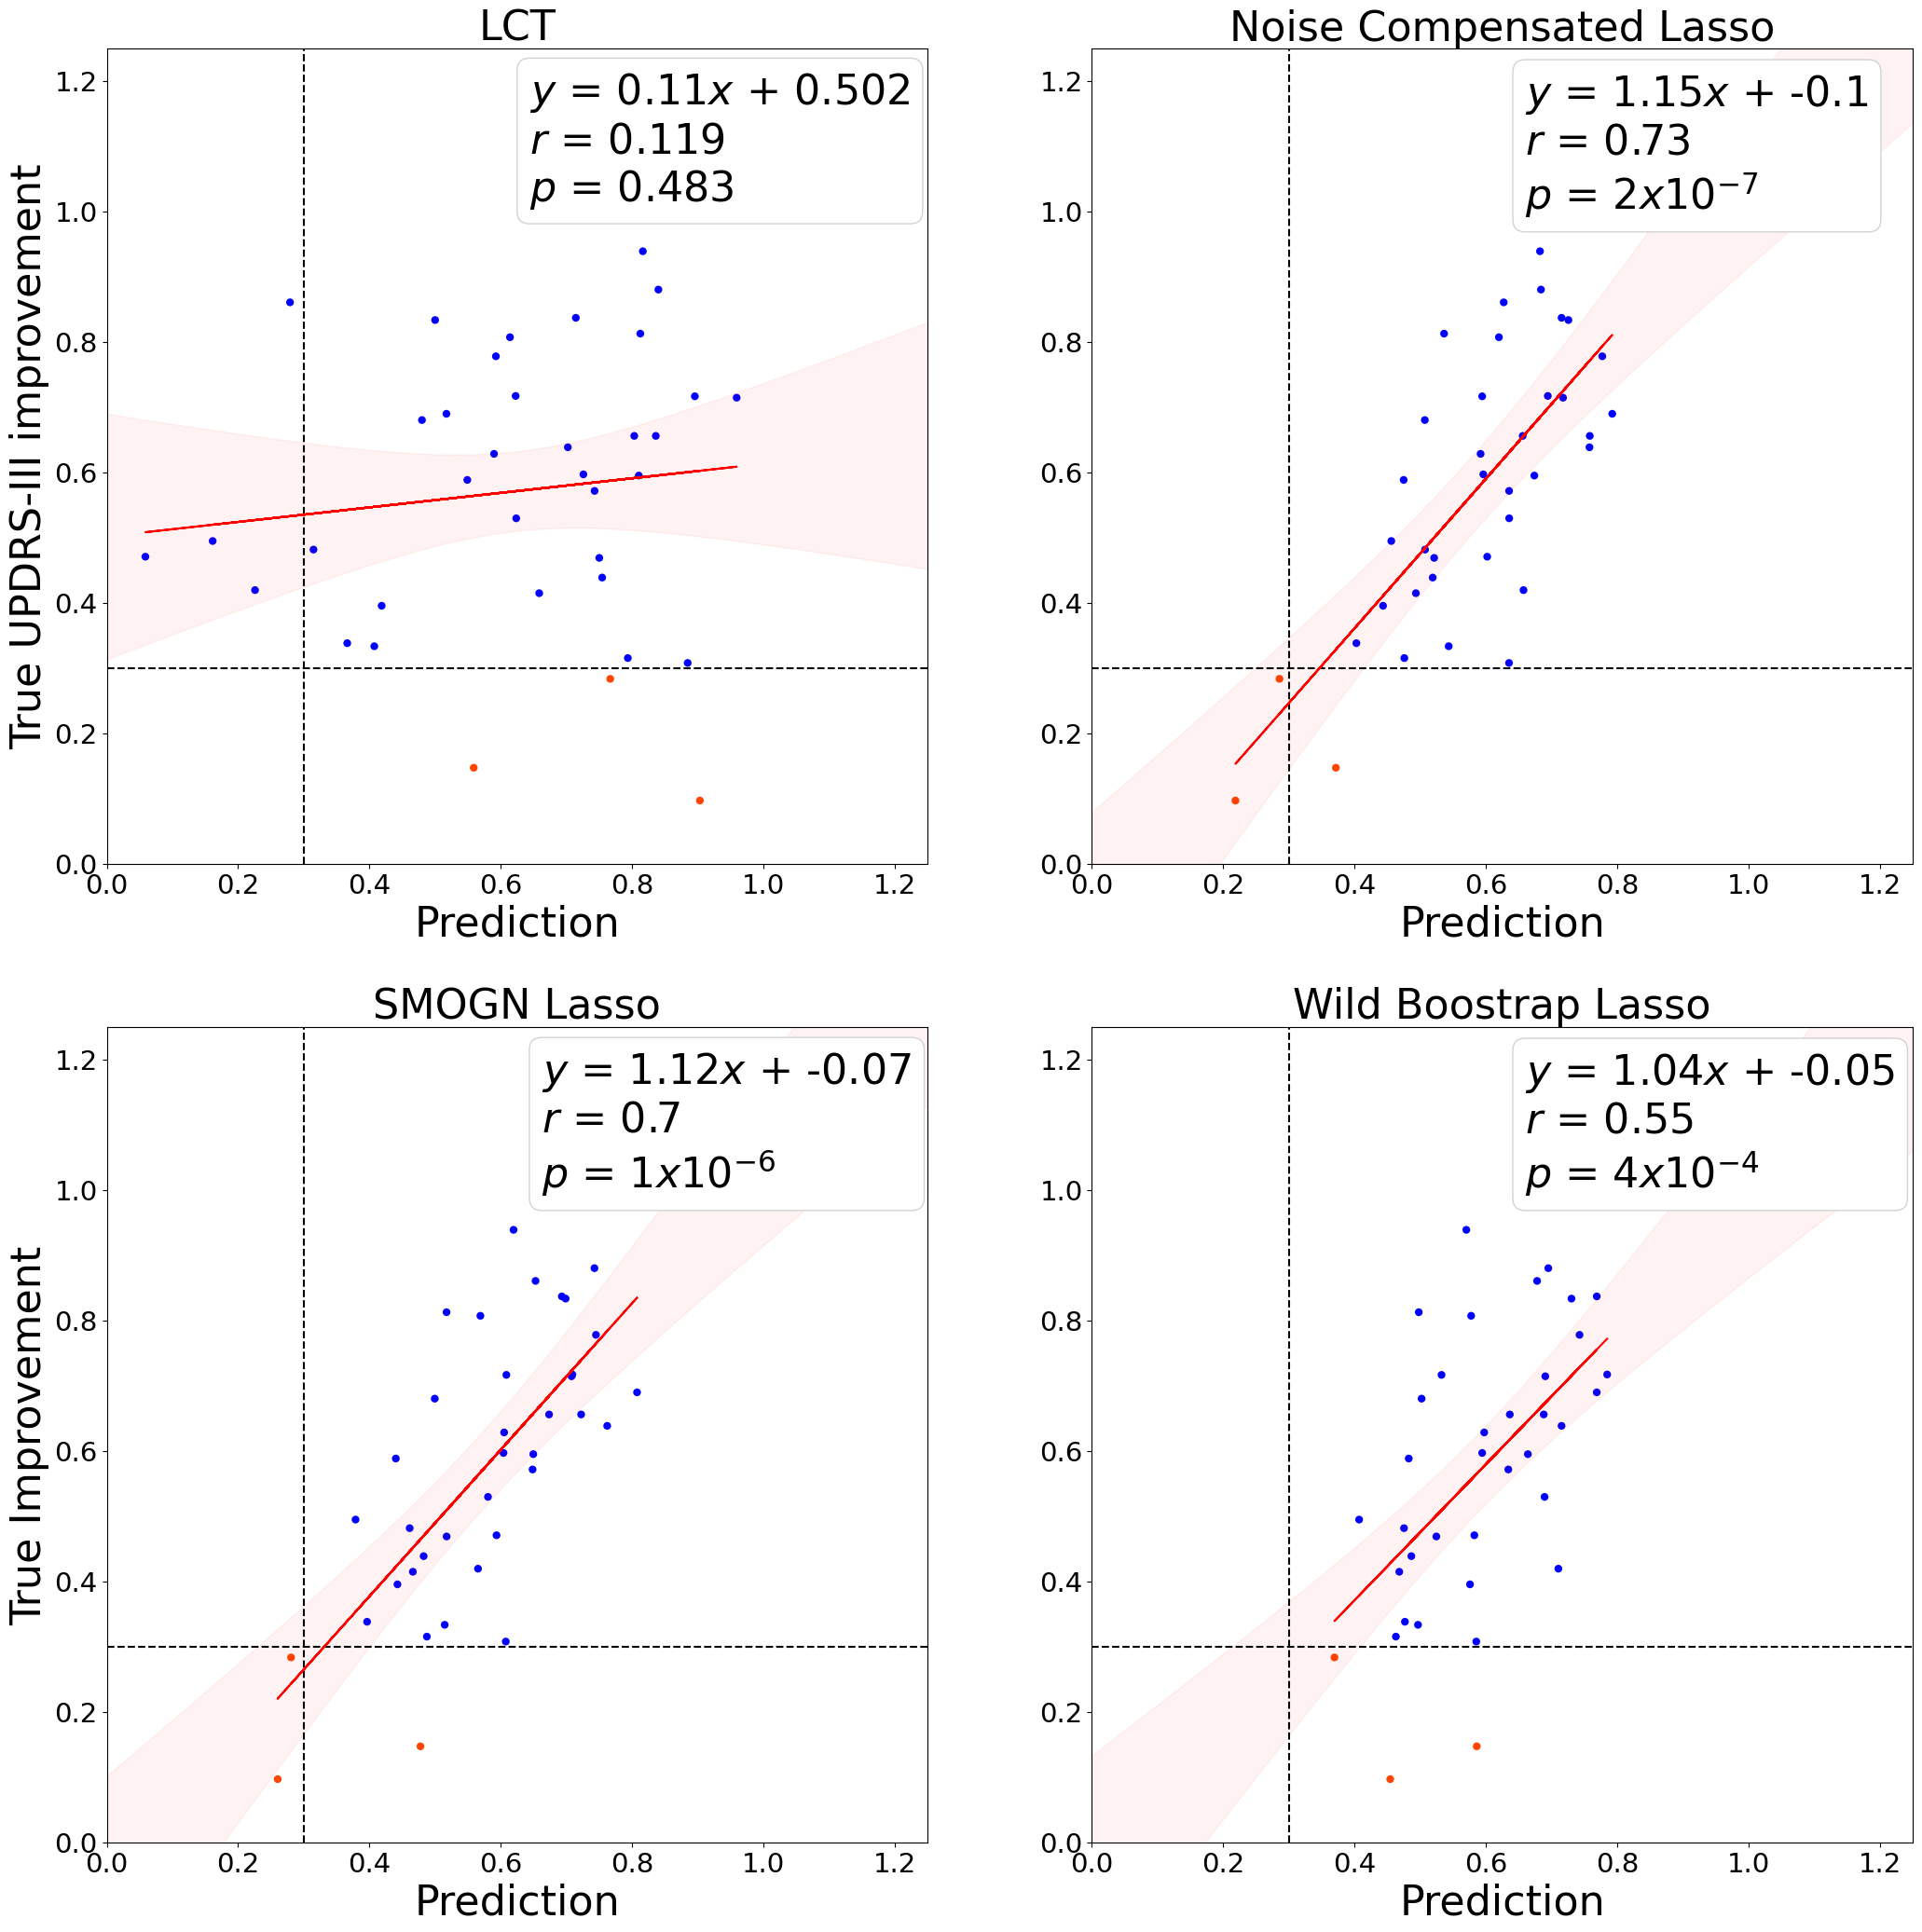

In [16]:
ylim = 1.25
fs = 32
ofx = 0.515
ofy = 0.8
pre_imp = (np.asarray(pre_updrs_iii_off,dtype=float)-np.asarray(pre_updrs_iii_on,dtype=float))/np.asarray(pre_updrs_iii_off,dtype=float)
plt.rcParams['figure.figsize'] = [25, 25]
fig,ax = plt.subplots(2,2,sharex=True,sharey=True)
col = np.where(per_change <= 0.3,'orangered','blue')
ax[0,0].scatter(pre_imp,per_change, c=col,linewidth=0)
lr = stats.linregress(pre_imp,per_change)
y_model = pre_imp*lr.slope+lr.intercept
ax[0,0].plot(pre_imp,y_model,color='r')
ci,pi,x_line,y_line = util.confidence_interval(pre_imp,per_change,ylim)
ax[0,0].fill_between(x_line, (y_line+ci), (y_line-ci), color='r', alpha=0.05)
ax[0,0].text(ofx,ofy,'$y$ = '+str(np.round(lr.slope,2))+'$x$ + '+str(np.round(lr.intercept,3))+'\n'+'$r$ = '+str(np.round(lr.rvalue,3))+'\n'+'$p$ = '+str(('{:.3f}'.format(lr.pvalue))),
                    ha='left', va='bottom', transform=ax[0,0].transAxes,fontsize=fs,
                    bbox=dict(facecolor='white', edgecolor='lightgray', boxstyle='round')) 
ax[0,0].hlines(0.3,0,2,linestyle='dashed',color='black')
ax[0,0].vlines(0.3,0,2,linestyle='dashed',color='black')
ax[0,0].set_title('LCT',fontsize=fs)
ax[0,0].set_xlabel('Prediction',fontsize=fs)
ax[0,0].xaxis.set_tick_params(labelleft=True,labelsize=fs//1.5)
ax[0,0].set_xlim([0,ylim])
ax[0,0].set_ylabel('True UPDRS-III improvement',fontsize=fs)
ax[0,0].yaxis.set_tick_params(labelleft=True,labelsize=fs//1.5)
ax[0,0].set_ylim([0,ylim])

ax[0,1].scatter(np.median(results_ls_aug,axis=0),per_change, c=col,linewidth=0)
lr = stats.linregress(np.squeeze(np.median(results_ls_aug,axis=0)),per_change)
y_model = np.median(results_ls_aug,axis=0)*lr.slope+lr.intercept
ax[0,1].plot(np.median(results_ls_aug,axis=0),y_model,color='r')
ci,pi,x_line,y_line = util.confidence_interval(np.median(results_ls_aug,axis=0),per_change,ylim)
ax[0,1].fill_between(x_line,y_line+ci,y_line-ci,color = 'r',label = '95% confidence interval',alpha=0.05)
pl = r'$'+latex_sci(lr.pvalue,0)+'$'
ax[0,1].text(ofx+0.013,ofy-0.01,'$y$ = '+str(np.round(lr.slope,2))+'$x$ + '+str(np.round(lr.intercept,2))+'\n'+'$r$ = '+str(np.round(lr.rvalue,2))+'\n'+'$p$ = '+pl,
                    ha='left', va='bottom', transform=ax[0,1].transAxes,fontsize=fs,
                    bbox=dict(facecolor='white', edgecolor='lightgray', boxstyle='round')) 
ax[0,1].hlines(0.3,0,2,linestyle='dashed',color='black')
ax[0,1].vlines(0.3,0,2,linestyle='dashed',color='black')
ax[0,1].set_title('Noise Compensated Lasso',fontsize=fs)
ax[0,1].set_xlabel('Prediction',fontsize=fs)
ax[0,1].xaxis.set_tick_params(labelleft=True,labelsize=fs//1.5)
ax[0,1].yaxis.set_tick_params(labelleft=True,labelsize=fs//1.5)

ax[1,0].scatter(np.median(results_ls_smogn,axis=0),per_change, c=col,linewidth=0)
lr = stats.linregress(np.squeeze(np.median(results_ls_smogn,axis=0)),per_change)
y_model = np.median(results_ls_smogn,axis=0)*lr.slope+lr.intercept
ax[1,0].plot(np.median(results_ls_smogn,axis=0),y_model,color='r')
ci,pi,x_line,y_line = util.confidence_interval(np.median(results_ls_smogn,axis=0),per_change,ylim)
ax[1,0].fill_between(x_line,y_line+ci,y_line-ci,color = 'r',label = '95% confidence interval',alpha=0.05)
pl = r'$'+latex_sci(lr.pvalue,0)+'$'
ax[1,0].text(ofx+0.015,ofy-0.01,'$y$ = '+str(np.round(lr.slope,2))+'$x$ + '+str(np.round(lr.intercept,2))+'\n'+'$r$ = '+str(np.round(lr.rvalue,2))+'\n'+'$p$ = '+pl,
                    ha='left', va='bottom', transform=ax[1,0].transAxes,fontsize=fs,
                    bbox=dict(facecolor='white', edgecolor='lightgray', boxstyle='round')) 
ax[1,0].hlines(0.3,0,2,linestyle='dashed',color='black')
ax[1,0].vlines(0.3,0,2,linestyle='dashed',color='black')
ax[1,0].set_xlabel('Prediction',fontsize=fs)
ax[1,0].xaxis.set_tick_params(labelleft=True,labelsize=fs//1.5)
ax[1,0].set_ylabel('True Improvement',fontsize=fs)
ax[1,0].yaxis.set_tick_params(labelleft=True,labelsize=fs//1.5)
ax[1,0].set_title('SMOGN Lasso',fontsize=fs)

ax[1,1].scatter(np.median(results_ls_wbs,axis=0),per_change, c=col,linewidth=0)
lr = stats.linregress(np.squeeze(np.median(results_ls_wbs,axis=0)),per_change)
y_model = np.median(results_ls_wbs,axis=0)*lr.slope+lr.intercept
ax[1,1].plot(np.median(results_ls_wbs,axis=0),y_model,color='r')
ci,pi,x_line,y_line = util.confidence_interval(np.median(results_ls_wbs,axis=0),per_change,ylim)
ax[1,1].fill_between(x_line,y_line+ci,y_line-ci,color = 'r',label = '95% confidence interval',alpha=0.05)
pl = r'$'+latex_sci(lr.pvalue,0)+'$'
ax[1,1].text(ofx+0.013,ofy-0.01,'$y$ = '+str(np.round(lr.slope,2))+'$x$ + '+str(np.round(lr.intercept,2))+'\n'+'$r$ = '+str(np.round(lr.rvalue,2))+'\n'+'$p$ = '+pl,
                    ha='left', va='bottom', transform=ax[1,1].transAxes,fontsize=fs,
                    bbox=dict(facecolor='white', edgecolor='lightgray', boxstyle='round')) 

ax[1,1].hlines(0.3,0,2,linestyle='dashed',color='black')
ax[1,1].vlines(0.3,0,2,linestyle='dashed',color='black')
ax[1,1].set_xlabel('Prediction',fontsize=fs)
ax[1,1].xaxis.set_tick_params(labelleft=True,labelsize=fs//1.5)
ax[1,1].yaxis.set_tick_params(labelleft=True,labelsize=fs//1.5)
ax[1,1].set_title('Wild Boostrap Lasso',fontsize=fs)

plt.style.use('default')

In [17]:
import scipy

In [18]:
def rec(res,pc):
        y_true = pc
        y_pred = res
        epsilon_0 = 0.0
        epsilon_max = 1.0
        d_epsilon = 0.01
        y = []
        x = np.arange(epsilon_0,epsilon_max,d_epsilon)
        epsilon = np.abs(y_true-y_pred) 
        for j in np.arange(len(x)):
            c = 0
            for k in np.arange(len(epsilon)):
                if epsilon[k] < x[j]:
                    c = c+1
            y.append(c/len(y_true))
        auc_rec = scipy.integrate.simps(y,x)/epsilon_max
        return x, np.array(y), auc_rec



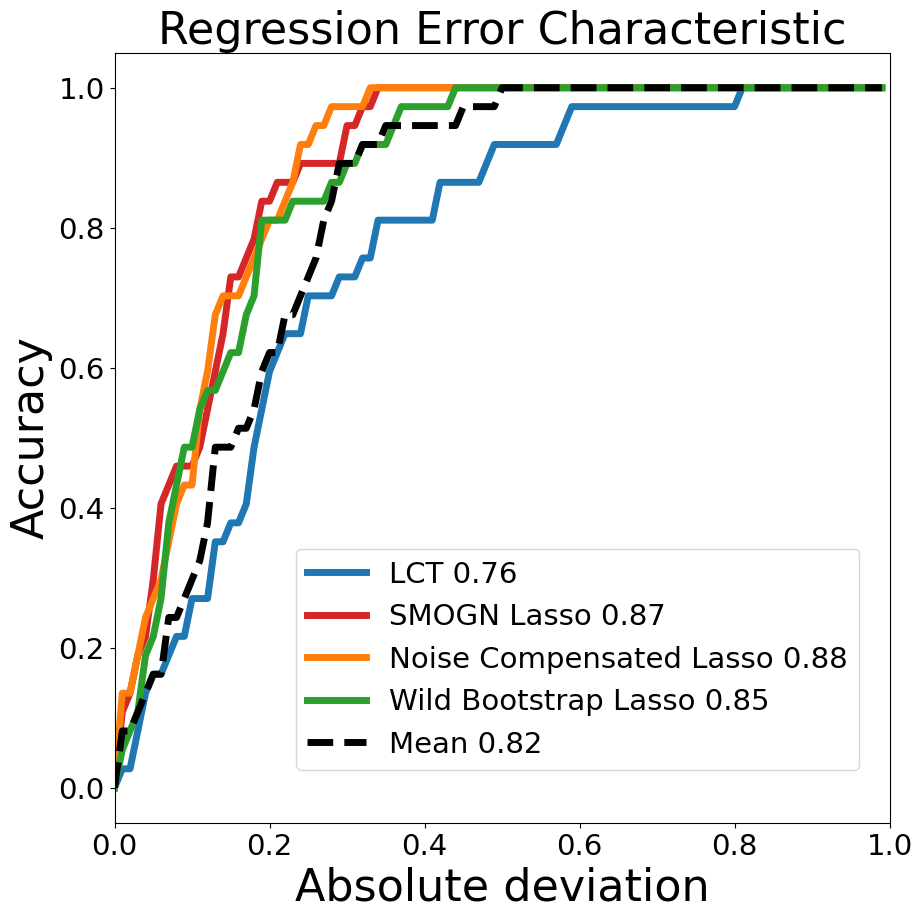

In [19]:
plt.rcParams["figure.figsize"] = (10,10)
fig,ax = plt.subplots(1,1,sharex=True,sharey=True)
x_lct,y_lct,eta = rec(pre_imp,per_change)
plt.plot(x_lct,y_lct,linewidth=5,label='LCT %0.2f' % eta, color='tab:blue')
# x_ls,y_ls,a,eta = rec(results_ls,per_change)
# plt.plot(x_ls,y_ls,label='Lasso %0.2f' % eta)
# x_ls,y_ls,eta = rec(results_lsw,per_change)
# plt.plot(x_ls,y_ls,linewidth=5,label='Bootstrap Lasso %0.3f' % eta, color='tab:blue')
x_smogn,y_smogn,eta = rec(np.median(results_ls_smogn,axis=0),per_change)
plt.plot(x_smogn,y_smogn,linewidth=5,label='SMOGN Lasso %0.2f' % eta, color='tab:red')
x_lsa,y_lsa,eta = rec(np.median(results_ls_aug,axis=0),per_change)
plt.plot(x_lsa,y_lsa,linewidth=5,label='Noise Compensated Lasso %0.2f' % eta, color='tab:orange')
x_wbs,y_wbs,eta = rec(np.median(results_ls_wbs,axis=0),per_change)
plt.plot(x_wbs,y_wbs,linewidth=5,label='Wild Bootstrap Lasso %0.2f' % eta, color="tab:green")
x_n,y_n,eta = rec(np.median(per_change)*np.ones_like(per_change),per_change)
plt.plot(x_n,y_n,linestyle='dashed',color='k',linewidth=5,label='Mean %0.2f' % eta)
plt.xlabel('Absolute deviation',fontsize=fs)
plt.ylabel('Accuracy',fontsize=fs)
plt.xlim([0,1])
plt.title('Regression Error Characteristic',fontsize=fs)
ax.xaxis.set_tick_params(labelleft=True,labelsize=fs//1.5)
ax.yaxis.set_tick_params(labelleft=True,labelsize=fs//1.5)
ax.legend(bbox_to_anchor=(0.215,0.375),fontsize=fs//1.5)
